## Part I: Getting the data ##

In [217]:
"For data magic: the actual work"
import pandas as pd
import numpy as np
import csv                          #This helps generating dataframes in pandas
import matplotlib.pyplot as plt #eyes over brains
from sklearn import preprocessing
import seaborn as sn
from scipy import stats

"Naming files and administration magic"
import time
import os #to rename filenames
import shutil

"To scrape: webbrowsers"
import selenium                     #this is for scraping a webpage
from selenium import webdriver      #automatic datascraping is useful for auto-update in future
from selenium.common.exceptions import NoSuchElementException #for selenium
import io  #Ehhh... not sure what this does yet
from selenium.webdriver.common.keys import Keys # for "click" function that helps downloading
import requests                     #This is for scraping
from bs4 import BeautifulSoup       #This is for scraping
import webbrowser                   #you cant really browse without a webbrowser, do you? 

In [2]:
def get_driver_version_in_zip(version: int): 
    """
I took this function  from Stack overflow 
and it gets a freshly working webdriver from the internet, 
the manual integer should be the version number of the chrome used on the PC.
    """
    url = 'https://chromedriver.storage.googleapis.com/LATEST_RELEASE_'
    url_file = 'https://chromedriver.storage.googleapis.com/'
    file_name = 'chromedriver_win32.zip'

    version = input()
    version_response = requests.get(url + version)

    if version_response.text:
        file = requests.get(url_file + version_response.text + '/' + file_name)
        with open(file_name, "wb") as code:
            code.write(file.content)
    print('version number: ', version)

def rename_file(original, new):
    os.rename(original,new)
    return new

### Checking what kind of webpage are we scraping from ###

In [210]:
driver = webdriver.Chrome('./chromedriver')
driver.get('http://insideairbnb.com/get-the-data.html')
html_source = driver.page_source #Makes soup
soup = BeautifulSoup(html_source, 'html.parser')
# print(soup.prettify())

#First, let's make the list of all the urls. 
url_list = []
for url in soup.find_all('a'):
    url_list.append(url)
#Let's convert the Bs4 element tags to string for ease of usage    
for i in range (len(url_list)):
    url_list[i] = str(url_list[i])
#url_list

### Now let's scrape the data! ### 
(It is markdown now not to trigger a long scrape accidentally! :) ) 

links = [] #For links containing our beloved city of focus
city = ['berlin','Berlin'] #feel free to change it to anything else
#We make our url_list to a string from Beautiful Soup element tags
for i in range (len(url_list)): 
    url_list[i] = str(url_list[i])

for i in range(len(url_list)):
    url = url_list[i]
    #most likely upper-lowercase is irrelevant here but 
    #better run the program than using my brain and think about it
    if city[0] in url or city[1] in url: #if the name of the city is in the link we keep it 
        links.append(str(url))

#We will collect 2 types of csv over a 2021-2015 period
root_database_types = ['listings', 'reviews']
root_database_years = ['2021','2020','2019','2018','2017','2016','2015']
root_database_months= ['01','02','03','04','05','06','07','08','09','10','11','12']
current = os.getcwd()
raw_links = [] #raw_links is where we collect the links from the website that we want to download
for datayear in root_database_years: #which year
    for datamonth in root_database_months: #which month
        for datatype in root_database_types: #type of data
            for link in links:
                #we will collect csv-s, therefore '.csv.gz' is NOT IN the links we want to keep
                if datayear+'-'+datamonth in link and datatype in link and '.gz' not in link:
                    link = link[8:] #we leave the <a href= tag and start with the link
                    link = link.split(' ', 1)[0] 
                    link = link[1:-1]
                    raw_links.append(link) 
                    driver.get(link)
                    print(link)
                    time.sleep(120)
                    #rename_file('data/'+datatype+'.csv','data/'+datatype+'-'+datayear+'-'+datamonth+'.csv')
                    os.rename(current+'/data/'+datatype+'.csv',current+'/data/'+datatype+'-'+datayear+'-'+datamonth+'.csv')                    
raw_links    

## Part II: Setting up the functions to treat one dataframe! ##

df = pd.read_csv('data/listings-2016-04.csv')

In [53]:
#Creating the macrostats for numeric columns
def describe_numeric_columns(listings_dataframe):
    """
    This function returns the descriptive statistical values of the given columns in the df.
    These columns are: \n
    'latitude',  'longitude',  'minimum_nights', 
    'number_of_reviews','reviews_per_month', 
    'calculated_host_listings_count', 'availability_365'
    """
    #Let's keep the numeric values of the df
    only_numeric_df = listings_dataframe[['latitude',  'longitude',  'minimum_nights', 'number_of_reviews','reviews_per_month', 'calculated_host_listings_count', 'availability_365']]
    describe = only_numeric_df.describe() #Create pandas df description for numerics
    return describe #return the descriptive pandas df

#Counting the different properties in specific neighbourhoods
def bardiagram_dtype_review(column):
    """
    Plots a barplot of the given df column's unique_values on x and count valuse on y, \n
    whuile returns these numeric values in a list as result = [unique_values, count_of_values]
    """
    column = list(column)
    unique_values =list(set(column))
    count_of_values = []
    for i in range (len(unique_values)):
        x = column.count(unique_values[i])
        count_of_values.append(x)

    #Making a barplot about the results   
    fig, ax1 = plt.subplots()
    ax1.bar(unique_values,count_of_values, align='center', alpha=0.5)
    fig.autofmt_xdate()


    fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
    #Source for above snippet: https://www.semicolonworld.com/question/56046/matplotlib-how-to-prevent-x-axis-labels-from-overlapping-each-other

    plt.show()
    result = [unique_values, count_of_values]
    return result

def gethist_prices_return(df):
    """
    Plots a histrogram with 15 bins of the prices of the input dataframe \n
    and returns the price column of the df as a list
    """
    prices = list(df["price"])
    plt.hist(prices, bins = 15)
    plt.show()
    return prices

def gini(list_of_values):
    """Gini coefficient from \n
    https://gist.github.com/CMCDragonkai/c79b9a0883e31b327c88bfadb8b06fc4
    """
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

def lorenz_curve(X):
    """
    makes a Lorenz-curve from a list containing numbers
    """
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0) 
    X_lorenz[0], X_lorenz[-1]
    fig, ax = plt.subplots(figsize=[6,6])
    ## scatter plot of Lorenz curve
    ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, 
               marker='x', color='darkgreen', s=100)
    ## line plot of equality
    ax.plot([0,1], [0,1], color='k')
    
def plotprices(prices):
    """
    Plots the prices of the properties \n
    in a given time and in ascending order, while returns the list in ascending order
    """
    prices.sort()
    plt.plot(prices)
    return prices

def collect_data_from_timestamp_df(active_df, timestamp_name):
    """
    This is the main() function of the data iteration, that iterates a csv file df
    """
    timestamp = timestamp_name #So we savethe data
    active_df = active_df[active_df['price']<300] #eliminate outliers
    active_df.dropna() #drop non-values
    findnan = active_df.count() 

    #Checking the macrostats for minimum nights
    macrostat = describe_numeric_columns(active_df) 
    min_nights = macrostat["minimum_nights"] #we collect the descriptive stats of the most important numeric data
    print(timestamp, int(min_nights[0])) #We plot where are we for the reader and the number of properties
    
    rt = bardiagram_dtype_review(active_df["room_type"]) #plots the barchart of roomtypes
    nh = bardiagram_dtype_review(active_df["neighbourhood_group"]) #plots barchart of neighbourhoods
    prices = gethist_prices_return(active_df) #histogram of price distribution of properties
    gini_coeff = gini(prices) #gini_coefficient of prices
    prices = plotprices(prices) #let's plot prices in ascending order 
    
    result = [timestamp, macrostat, min_nights, rt, nh, prices, gini_coeff, prices]
    return result #we collect te results

listings-2015-10 15315


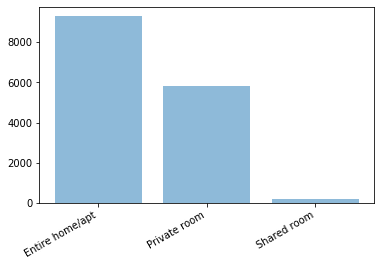

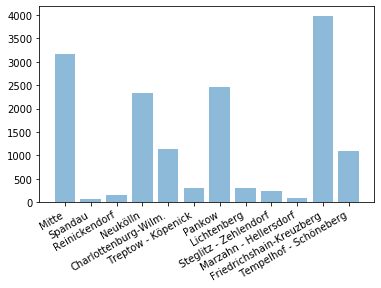

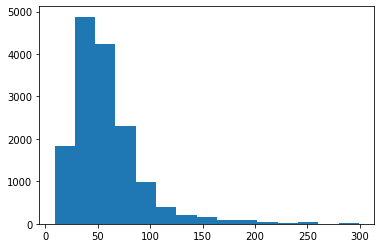

listings-2015-10 3984


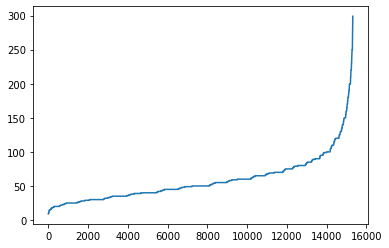

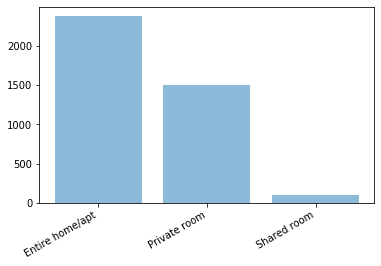

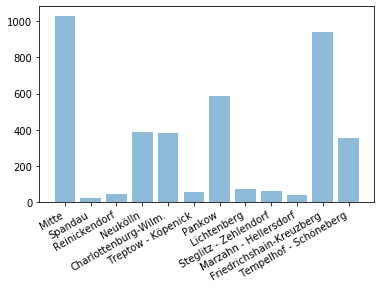

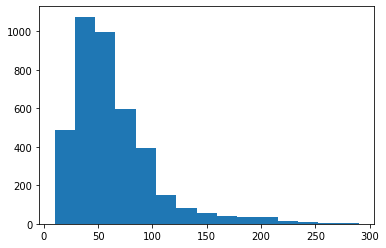

listings-2015-10 11331


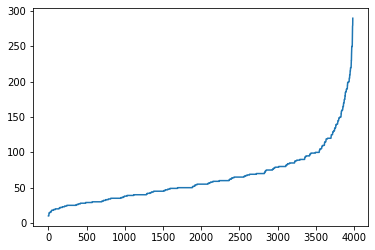

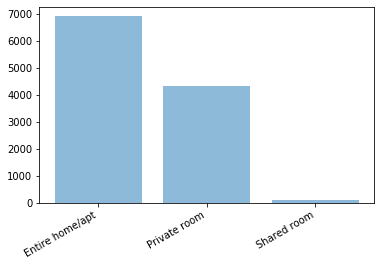

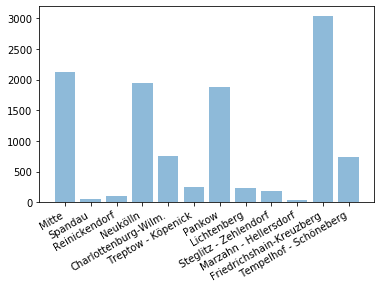

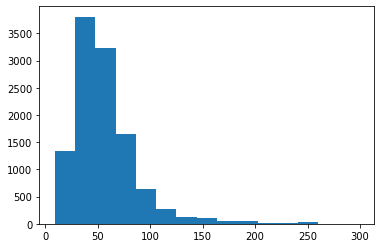

listings-2015-11 15571


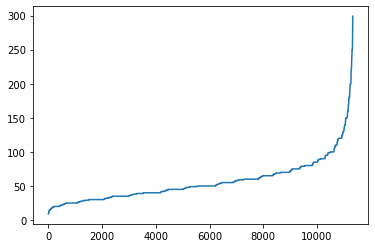

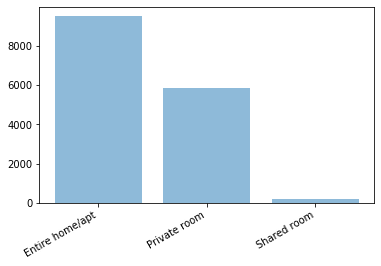

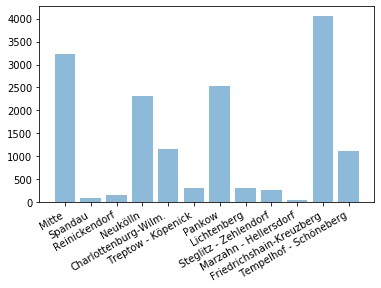

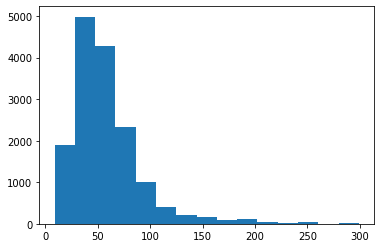

listings-2015-11 4145


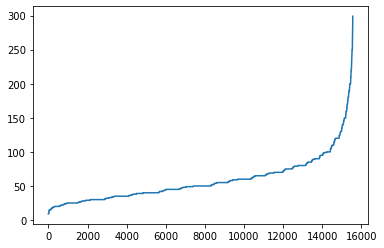

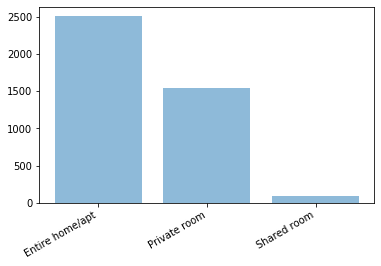

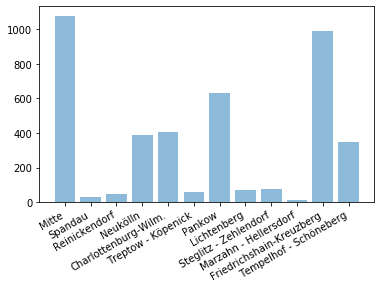

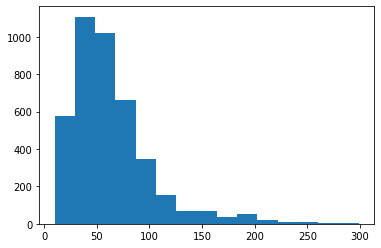

listings-2015-11 11426


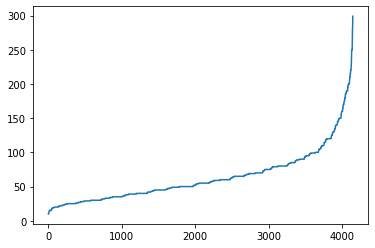

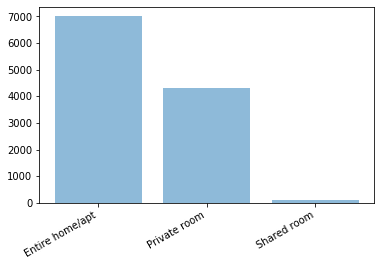

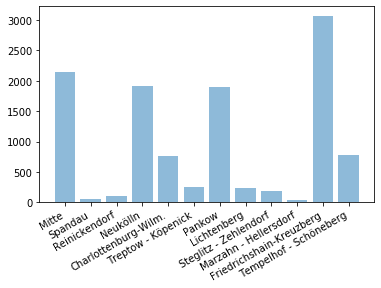

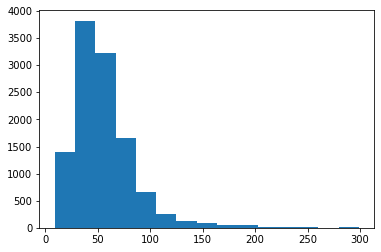

listings-2015-12 16488


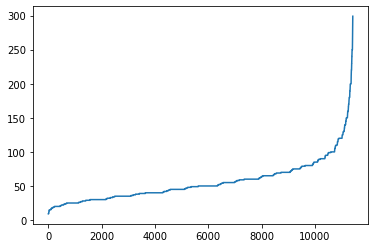

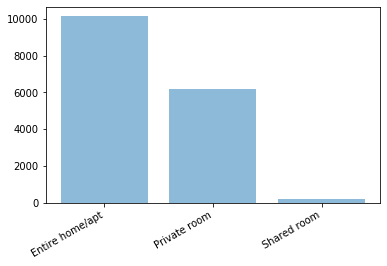

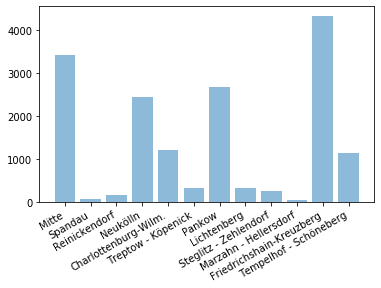

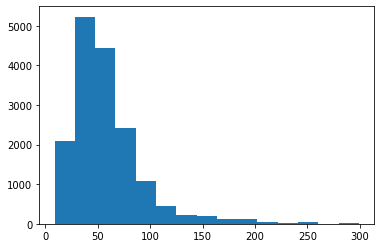

listings-2015-12 4768


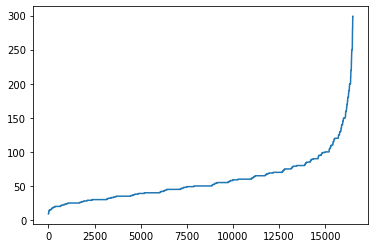

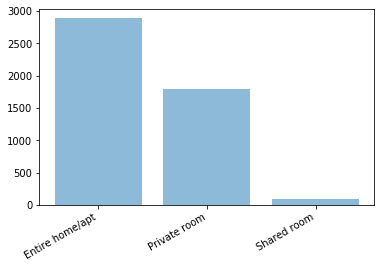

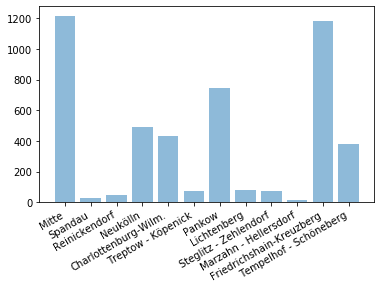

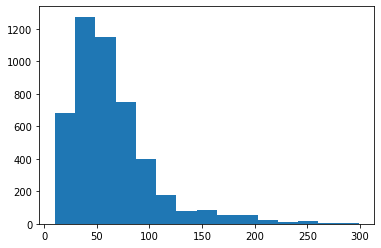

listings-2015-12 11720


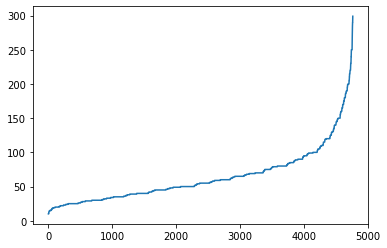

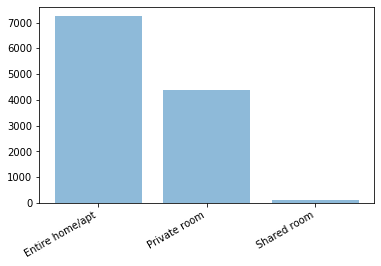

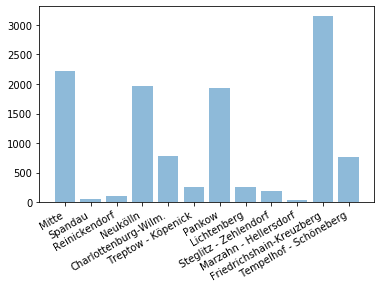

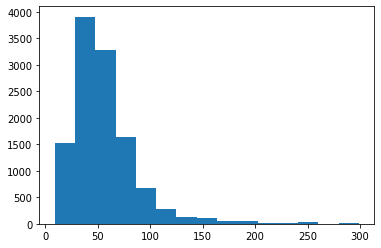

listings-2016-01 17215


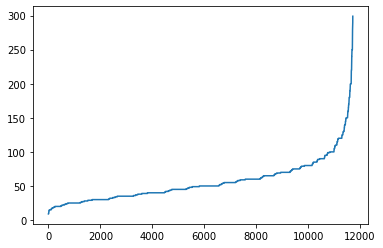

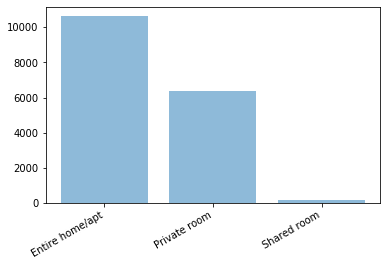

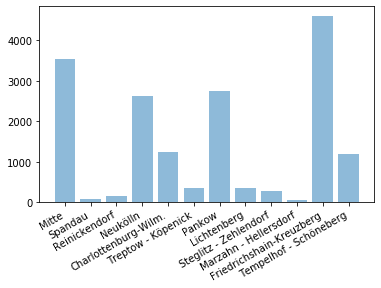

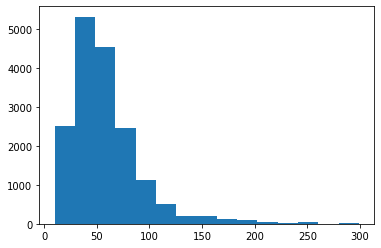

listings-2016-01 4880


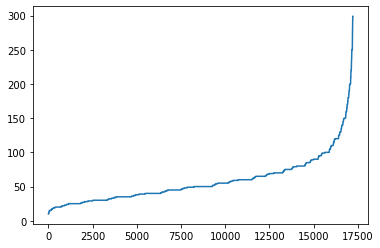

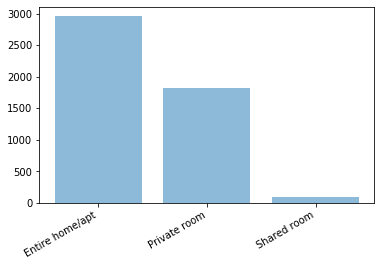

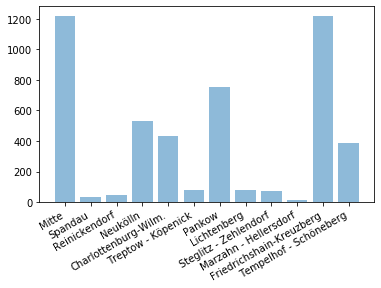

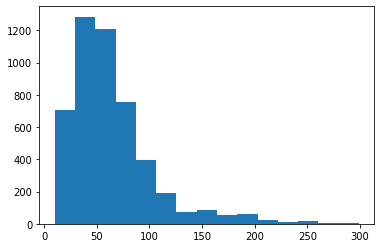

listings-2016-01 12335


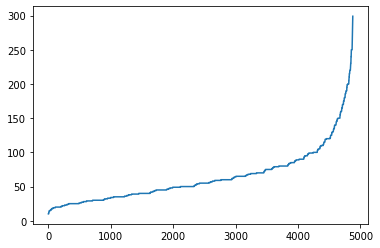

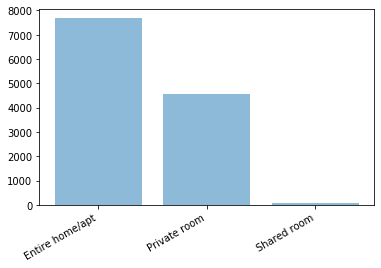

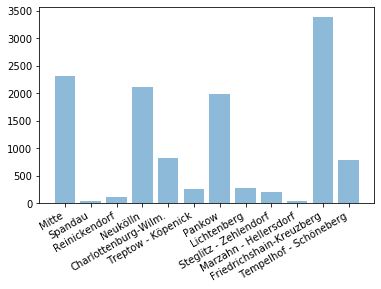

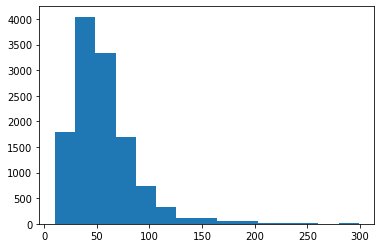

listings-2016-02 17290


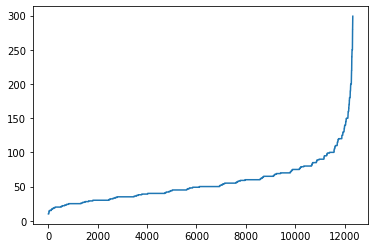

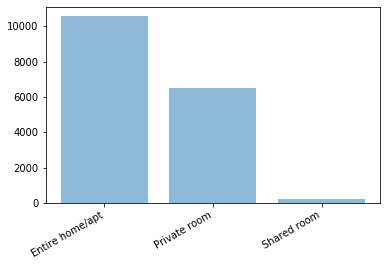

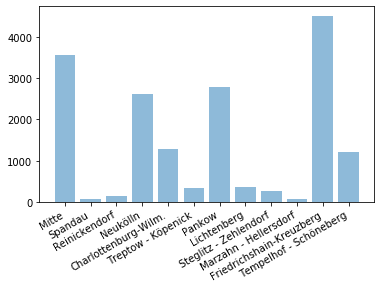

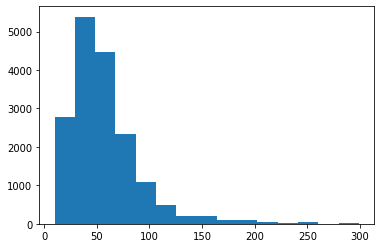

listings-2016-02 4873


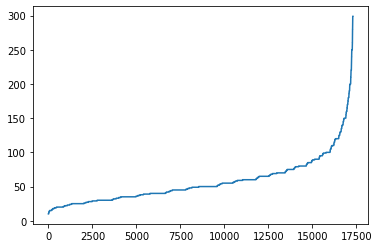

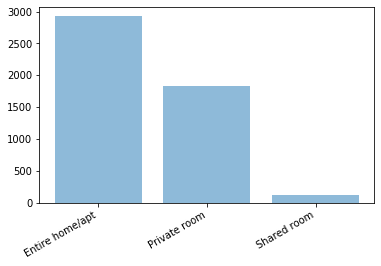

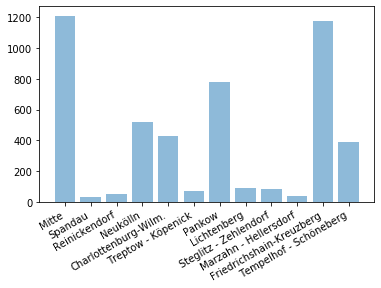

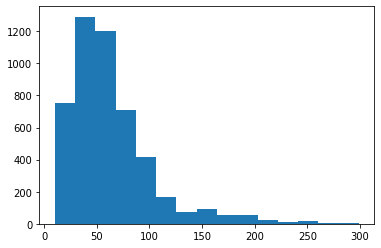

listings-2016-02 12417


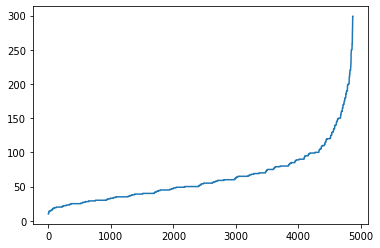

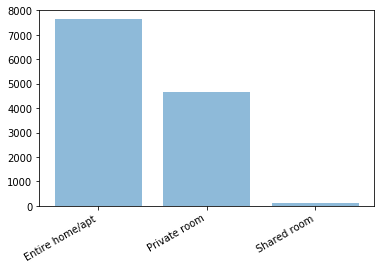

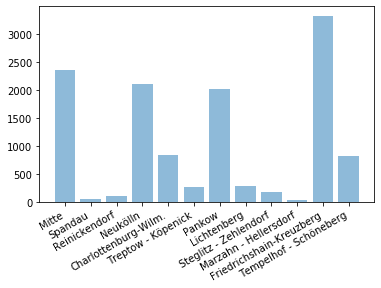

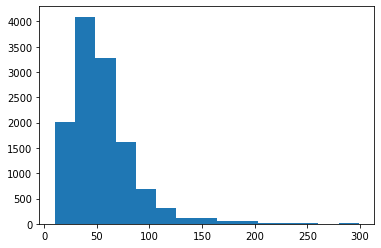

listings-2016-04 15606


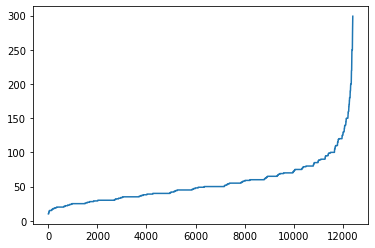

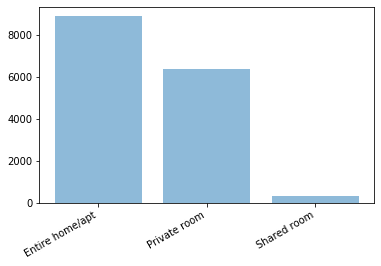

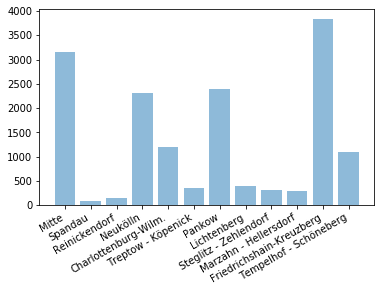

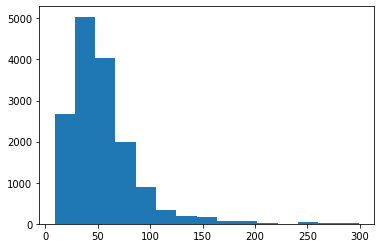

listings-2016-04 2976


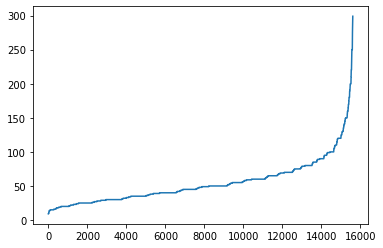

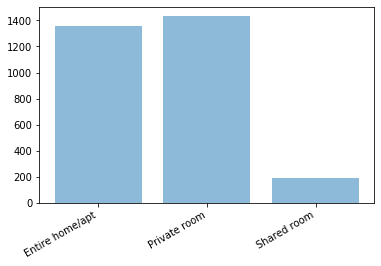

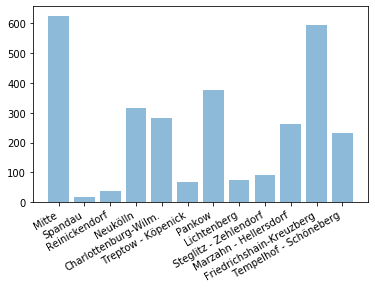

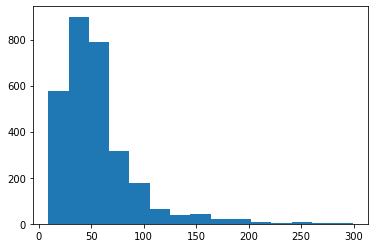

listings-2016-04 12630


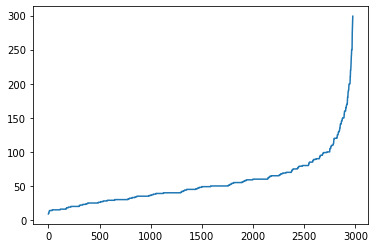

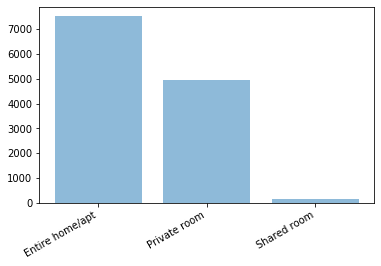

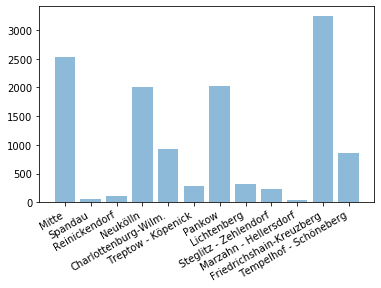

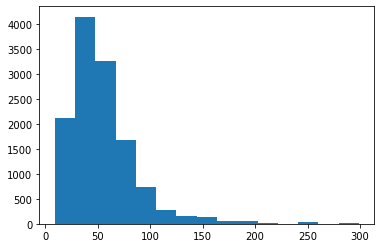

listings-2016-05 13263


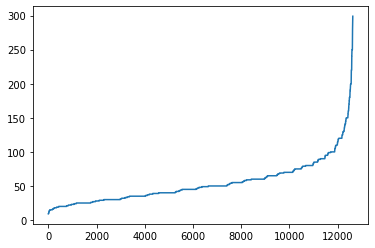

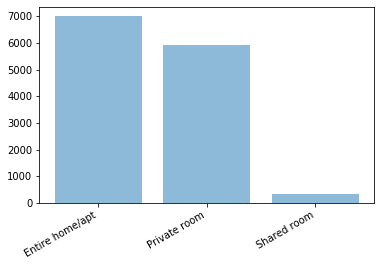

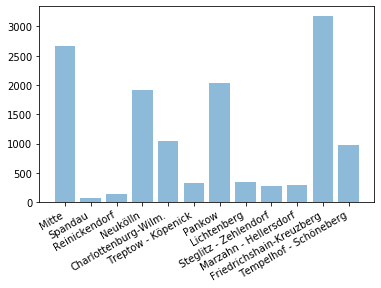

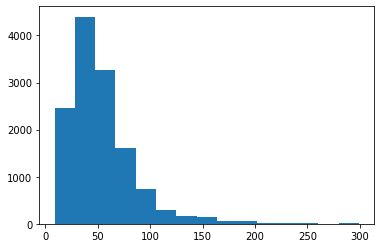

listings-2016-05 3005


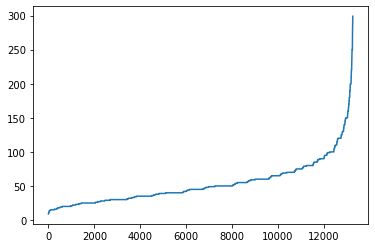

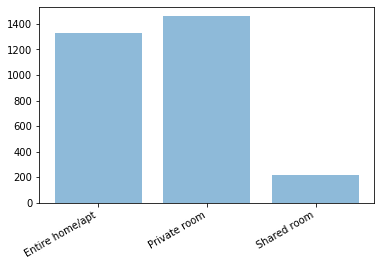

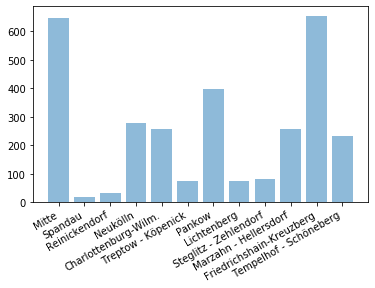

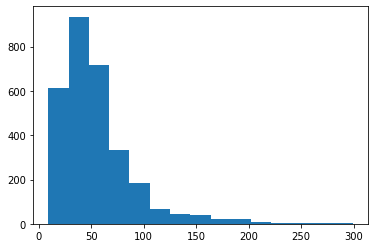

listings-2016-05 10258


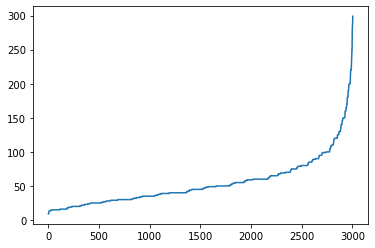

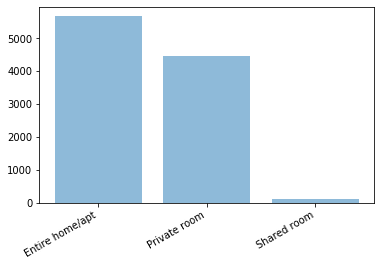

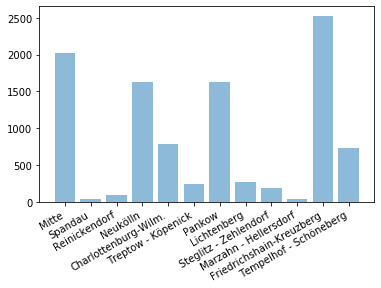

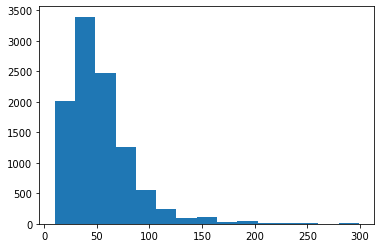

listings-2016-06 14671


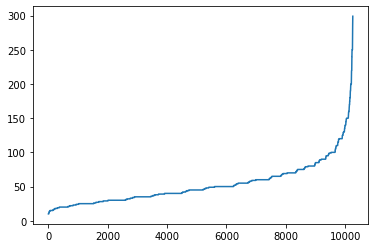

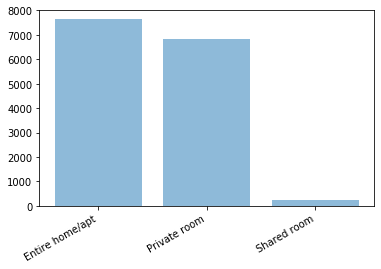

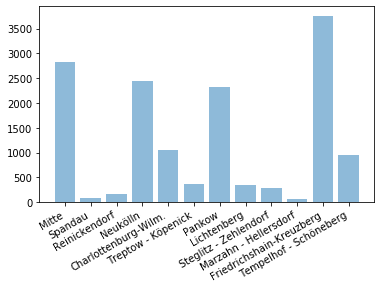

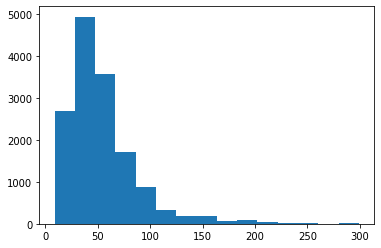

listings-2016-06 3231


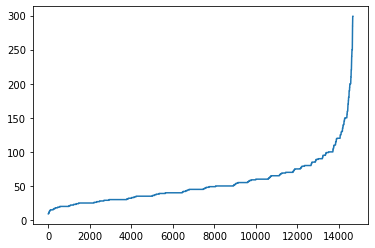

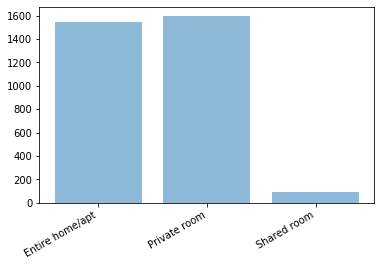

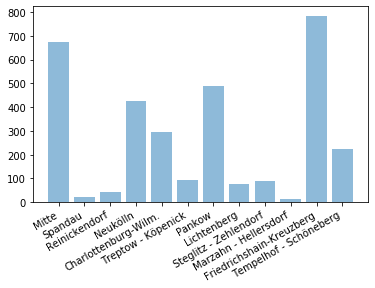

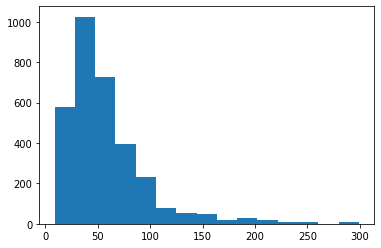

listings-2016-06 11440


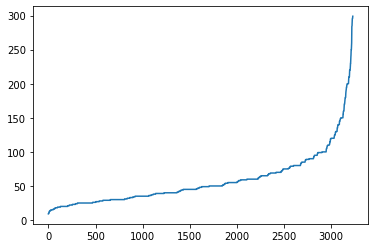

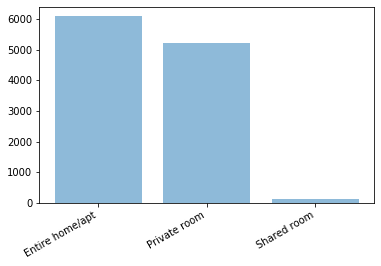

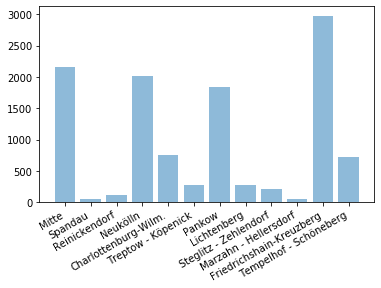

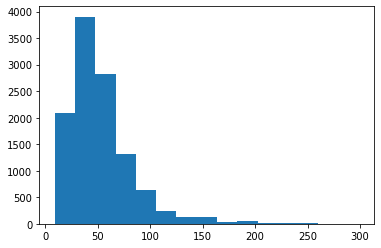

listings-2016-07 15134


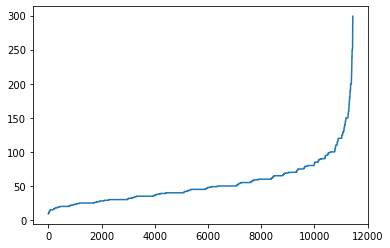

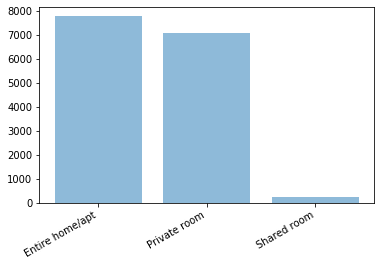

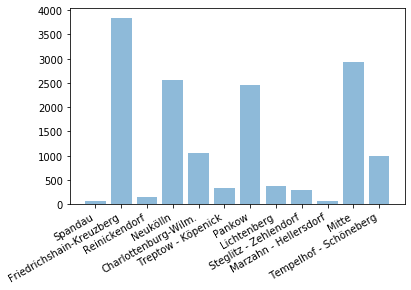

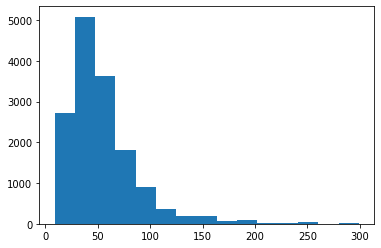

listings-2016-07 3346


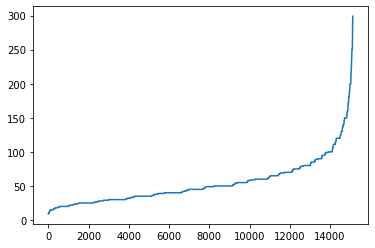

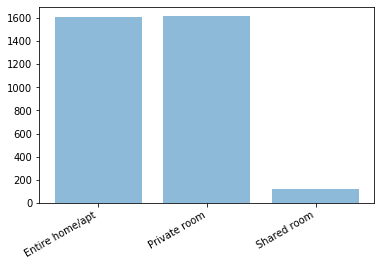

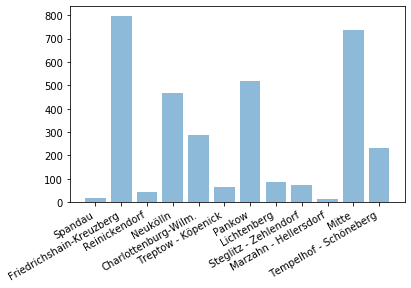

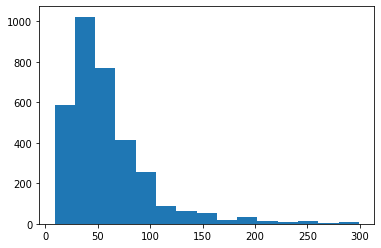

listings-2016-07 11788


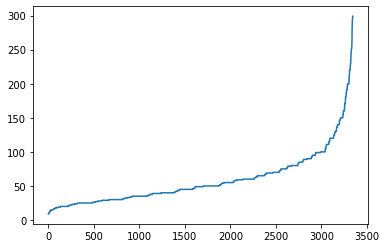

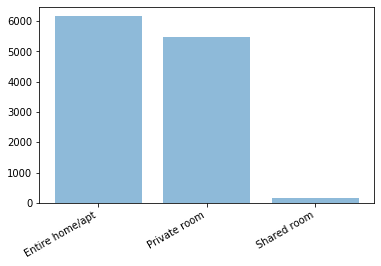

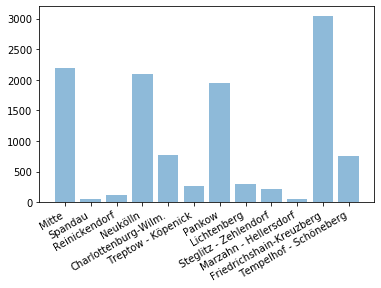

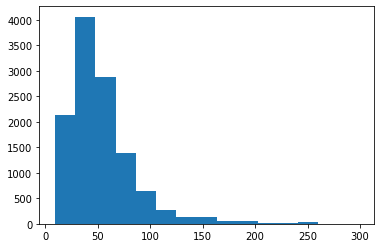

listings-2016-08 16565


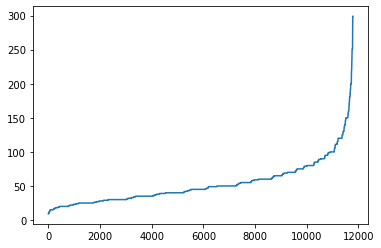

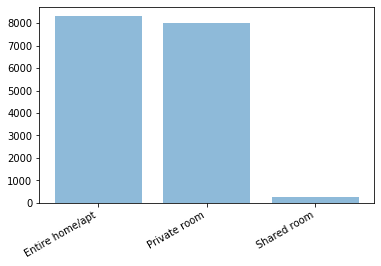

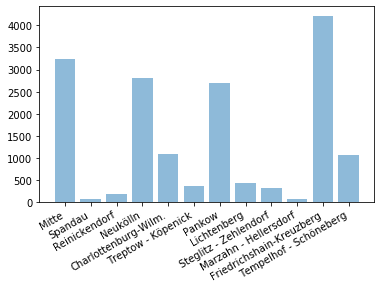

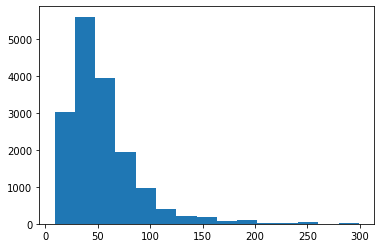

listings-2016-08 3592


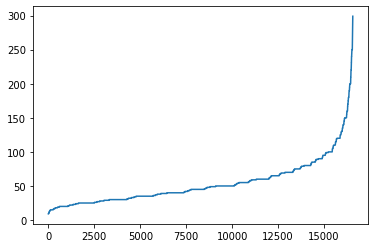

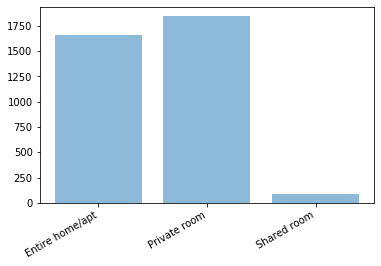

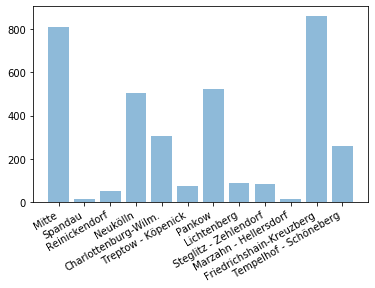

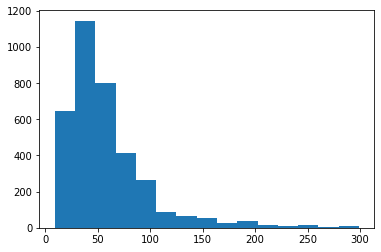

listings-2016-08 12973


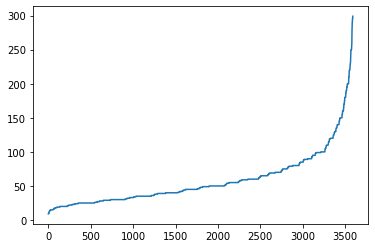

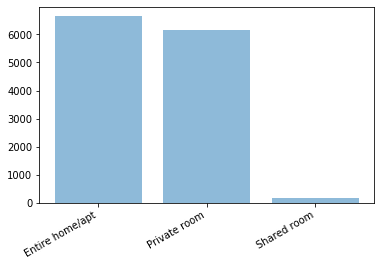

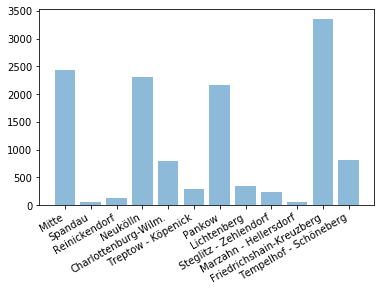

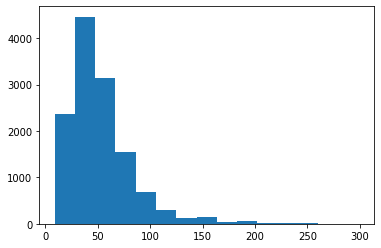

listings-2016-09 17008


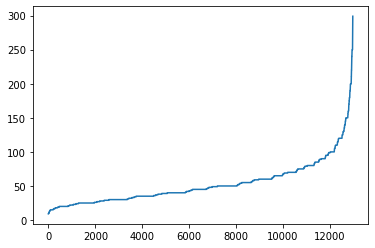

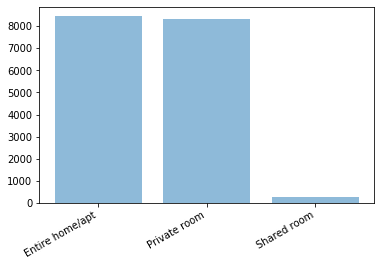

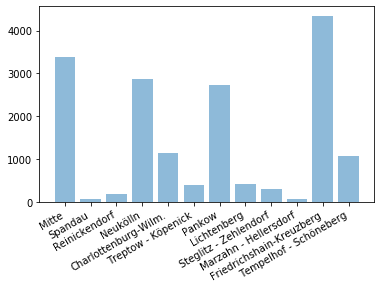

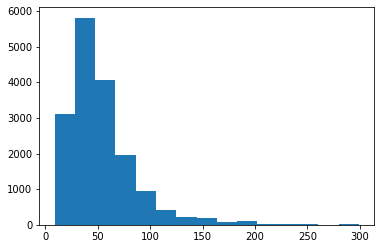

listings-2016-09 3627


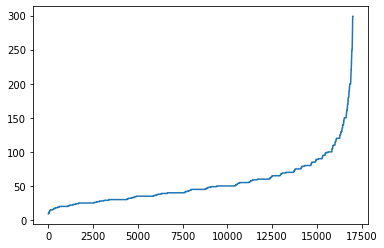

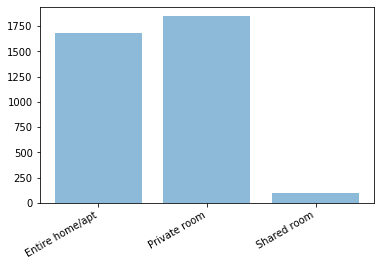

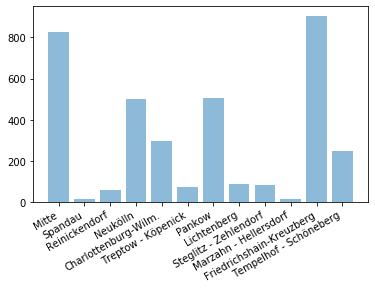

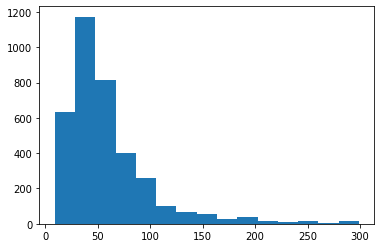

listings-2016-09 13381


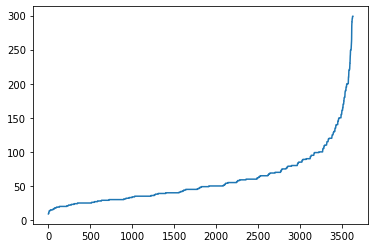

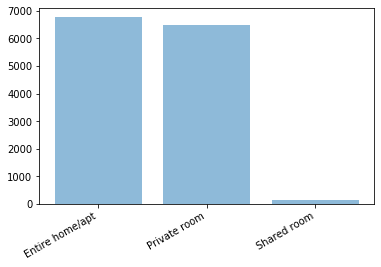

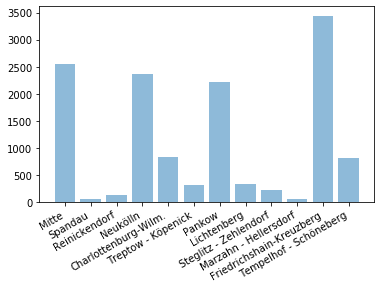

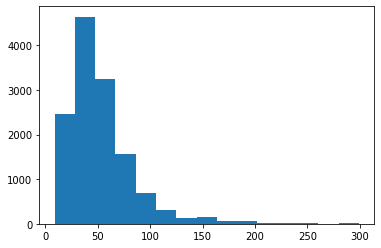

listings-2016-10 17101


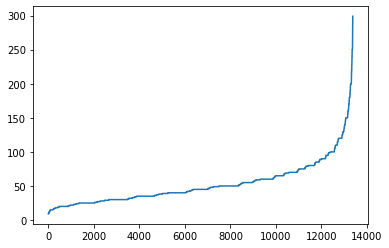

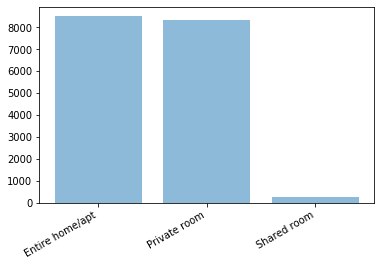

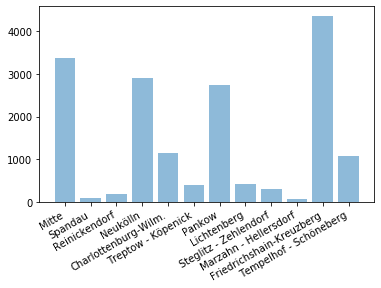

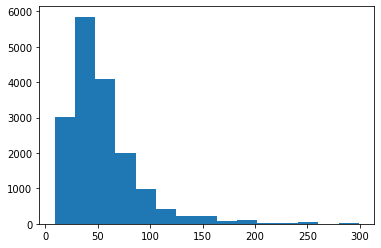

listings-2016-10 3602


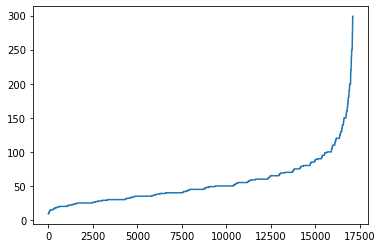

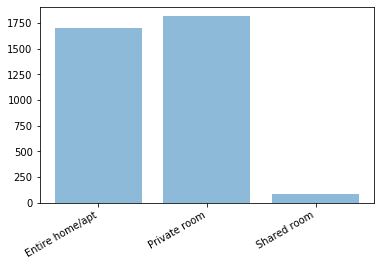

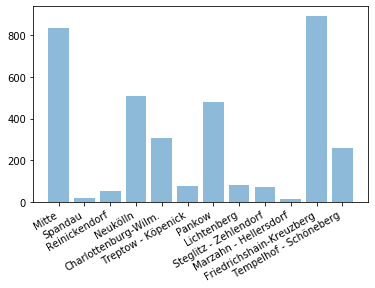

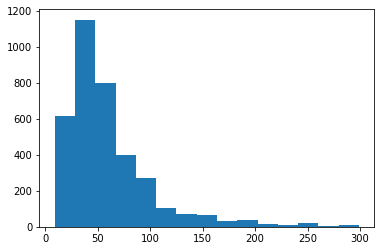

listings-2016-10 13499


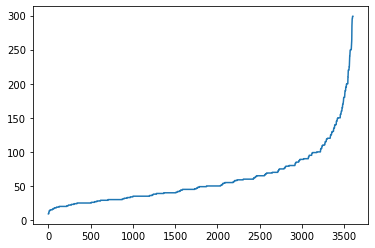

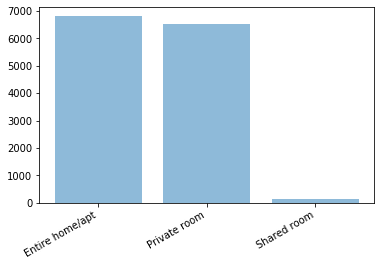

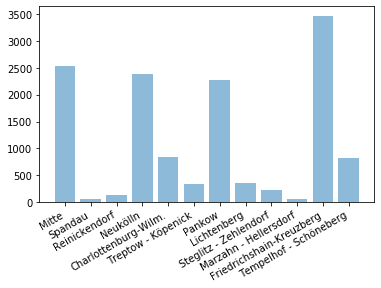

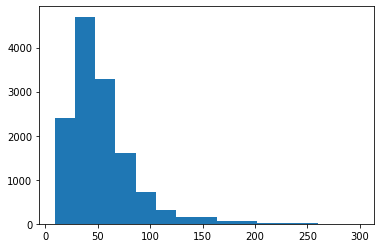

listings-2016-11 17372


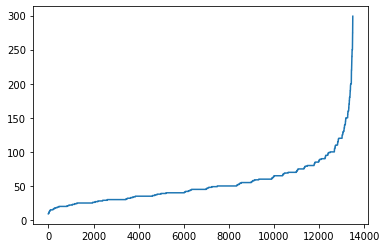

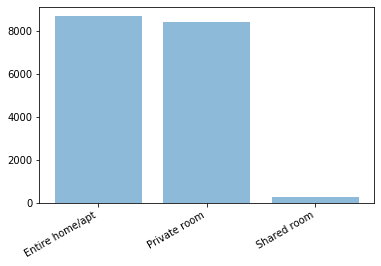

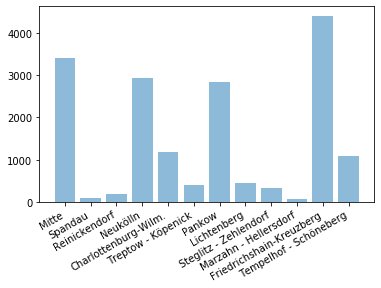

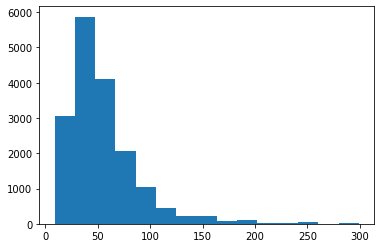

listings-2016-11 3722


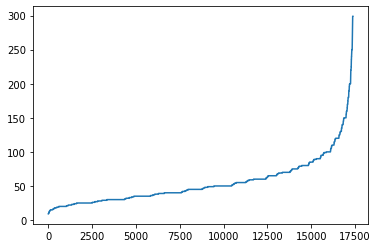

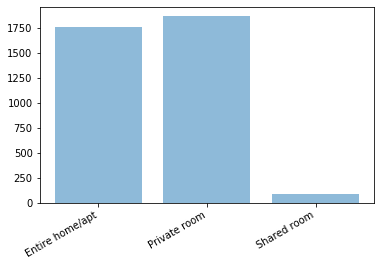

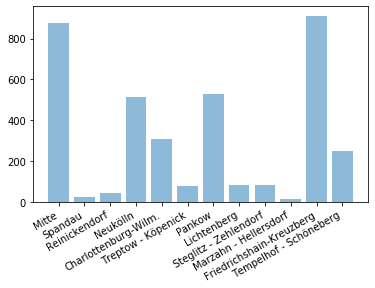

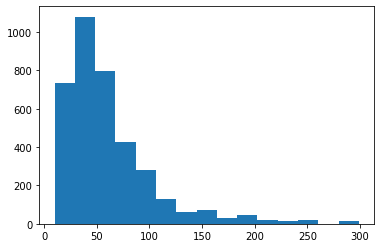

listings-2016-11 13650


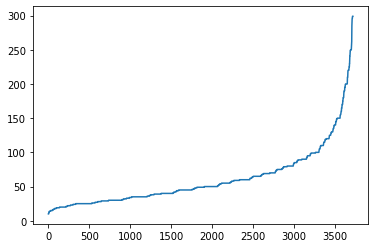

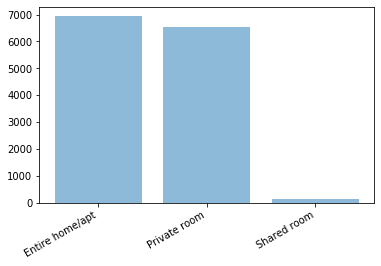

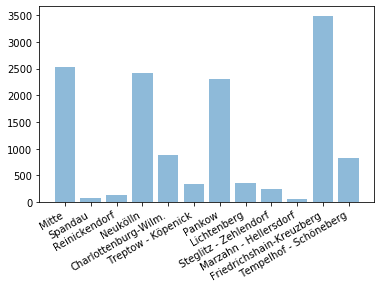

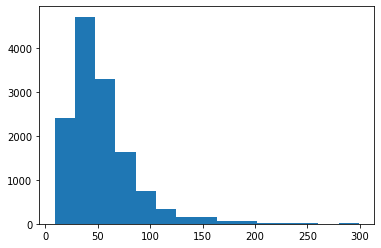

listings-2016-12 18266


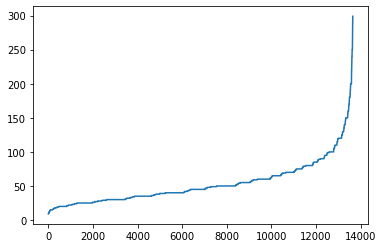

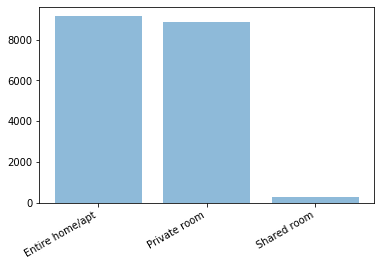

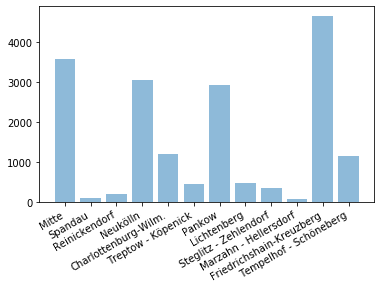

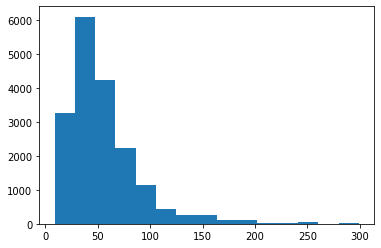

listings-2016-12 3950


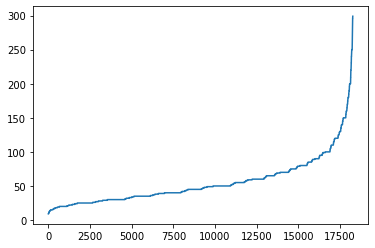

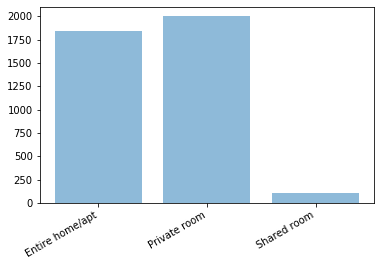

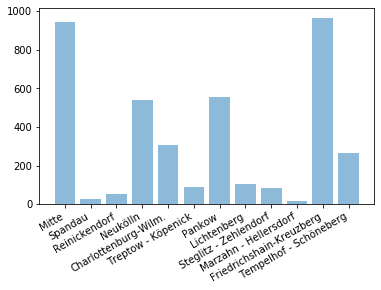

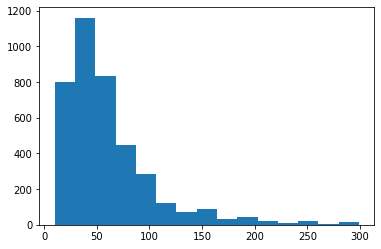

listings-2016-12 14316


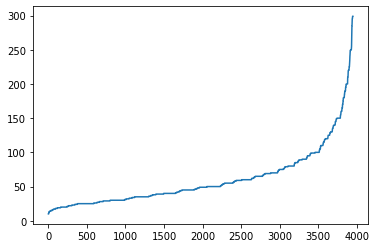

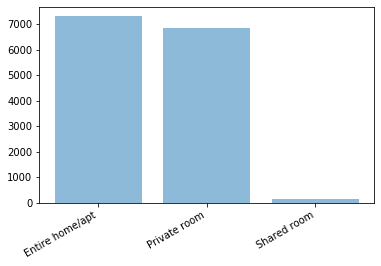

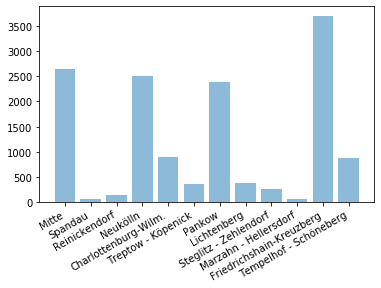

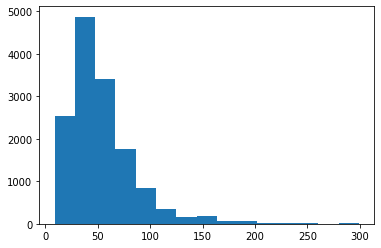

listings-2017-01 19032


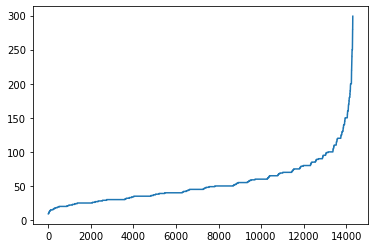

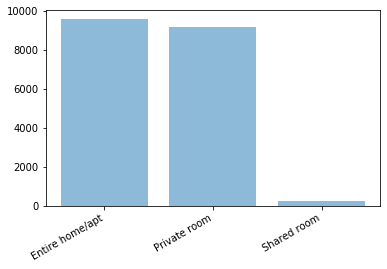

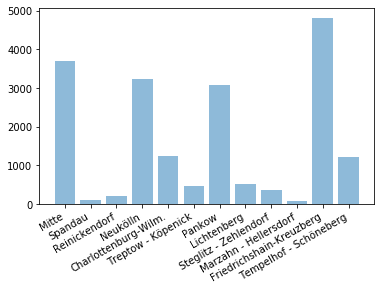

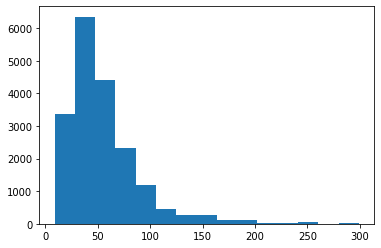

listings-2017-01 4155


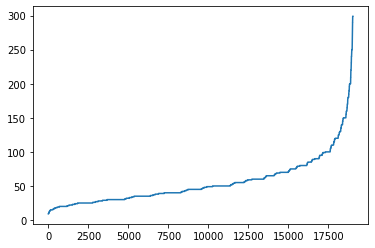

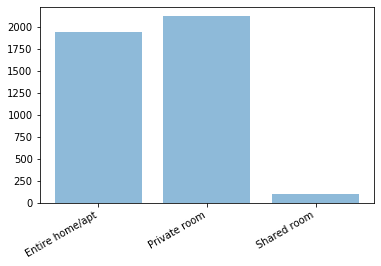

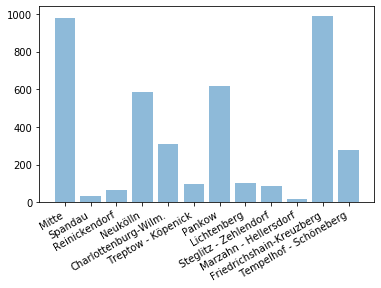

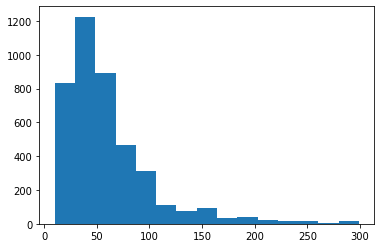

listings-2017-01 14877


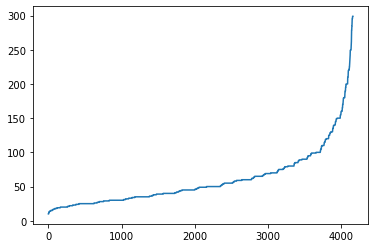

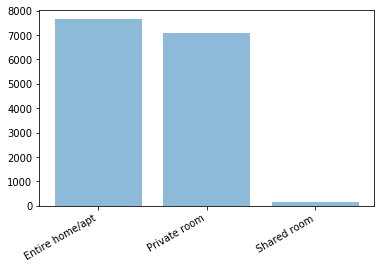

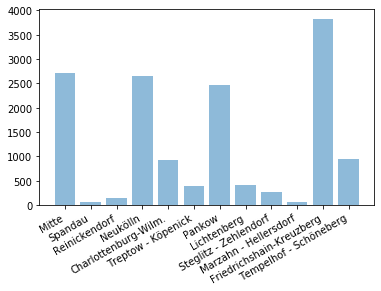

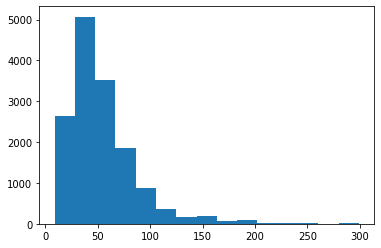

listings-2017-02 19155


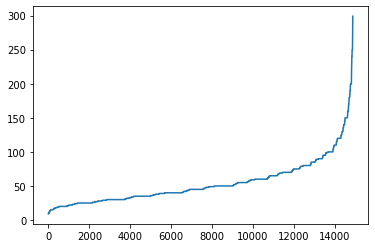

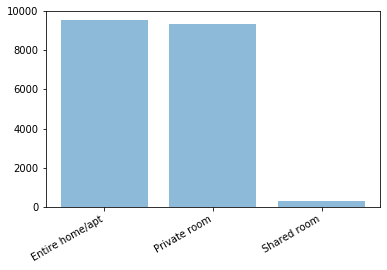

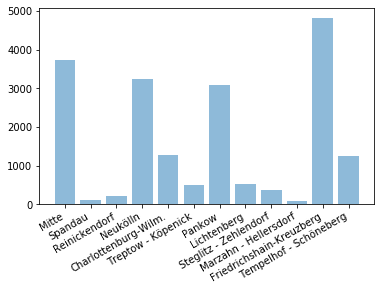

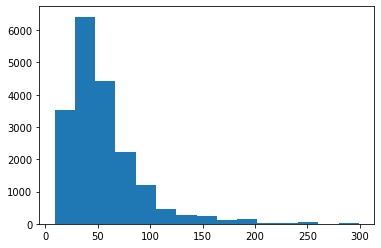

listings-2017-02 4126


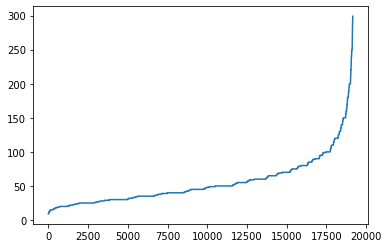

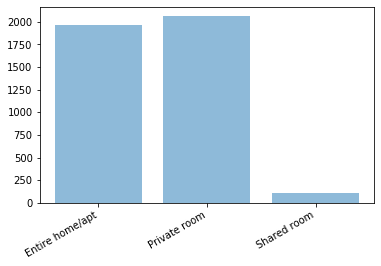

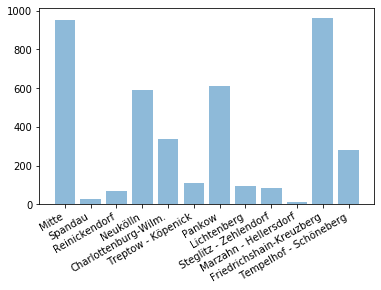

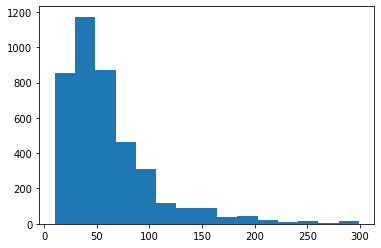

listings-2017-02 15029


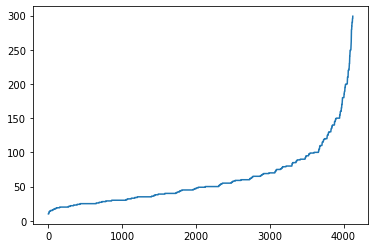

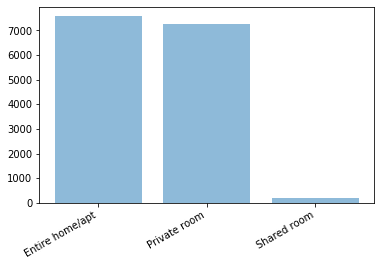

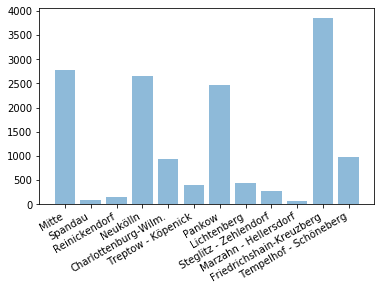

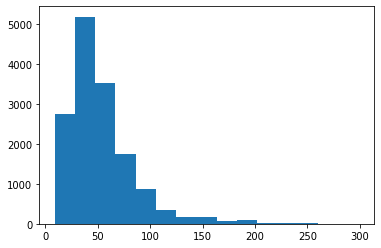

listings-2017-03 19662


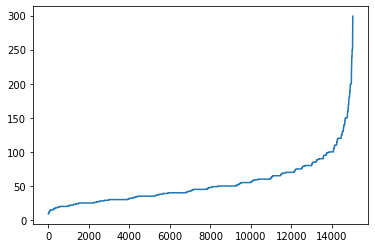

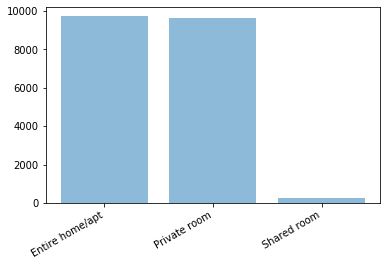

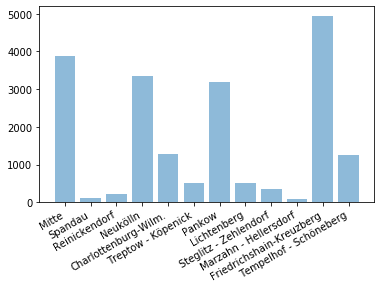

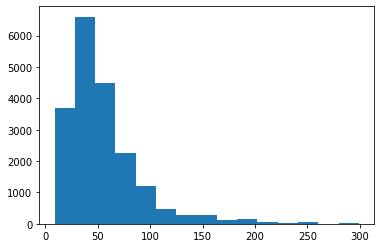

listings-2017-03 4187


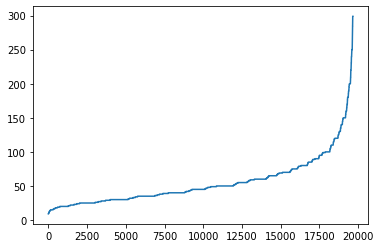

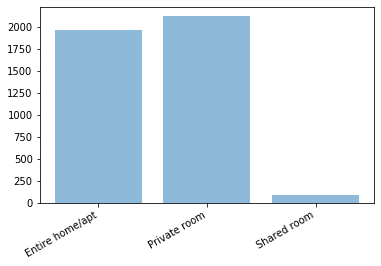

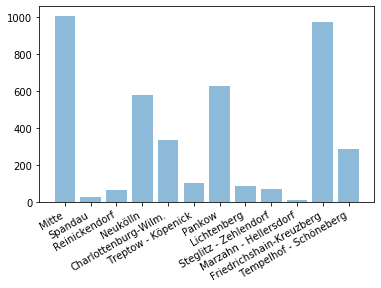

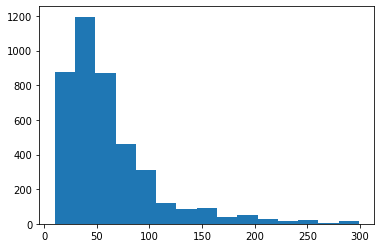

listings-2017-03 15475


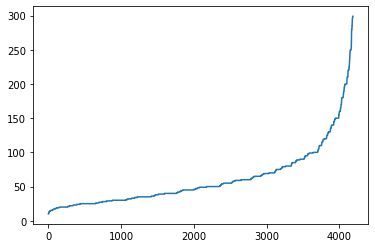

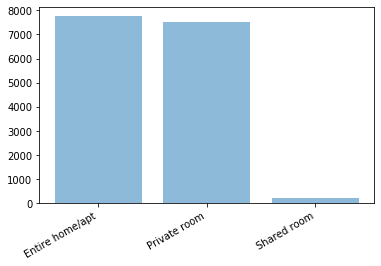

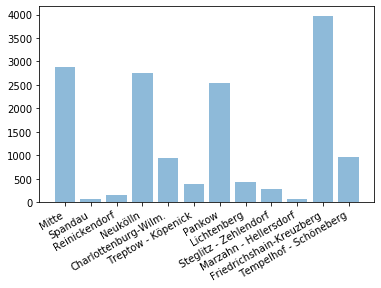

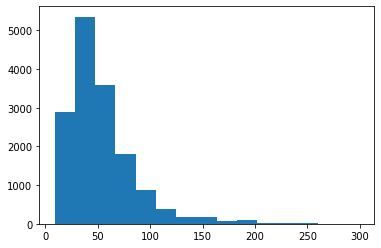

listings-2017-04 20014


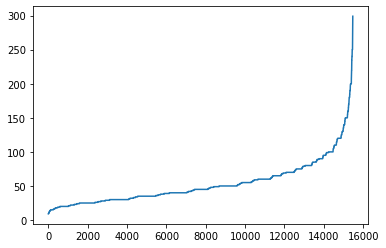

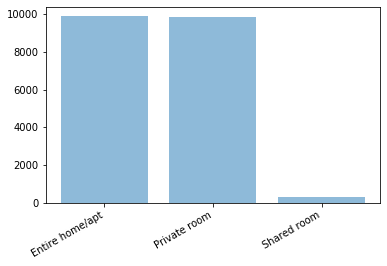

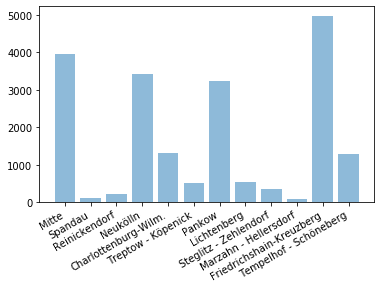

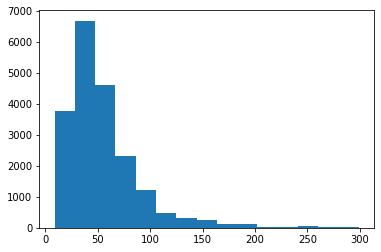

listings-2017-04 4277


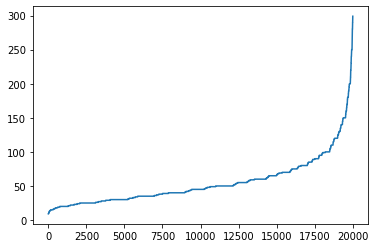

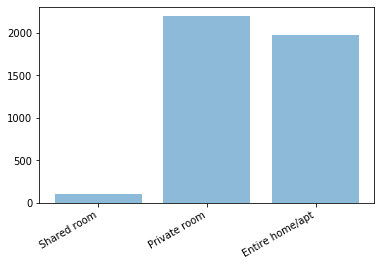

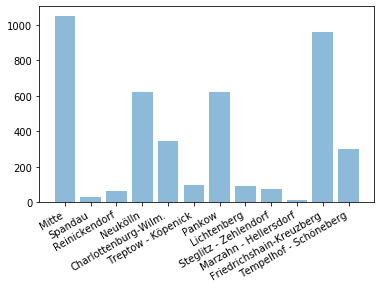

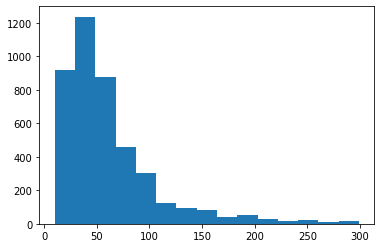

listings-2017-04 15737


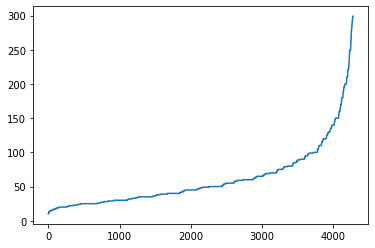

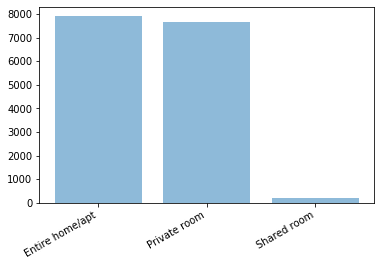

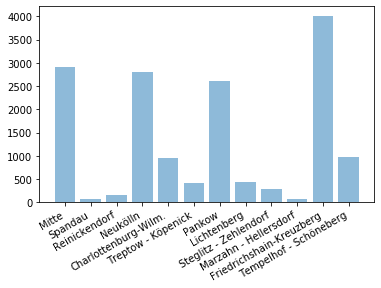

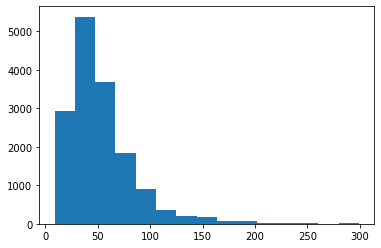

listings-2017-05 20466


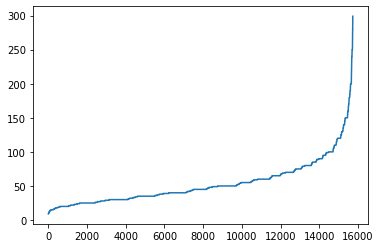

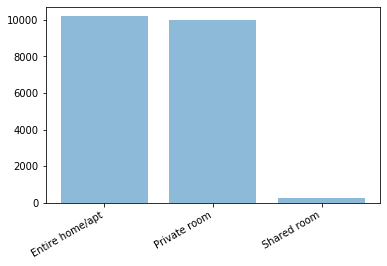

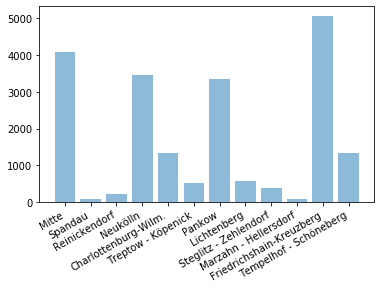

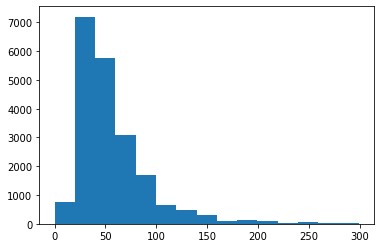

listings-2017-05 4446


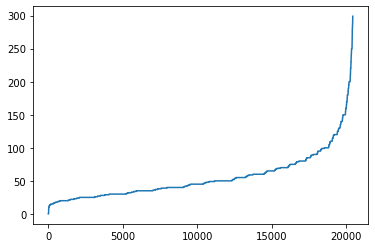

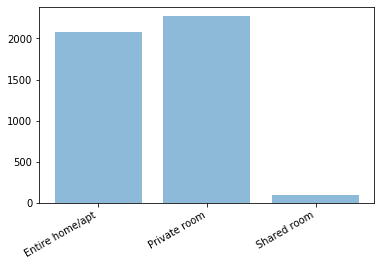

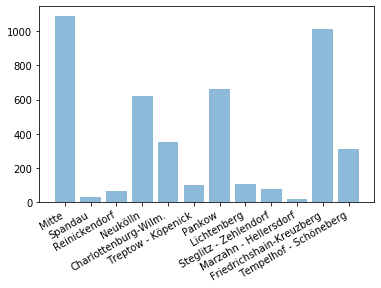

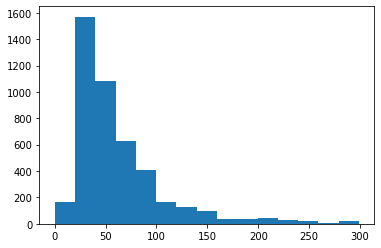

listings-2017-05 16020


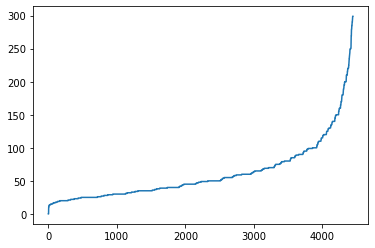

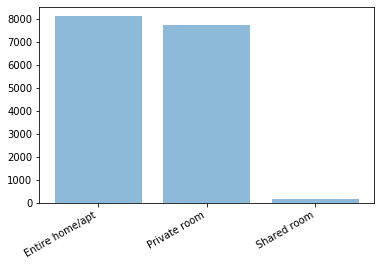

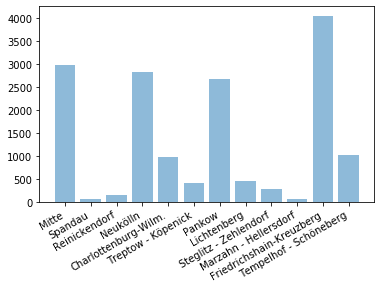

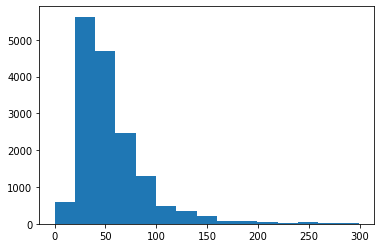

listings-2018-04 26538


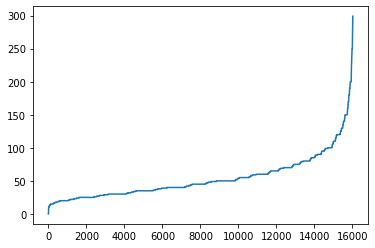

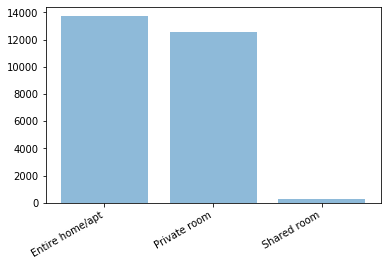

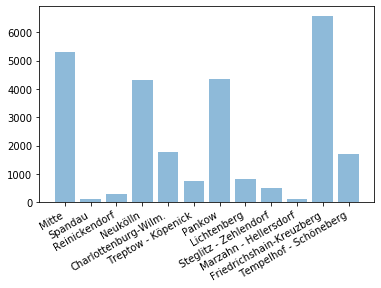

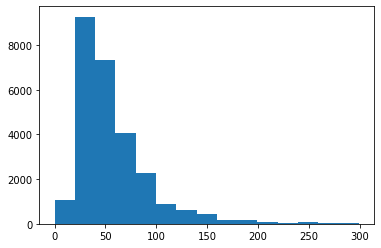

listings-2018-04 5861


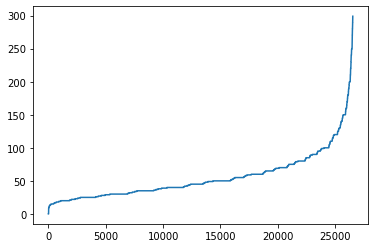

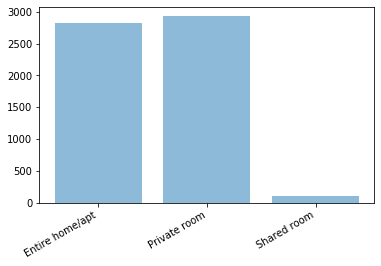

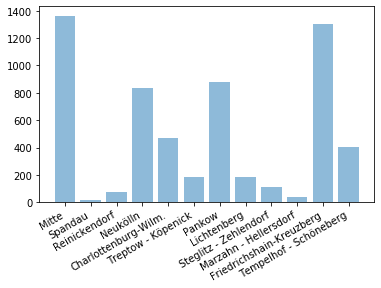

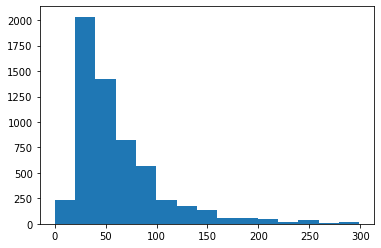

listings-2018-04 20677


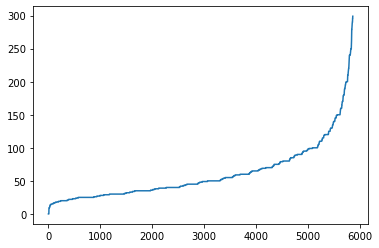

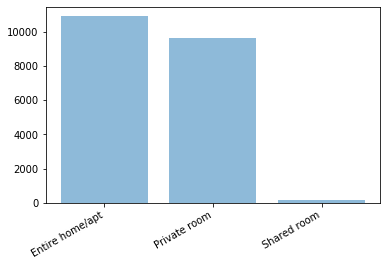

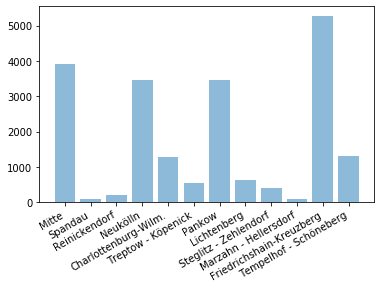

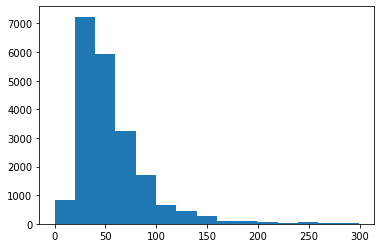

listings-2018-05 25860


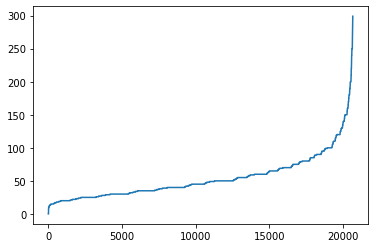

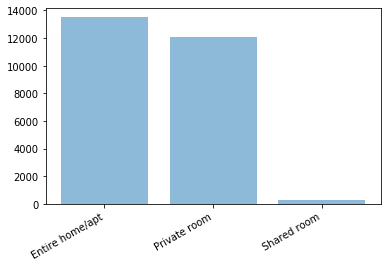

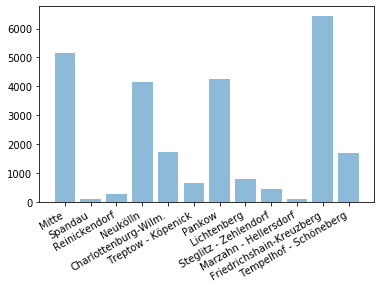

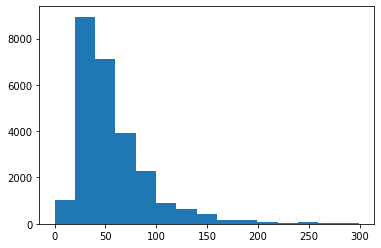

listings-2018-05 5658


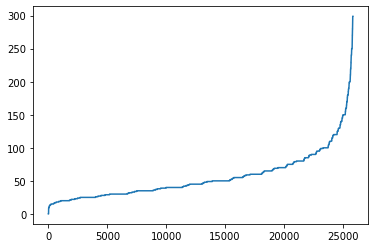

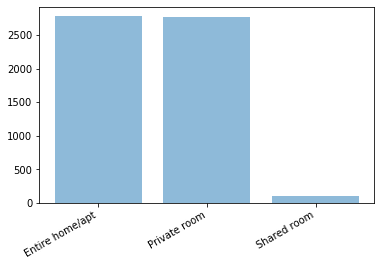

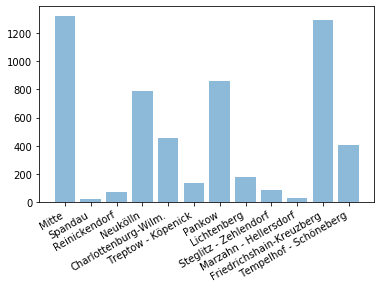

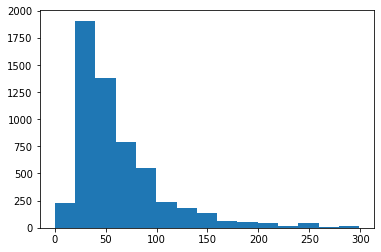

listings-2018-05 20202


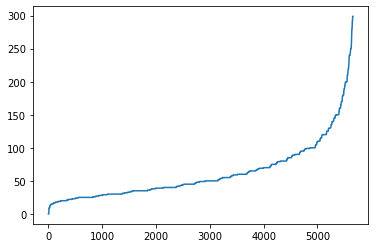

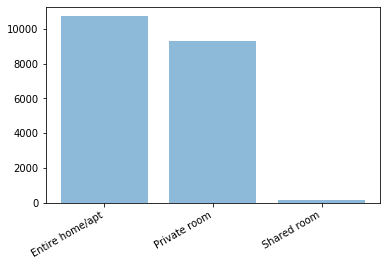

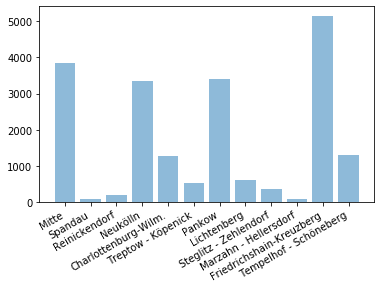

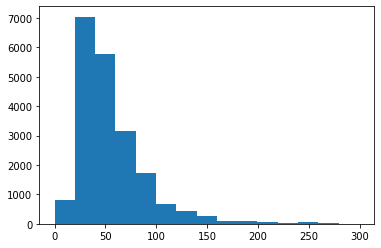

listings-2018-06 26112


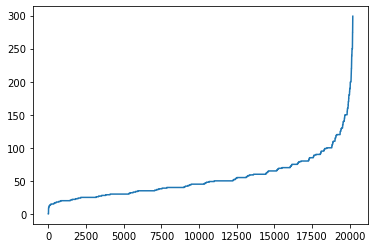

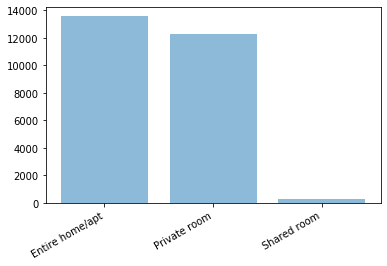

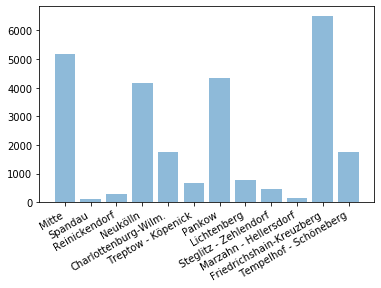

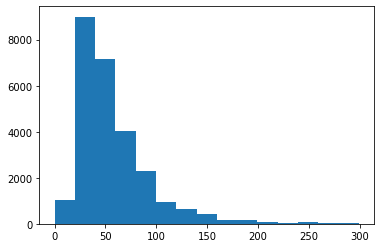

listings-2018-06 5791


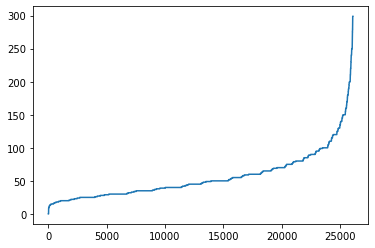

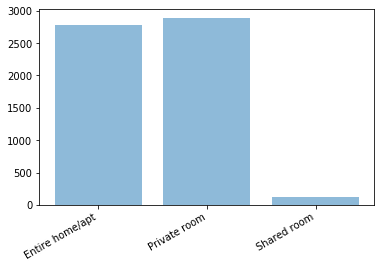

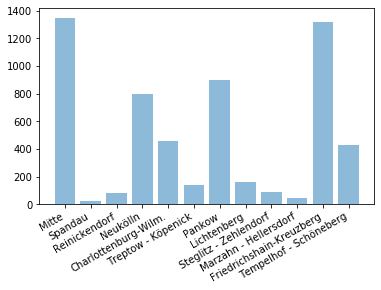

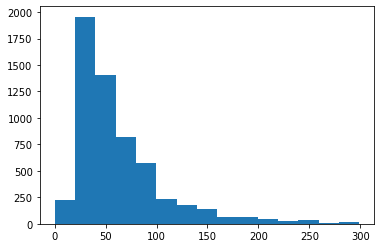

listings-2018-06 20321


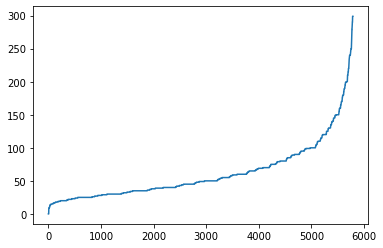

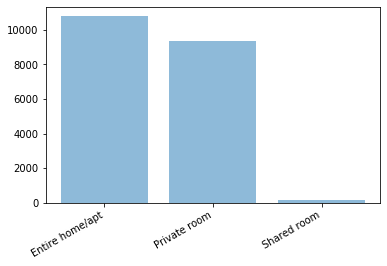

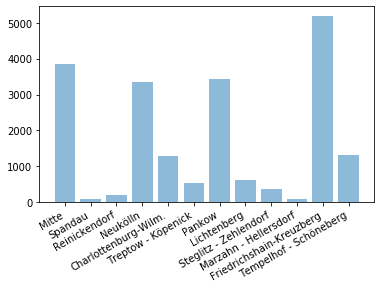

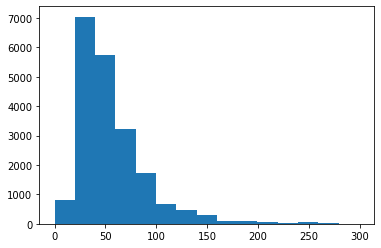

listings-2018-07 26135


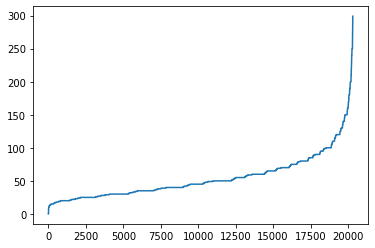

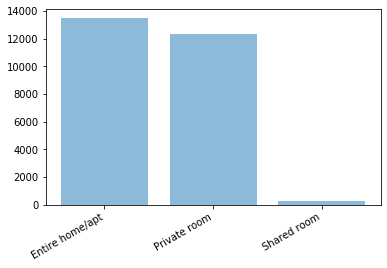

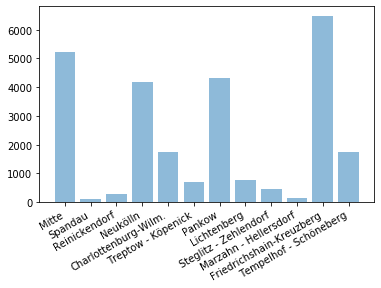

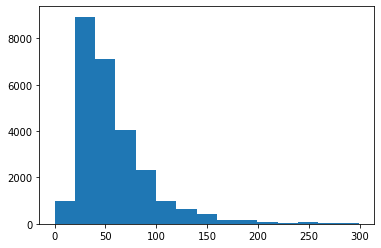

listings-2018-07 5772


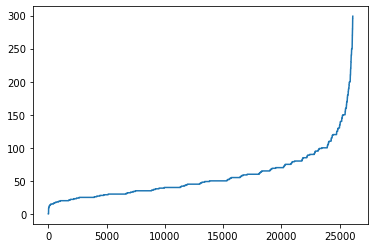

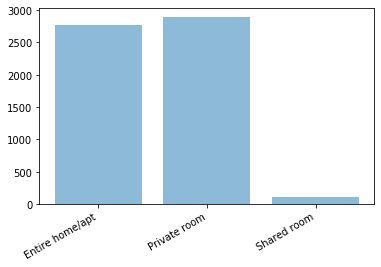

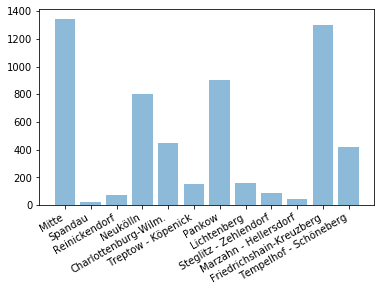

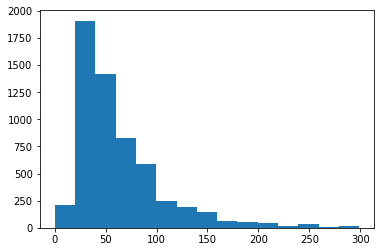

listings-2018-07 20363


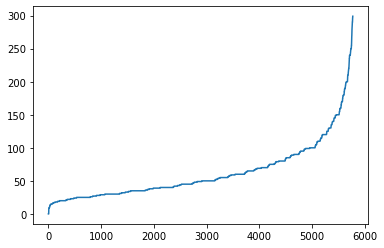

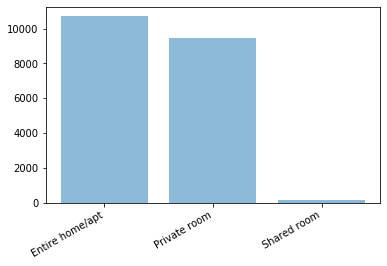

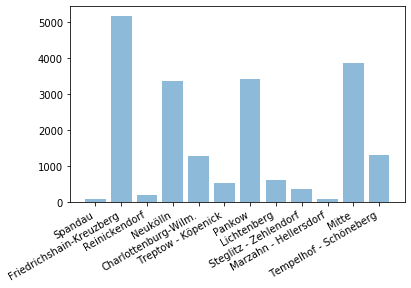

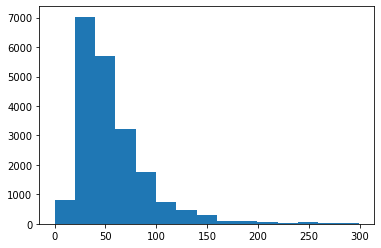

listings-2018-08 22893


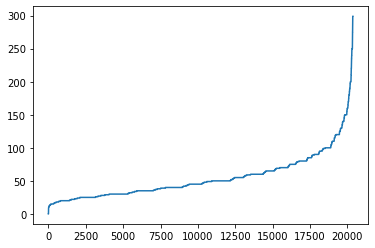

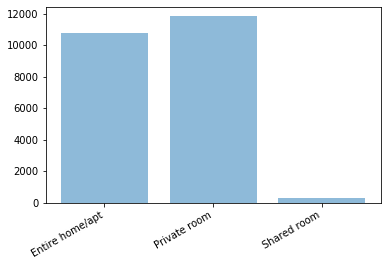

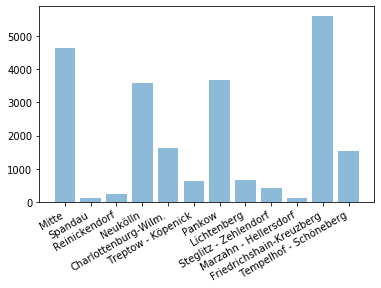

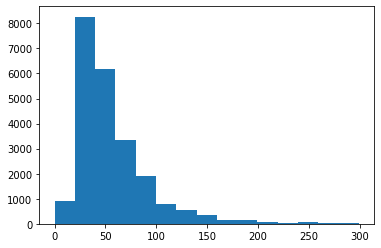

listings-2018-08 5379


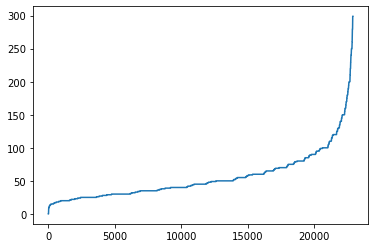

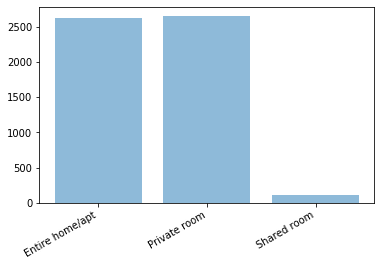

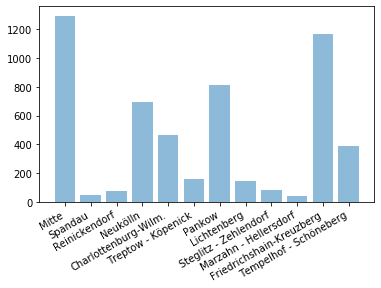

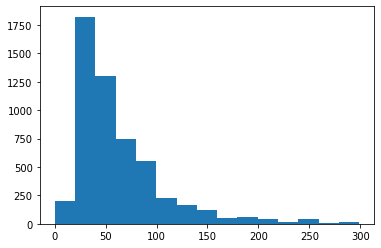

listings-2018-08 17514


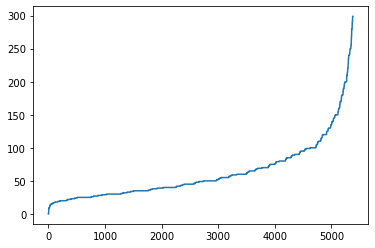

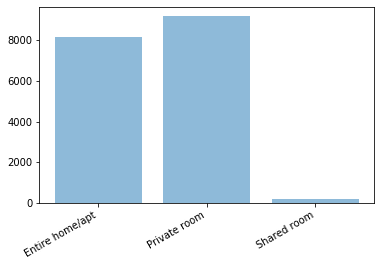

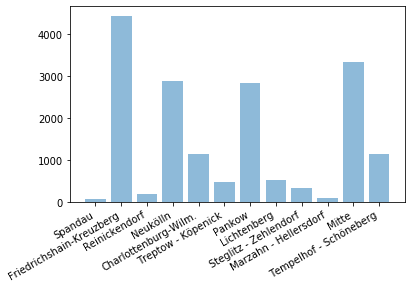

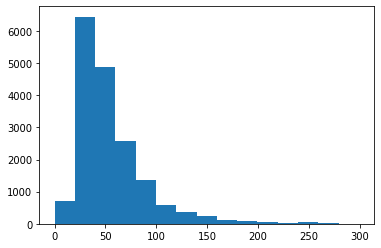

listings-2018-09 22403


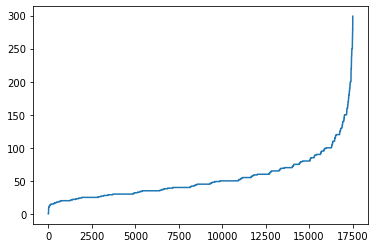

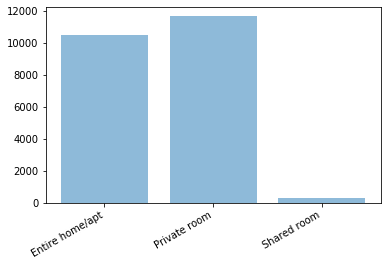

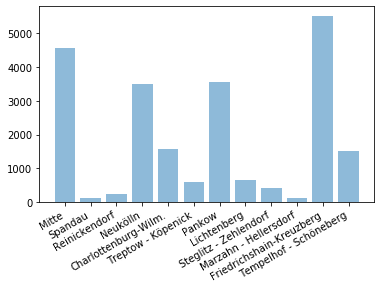

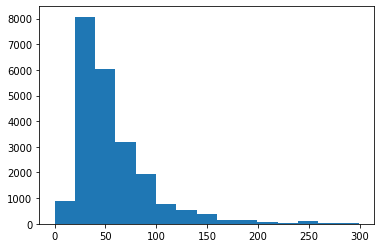

listings-2018-09 5178


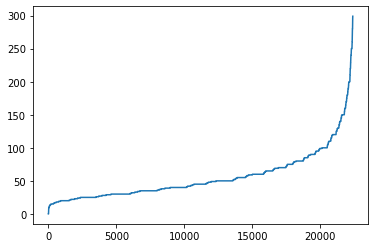

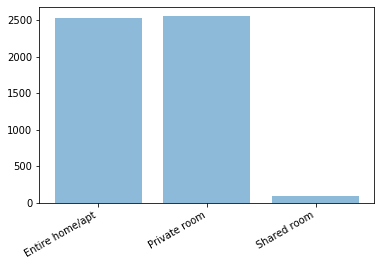

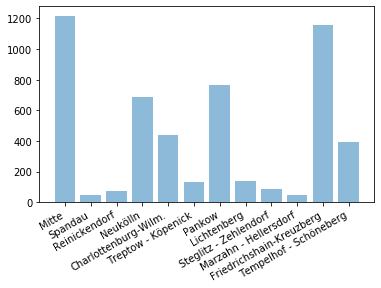

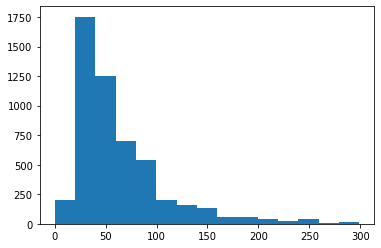

listings-2018-09 17225


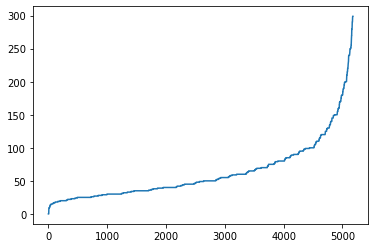

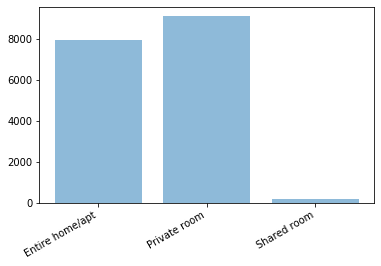

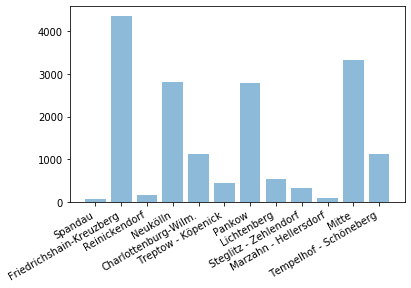

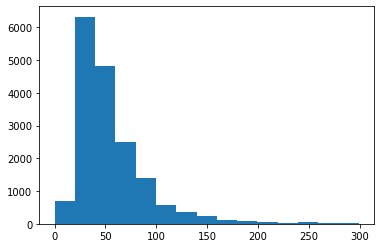

listings-2018-10 22077


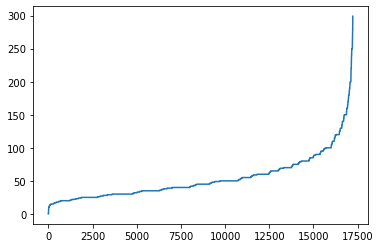

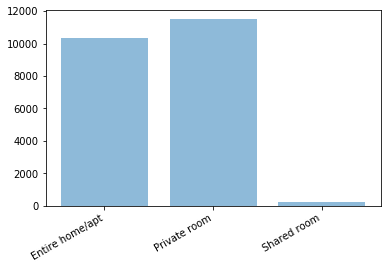

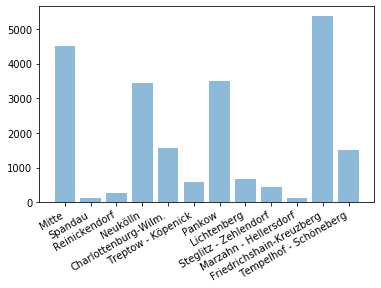

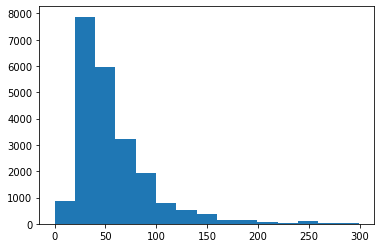

listings-2018-10 5065


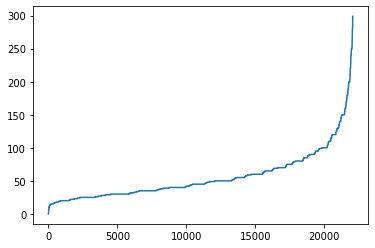

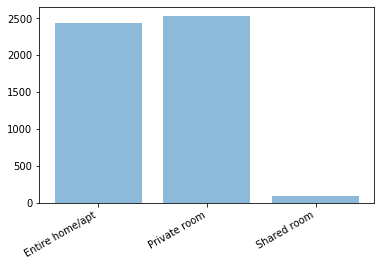

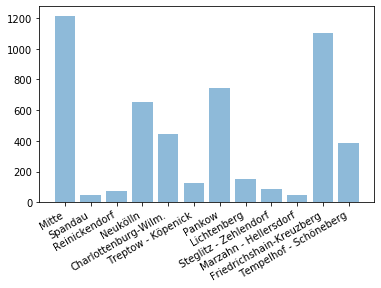

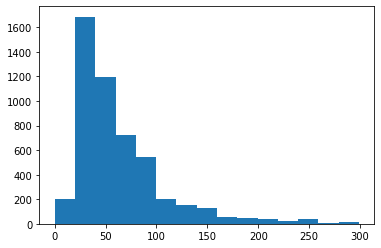

listings-2018-10 17012


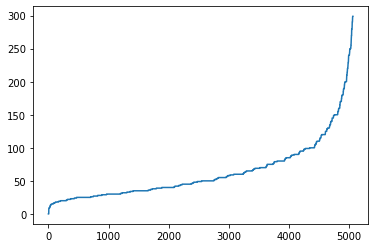

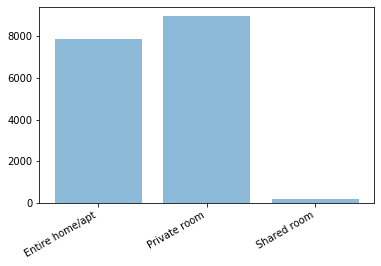

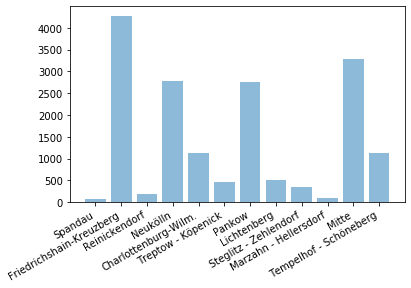

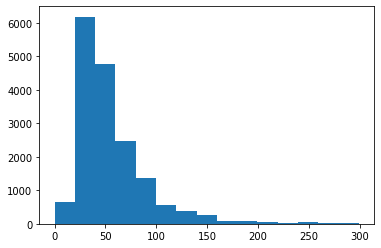

listings-2018-11 22362


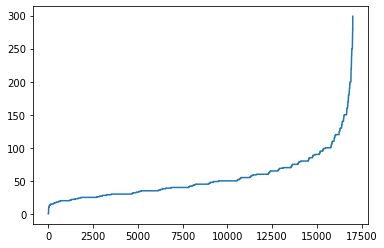

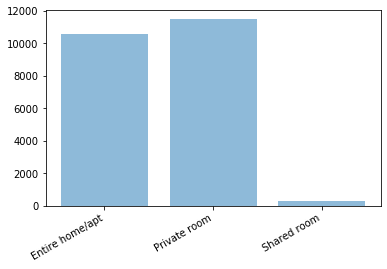

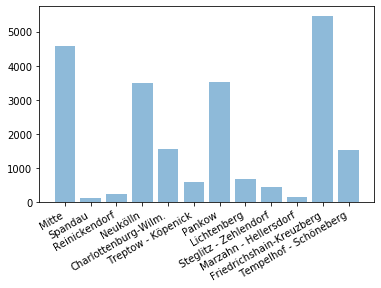

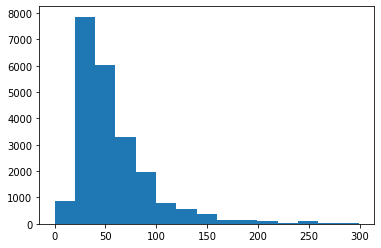

listings-2018-11 5205


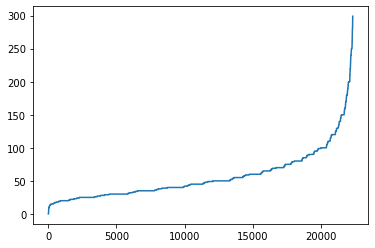

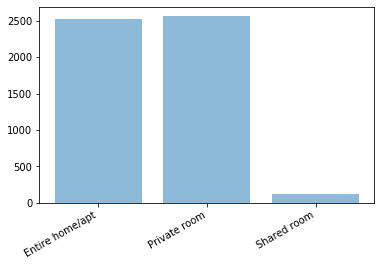

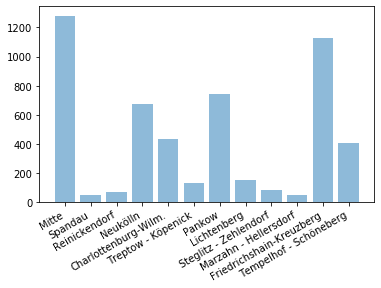

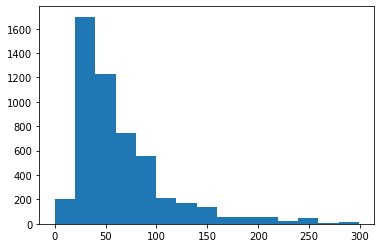

listings-2018-11 17157


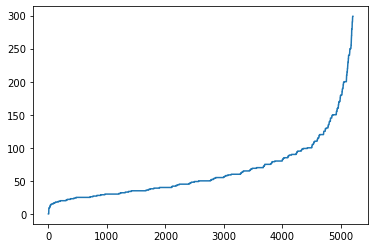

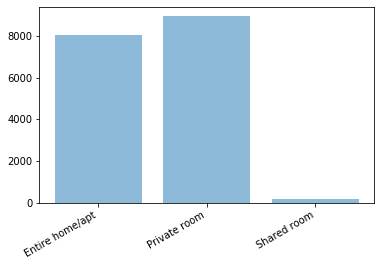

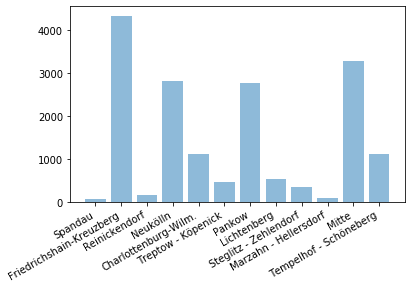

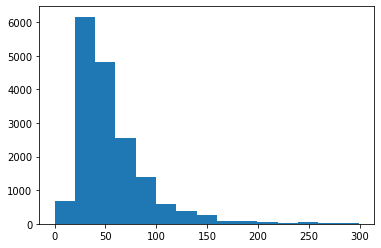

listings-2018-12 23044


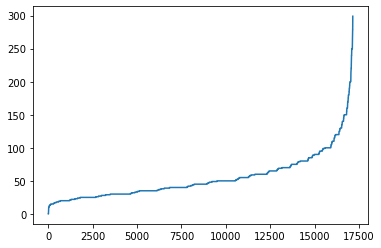

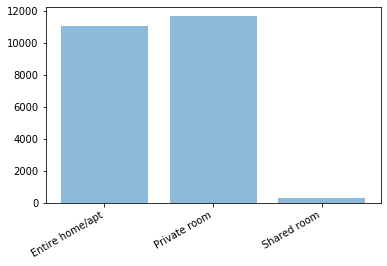

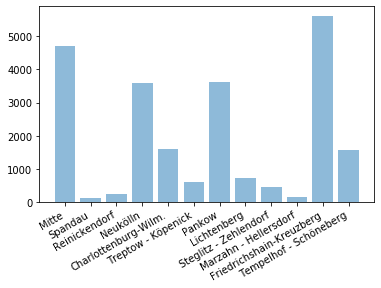

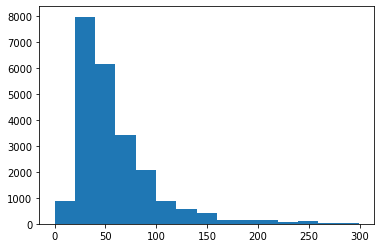

listings-2018-12 5495


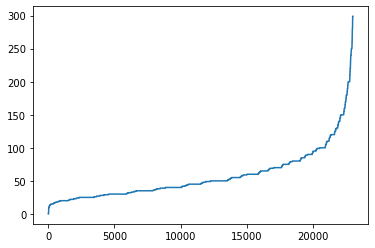

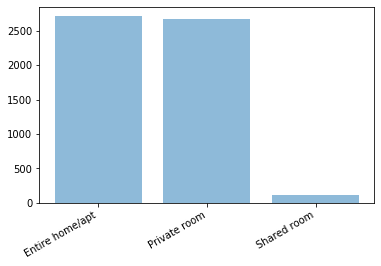

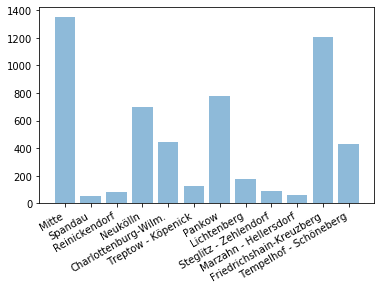

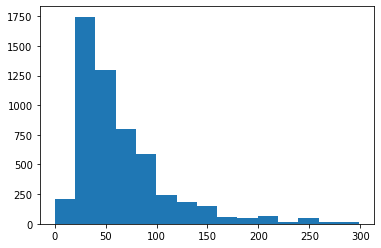

listings-2018-12 17549


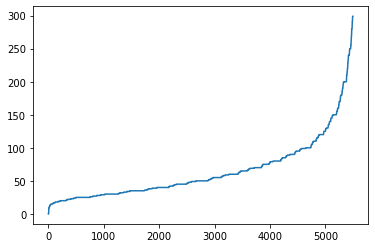

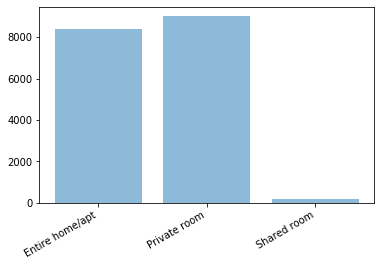

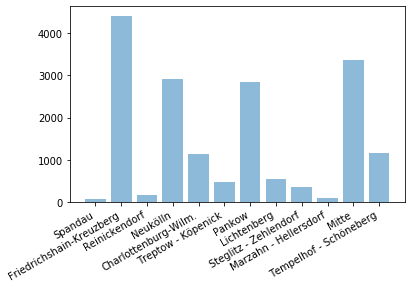

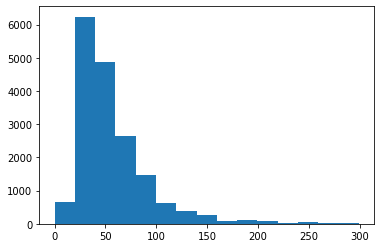

listings-2019-01 23282


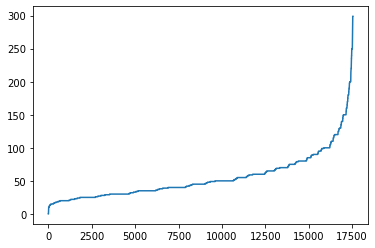

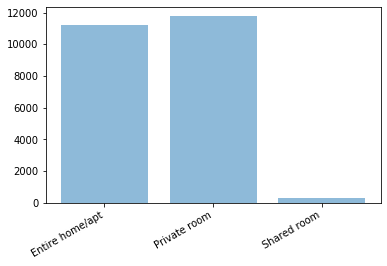

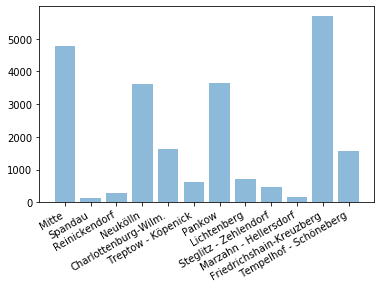

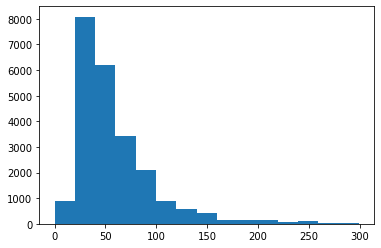

listings-2019-01 5636


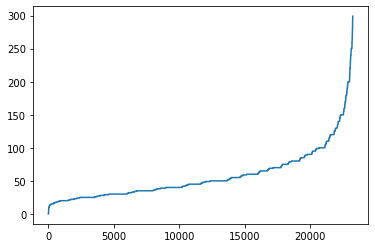

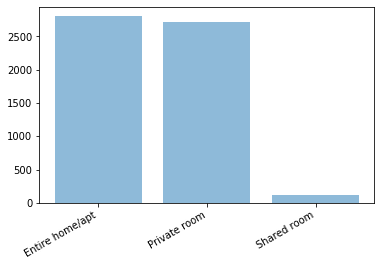

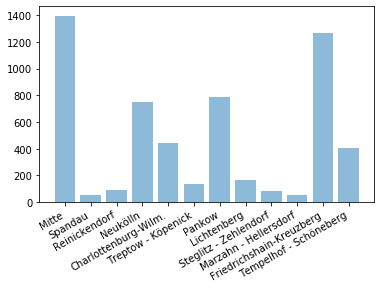

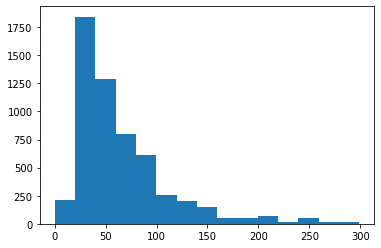

listings-2019-01 17646


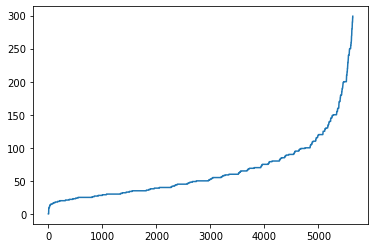

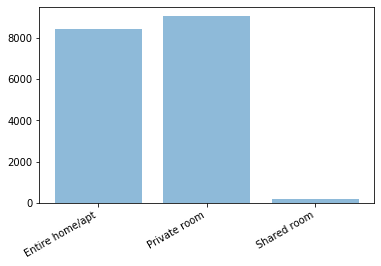

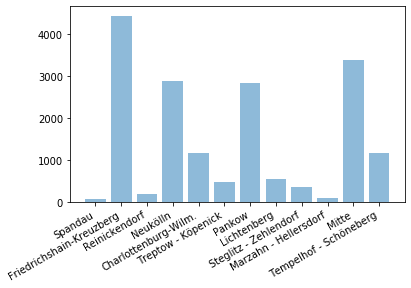

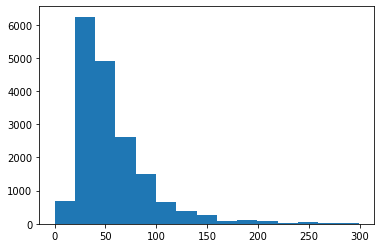

listings-2019-02 23324


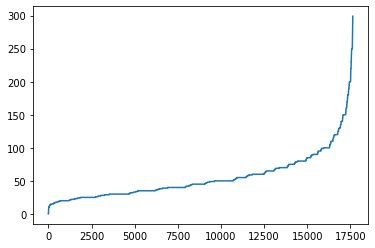

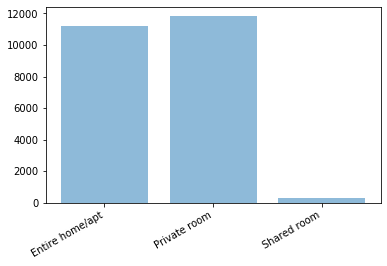

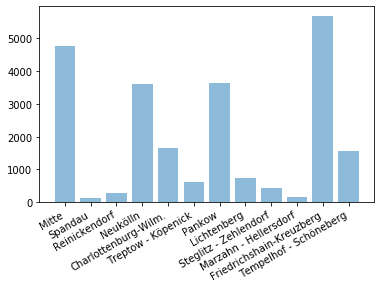

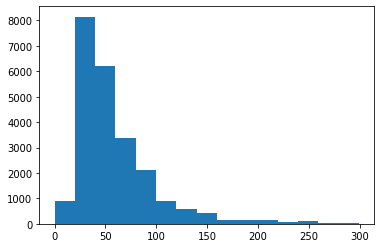

listings-2019-02 5689


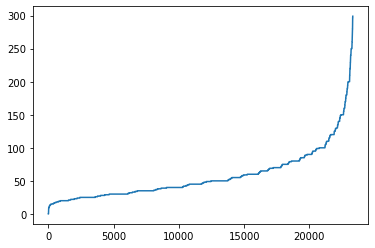

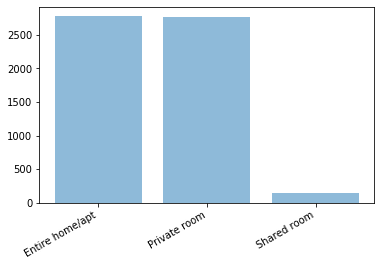

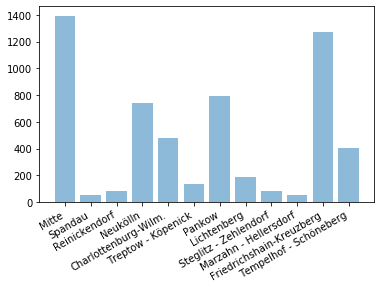

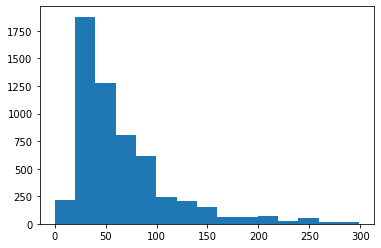

listings-2019-02 17635


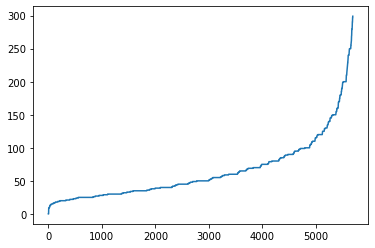

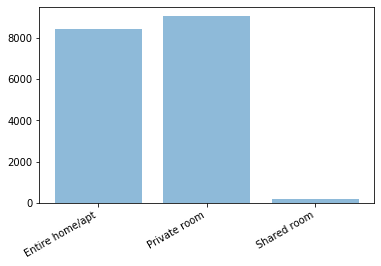

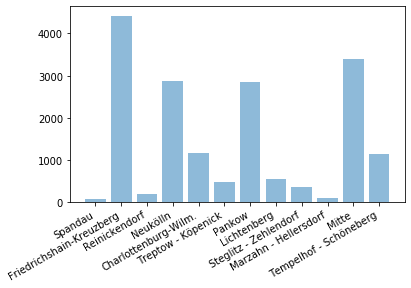

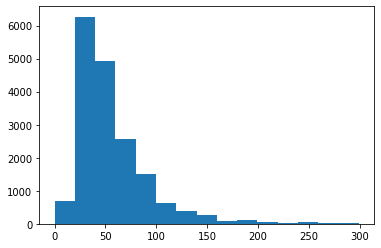

listings-2019-03 23389


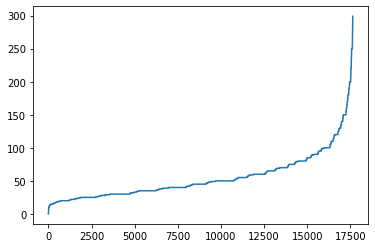

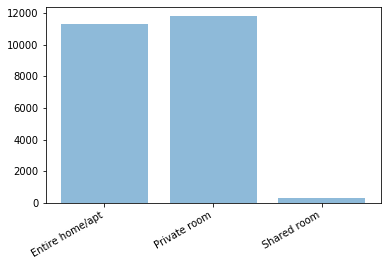

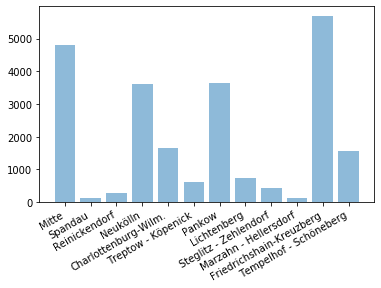

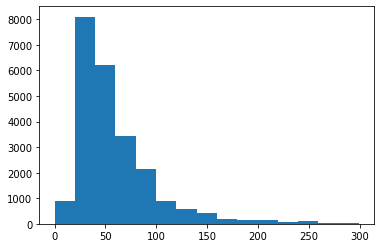

listings-2019-03 5692


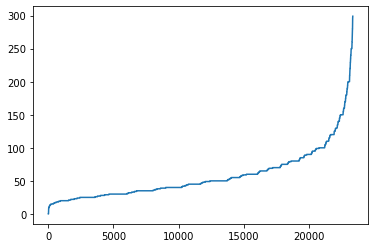

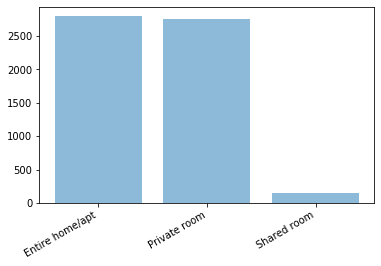

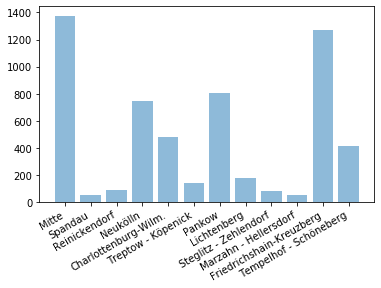

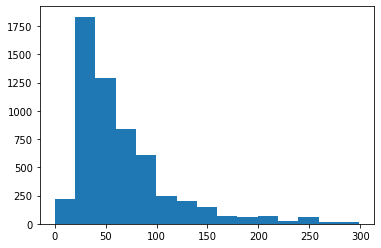

listings-2019-03 17697


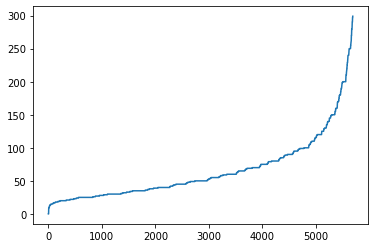

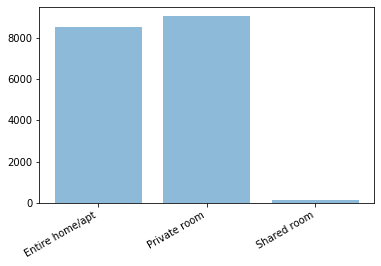

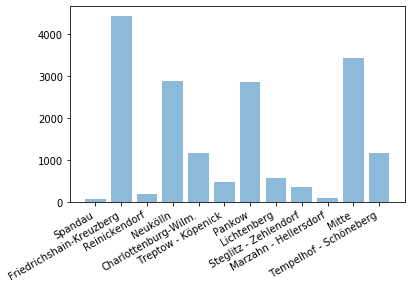

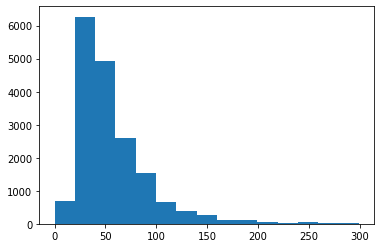

listings-2019-04 23298


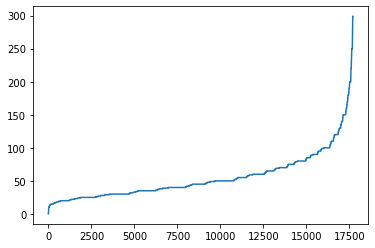

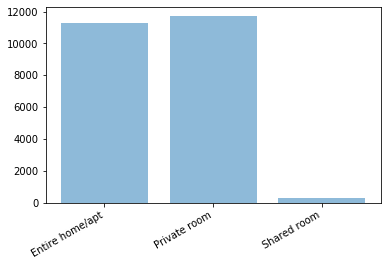

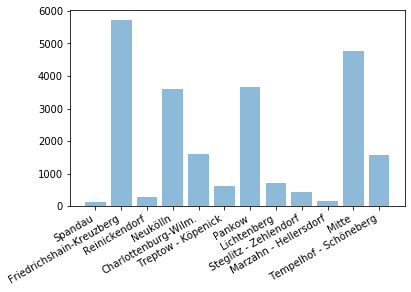

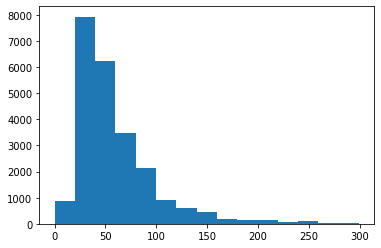

listings-2019-04 5639


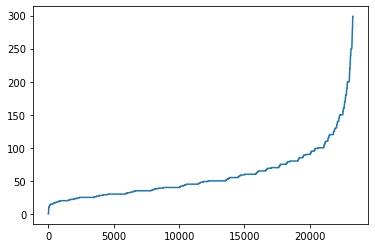

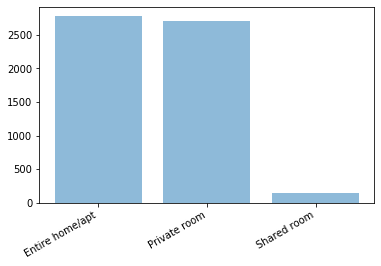

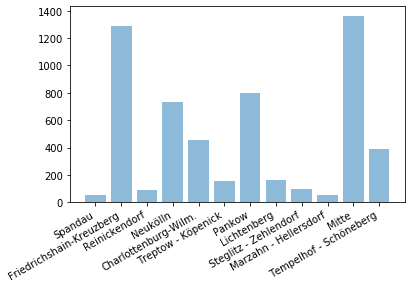

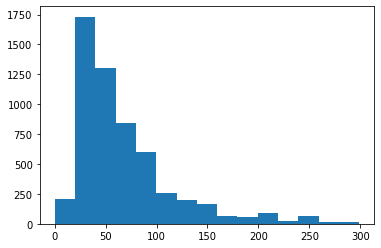

listings-2019-04 17659


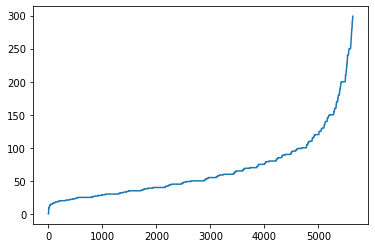

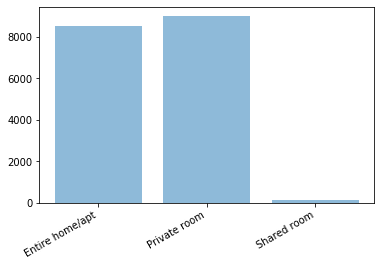

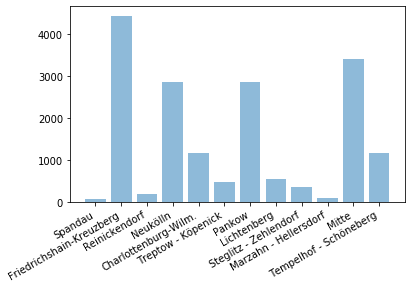

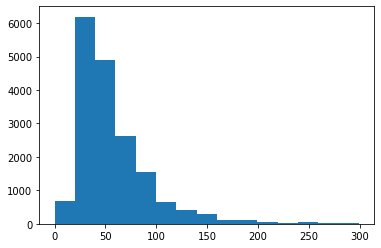

listings-2019-05 23298


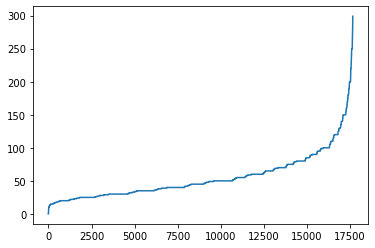

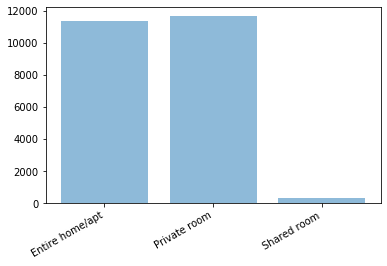

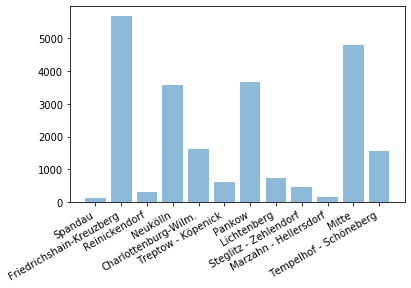

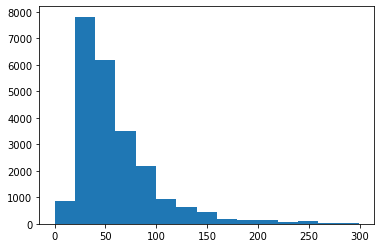

listings-2019-05 5676


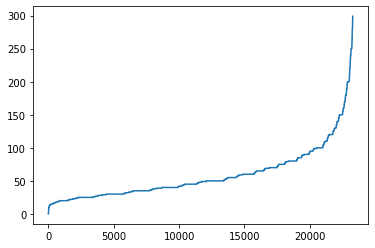

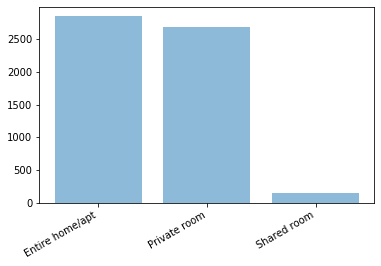

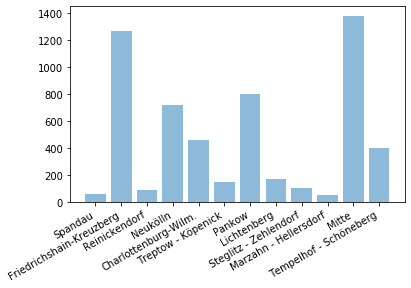

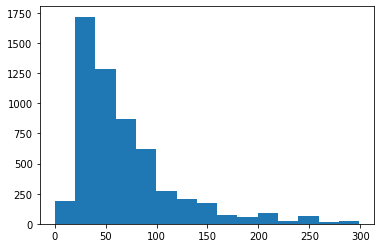

listings-2019-05 17622


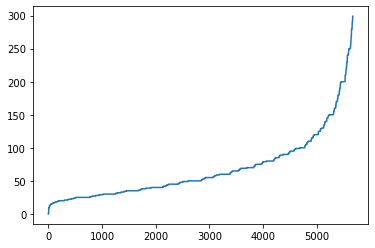

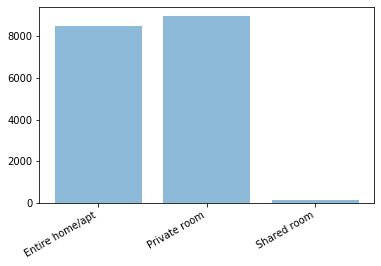

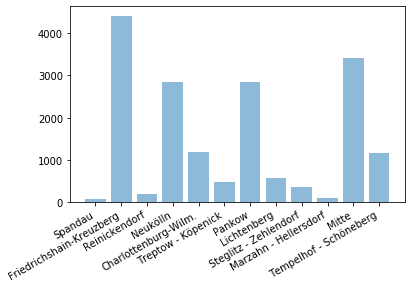

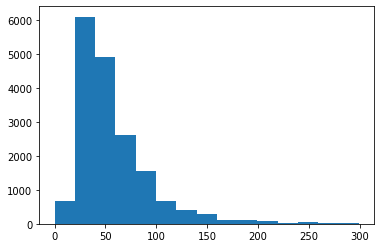

listings-2019-06 23570


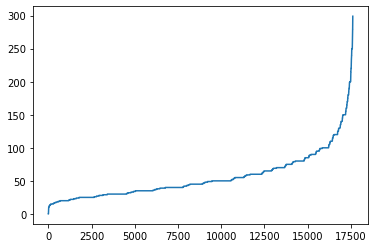

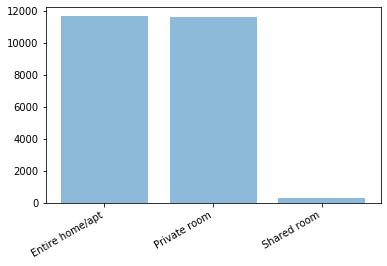

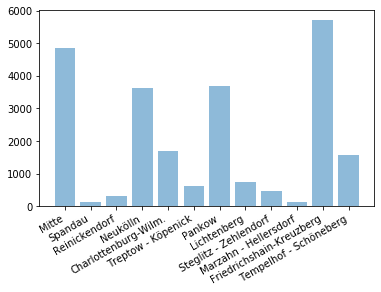

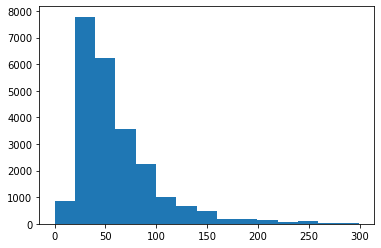

listings-2019-06 5751


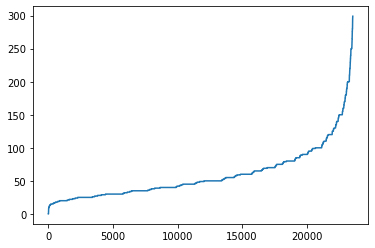

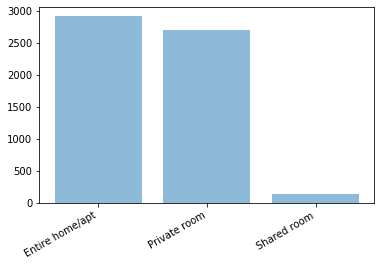

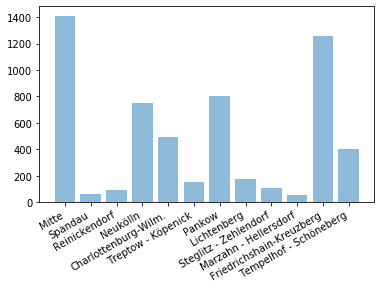

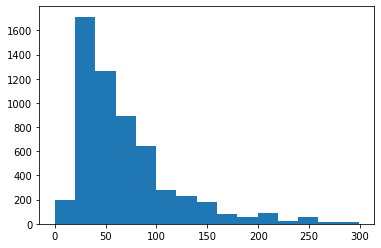

listings-2019-06 17819


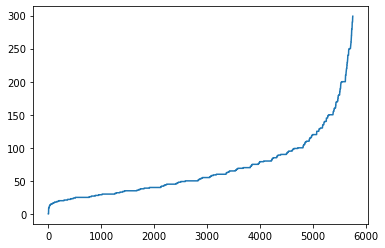

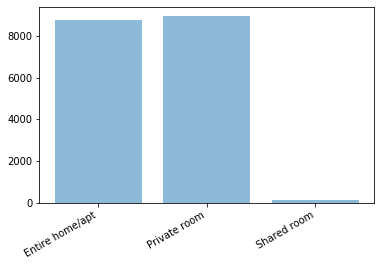

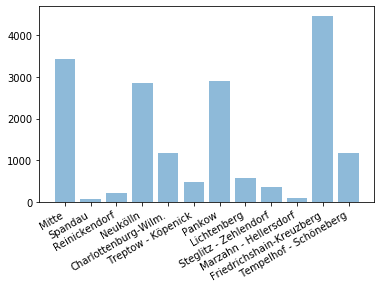

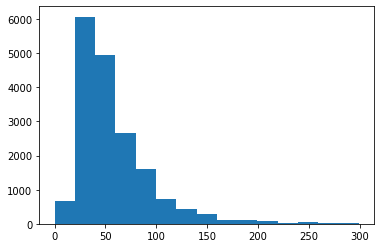

listings-2019-07 24136


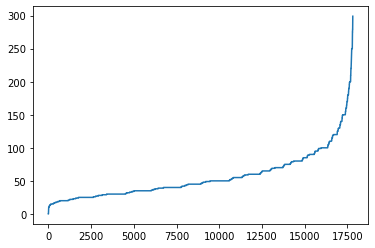

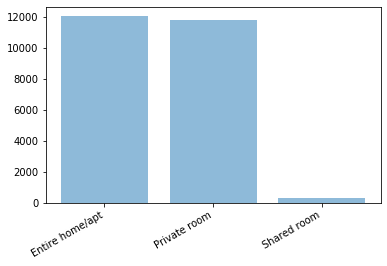

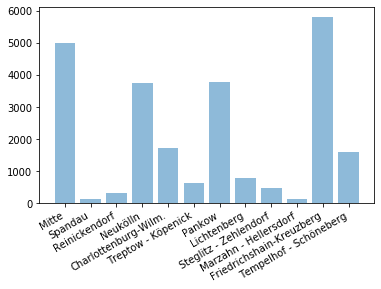

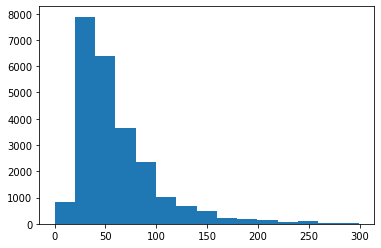

listings-2019-07 5928


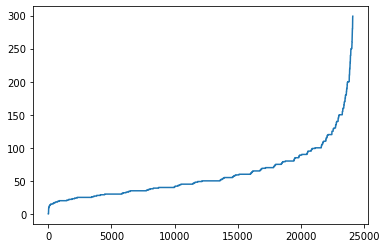

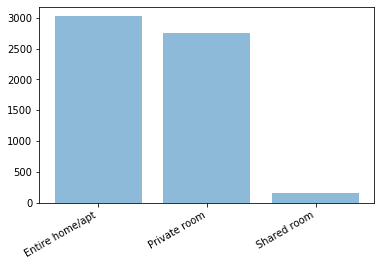

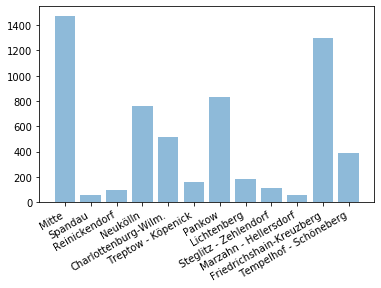

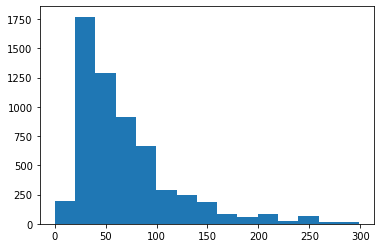

listings-2019-07 18208


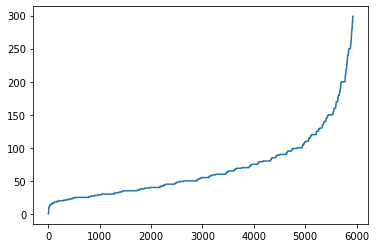

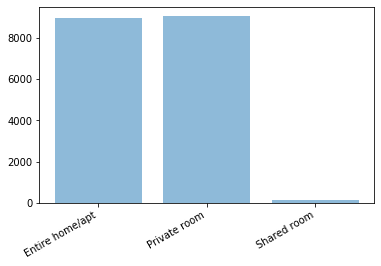

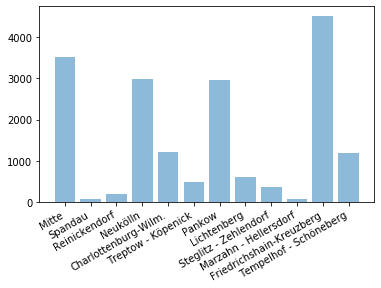

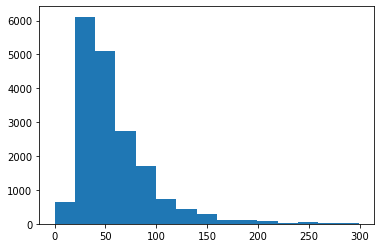

listings-2019-08 24266


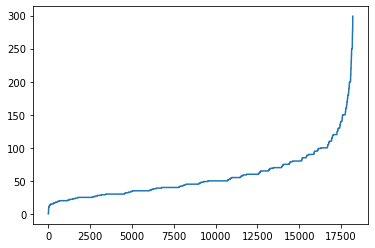

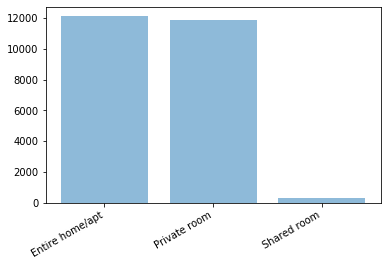

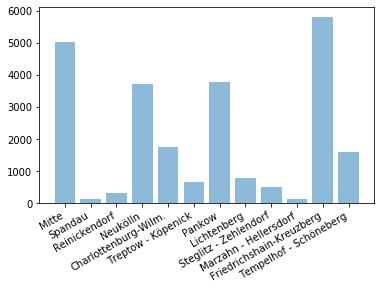

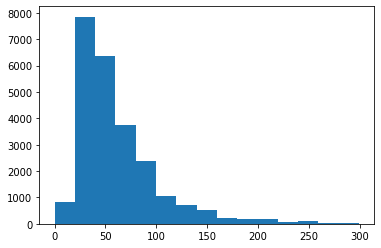

listings-2019-08 5991


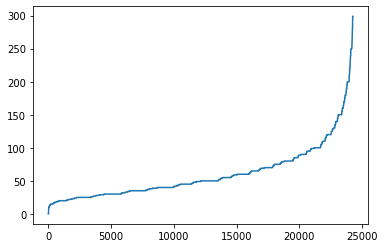

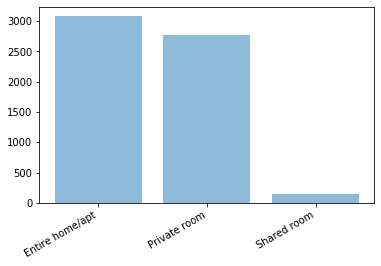

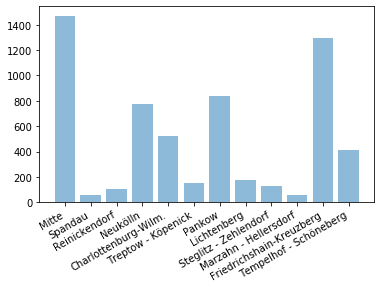

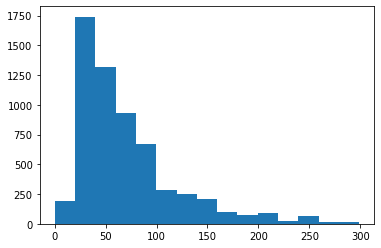

listings-2019-08 18275


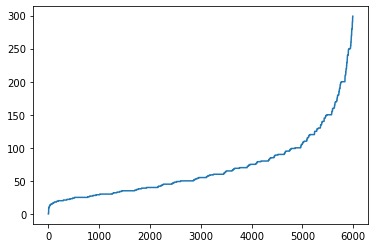

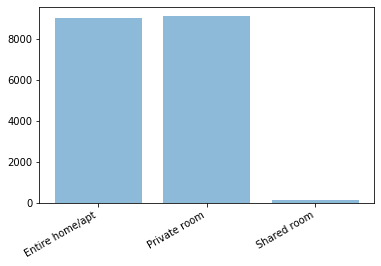

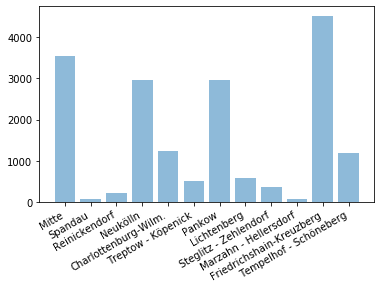

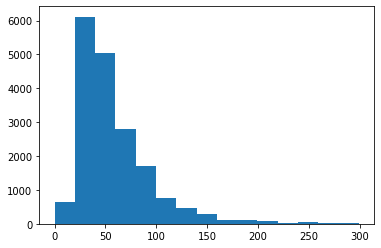

listings-2019-09 24130


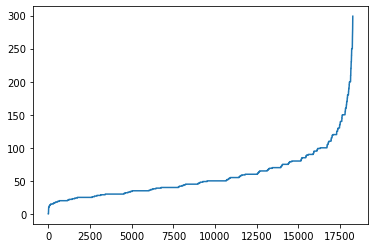

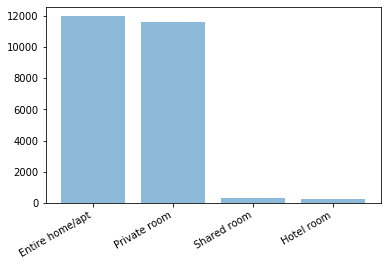

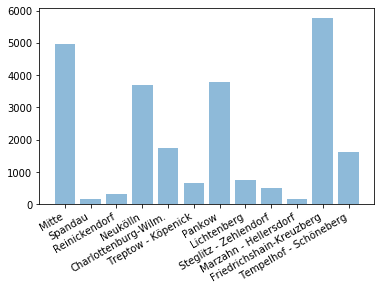

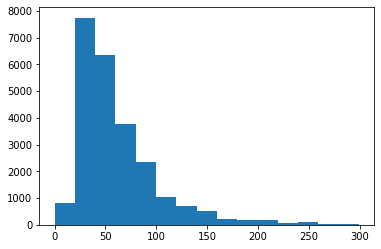

listings-2019-09 5936


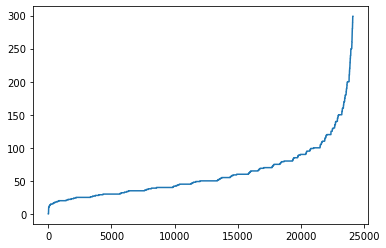

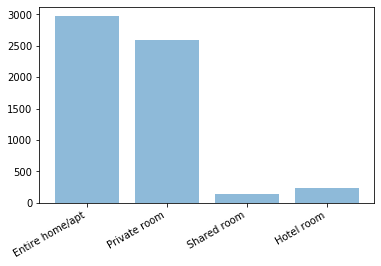

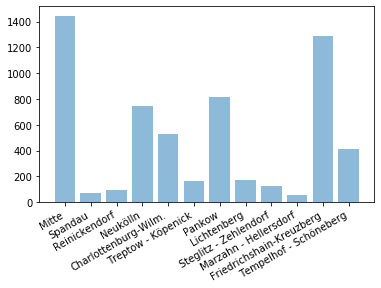

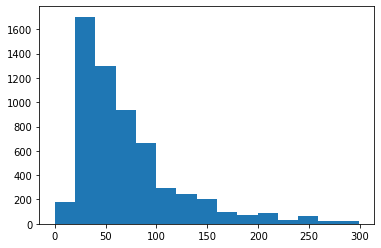

listings-2019-09 18194


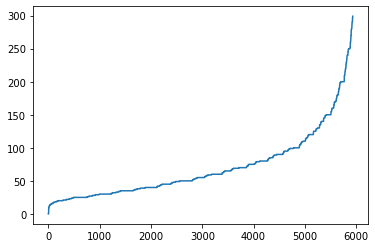

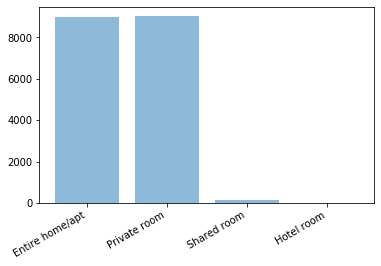

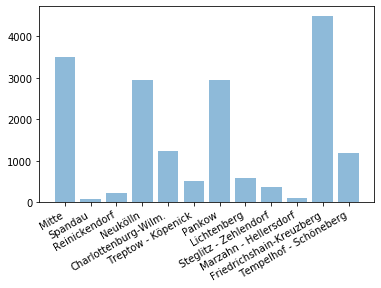

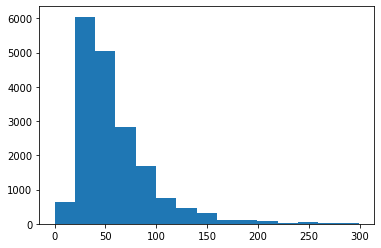

listings-2019-10 24172


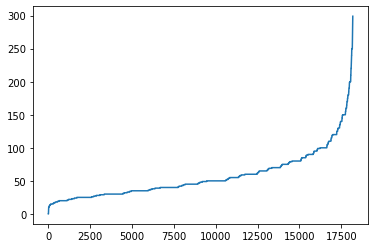

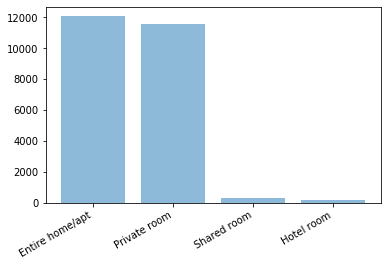

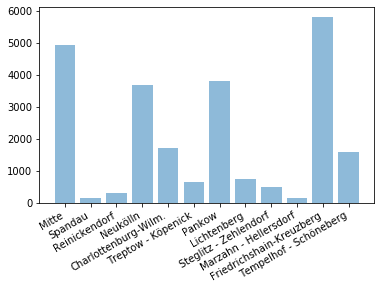

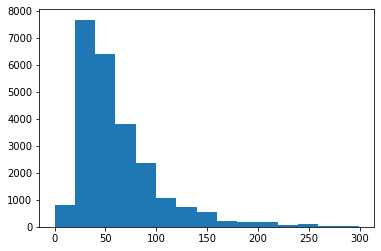

listings-2019-10 5966


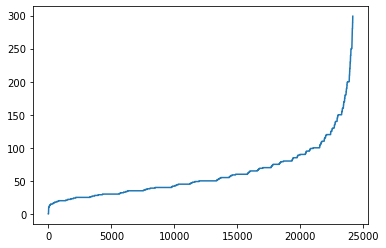

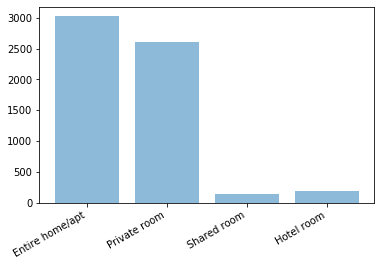

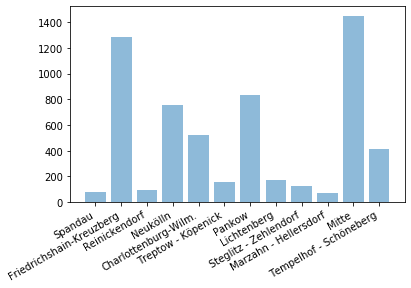

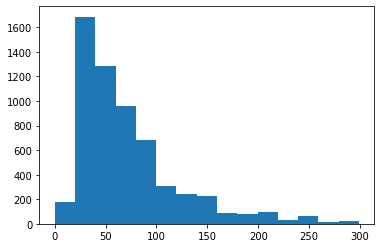

listings-2019-10 18206


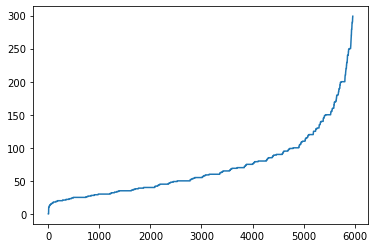

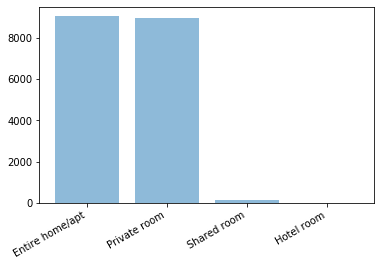

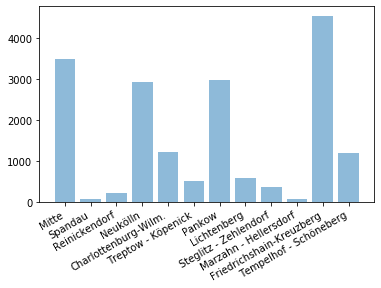

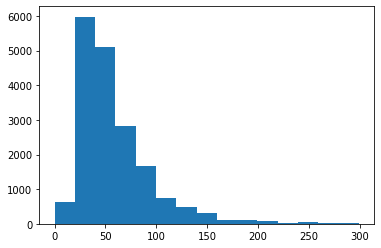

listings-2019-11 24284


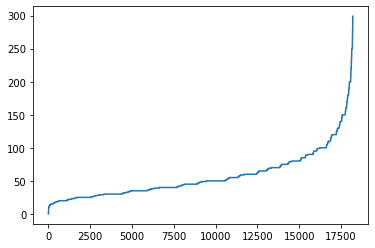

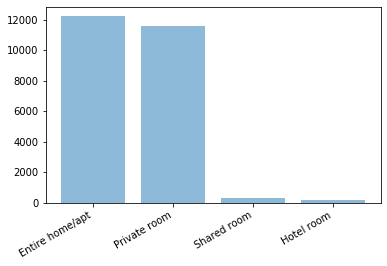

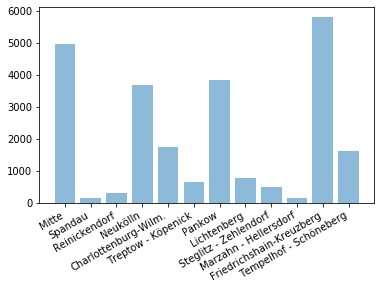

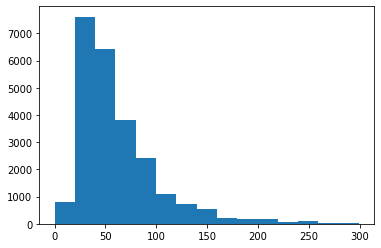

listings-2019-11 6022


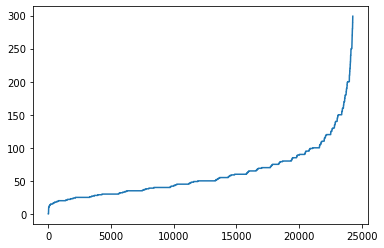

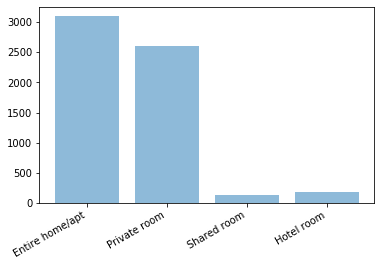

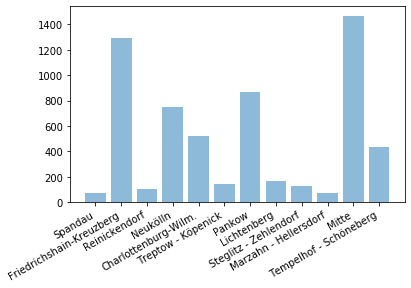

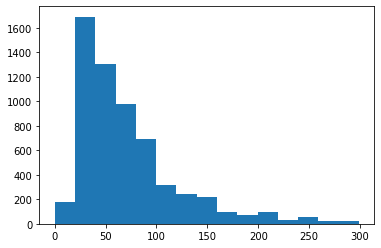

listings-2019-11 18262


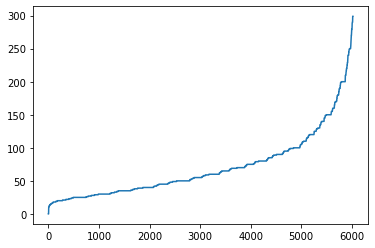

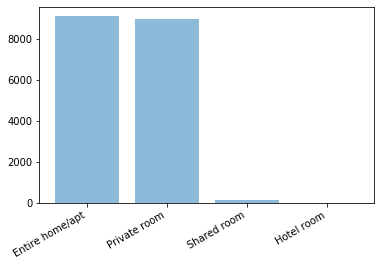

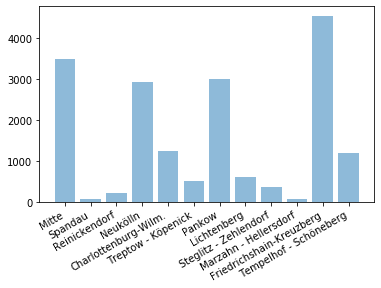

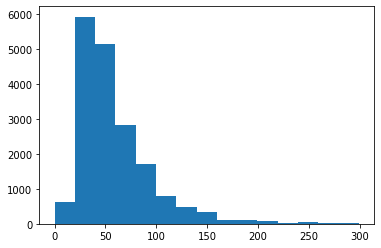

listings-2019-12 24917


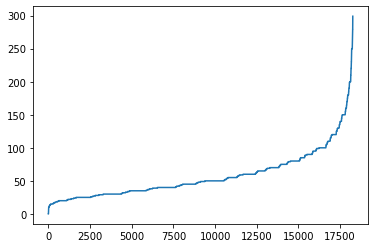

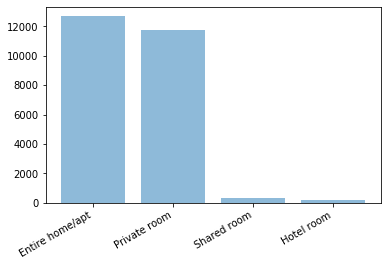

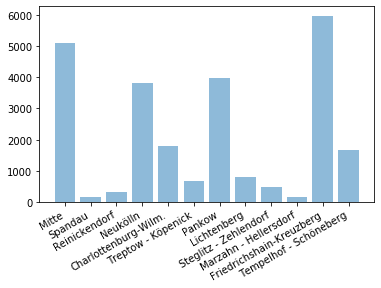

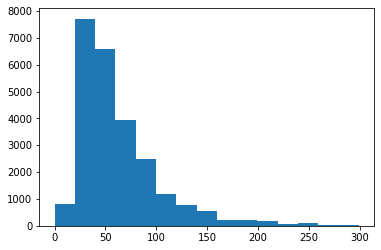

listings-2019-12 6298


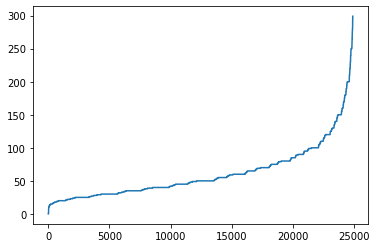

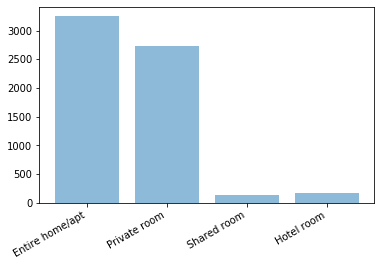

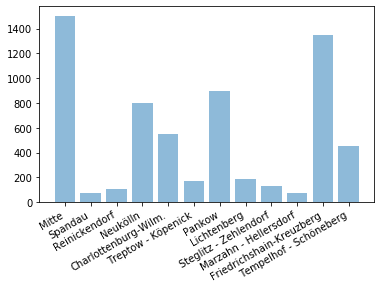

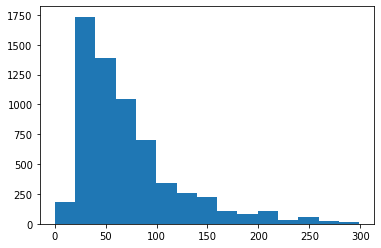

listings-2019-12 18619


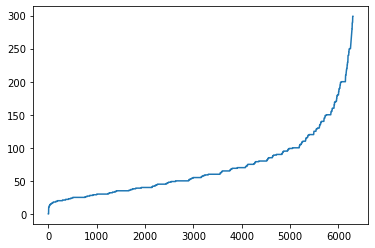

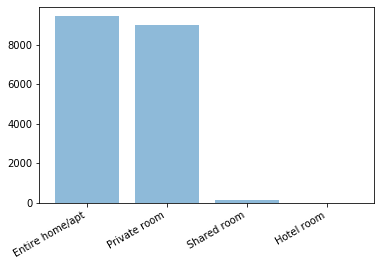

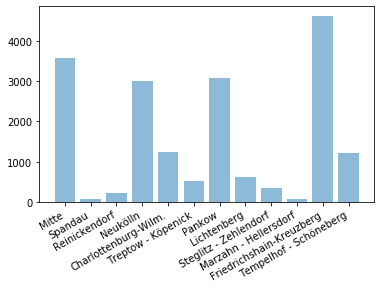

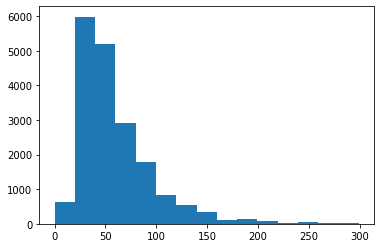

listings-2020-01 25042


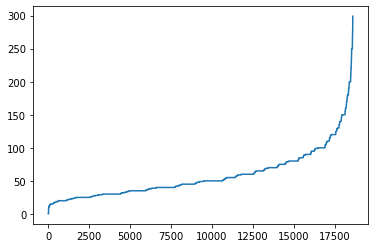

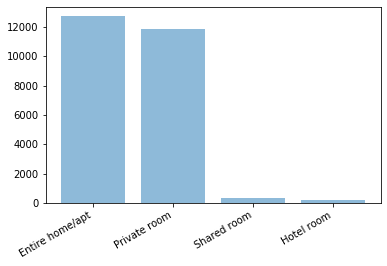

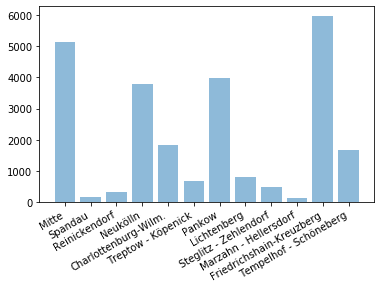

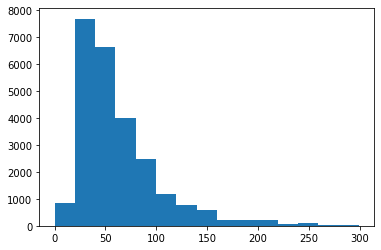

listings-2020-01 6384


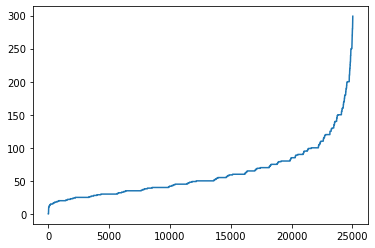

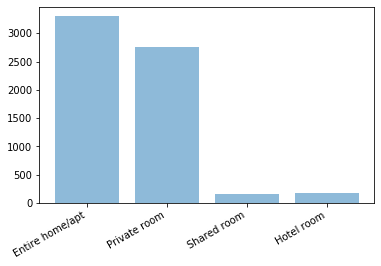

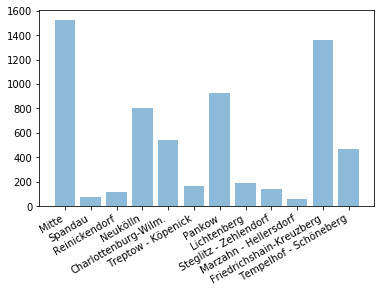

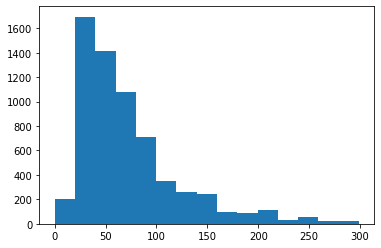

listings-2020-01 18658


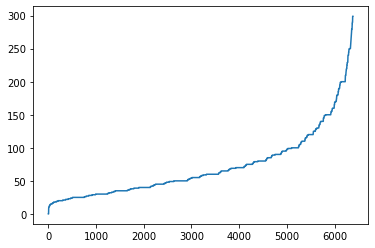

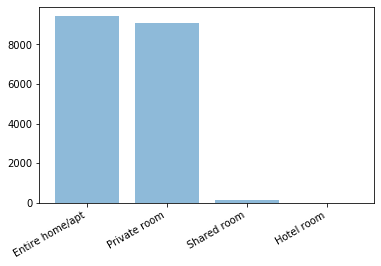

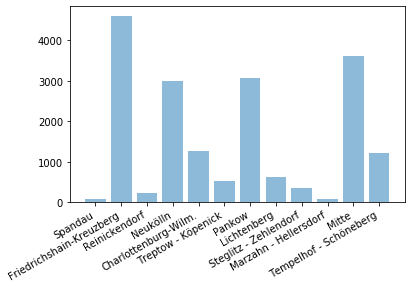

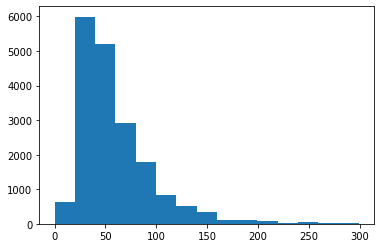

listings-2020-02 24885


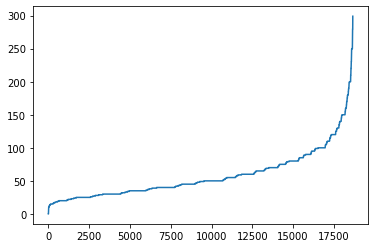

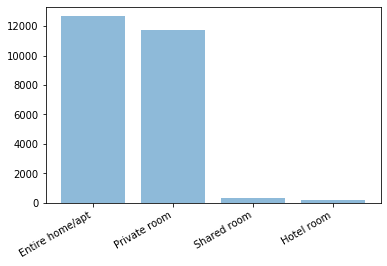

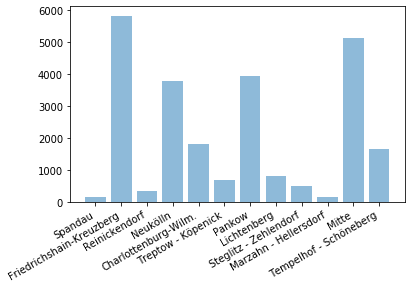

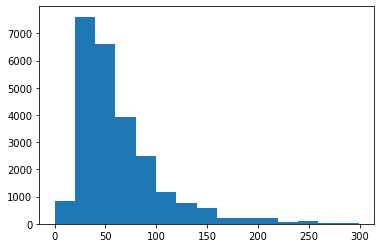

listings-2020-02 6331


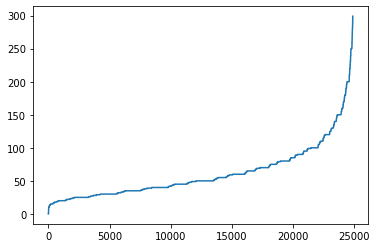

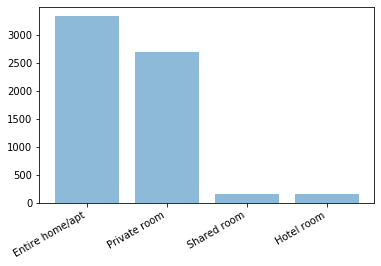

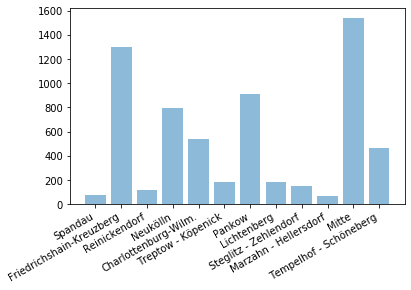

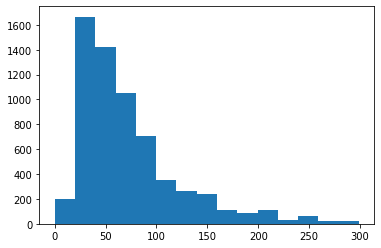

listings-2020-02 18554


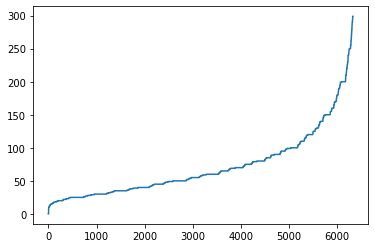

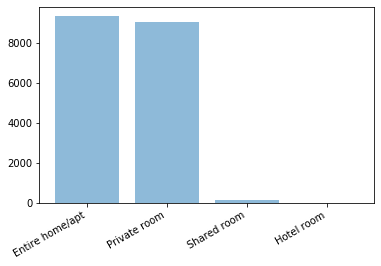

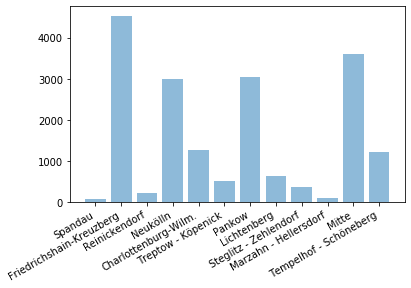

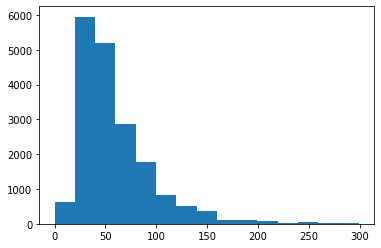

listings-2020-03 24845


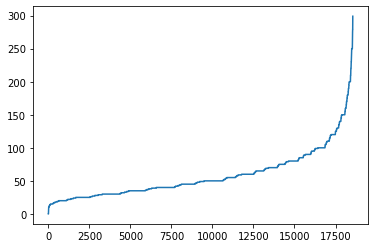

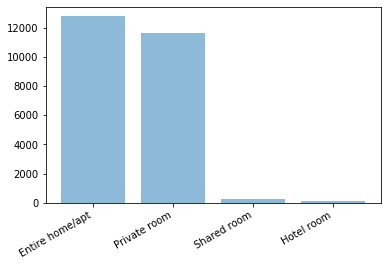

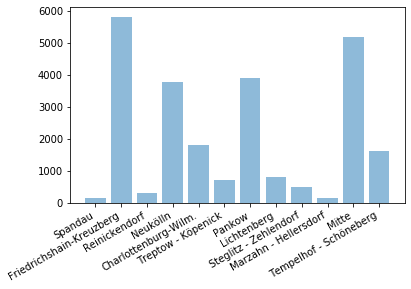

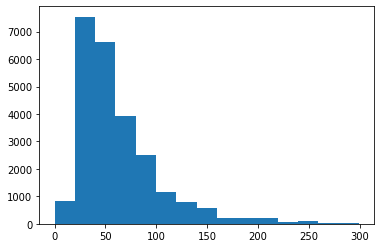

listings-2020-03 6421


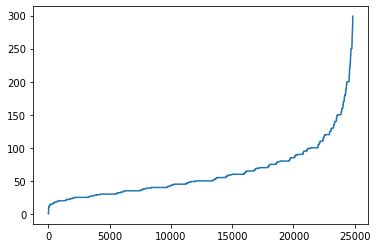

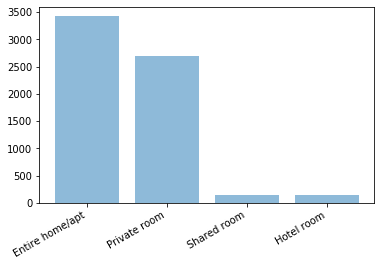

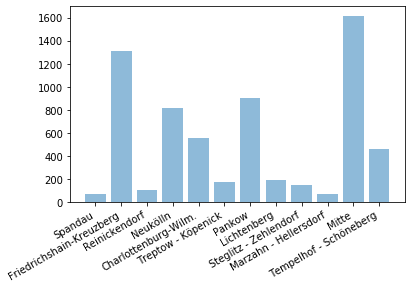

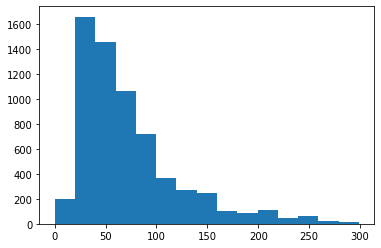

listings-2020-03 18424


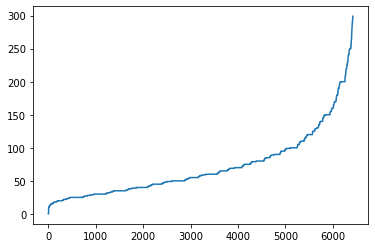

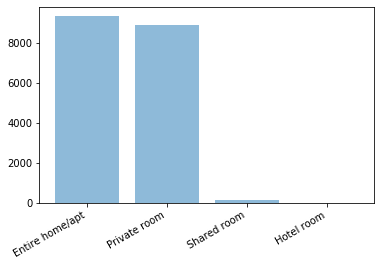

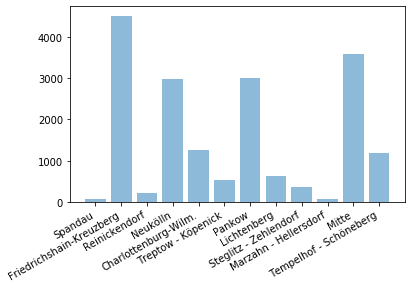

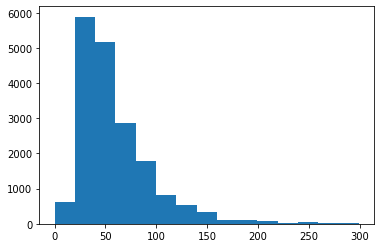

listings-2020-04 24417


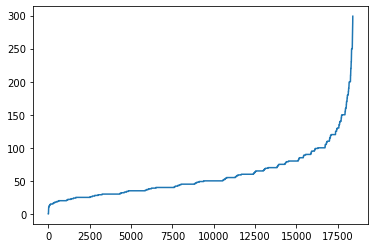

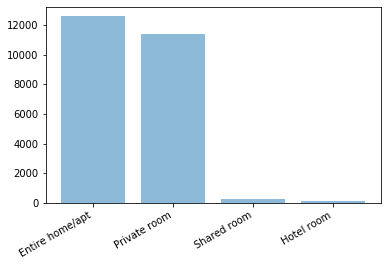

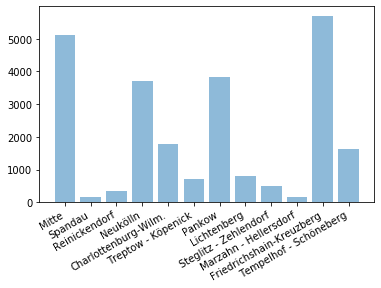

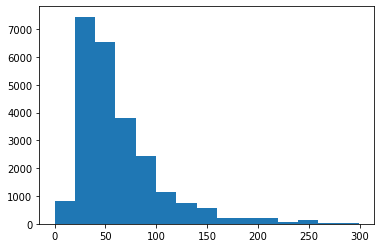

listings-2020-04 6296


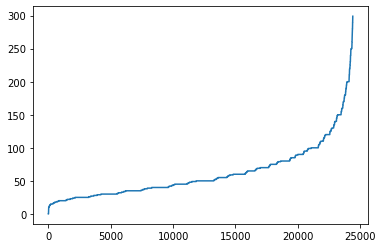

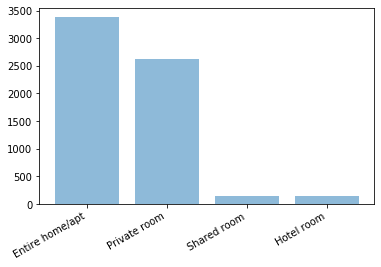

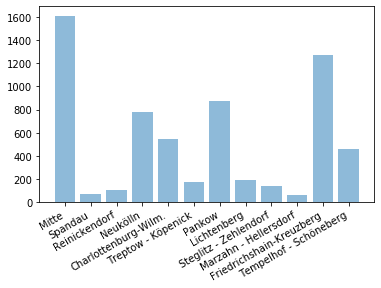

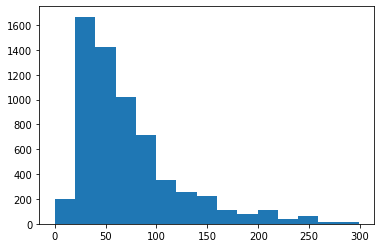

listings-2020-04 18121


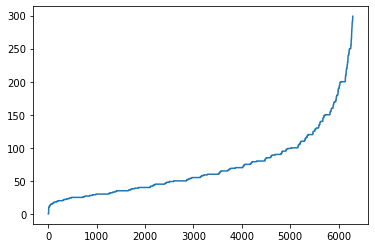

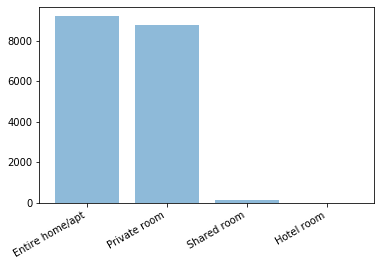

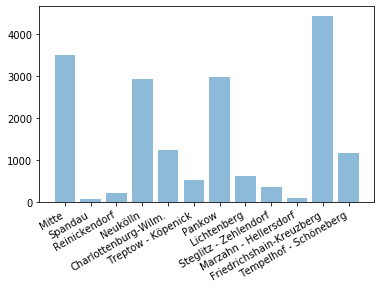

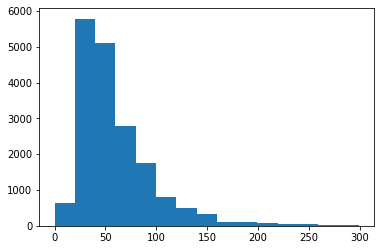

listings-2020-05 24364


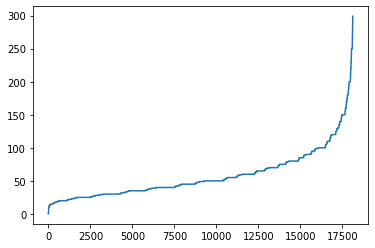

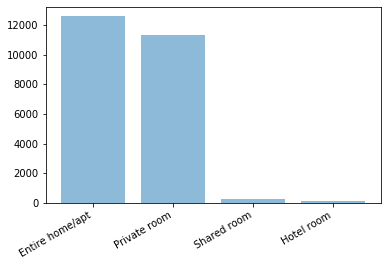

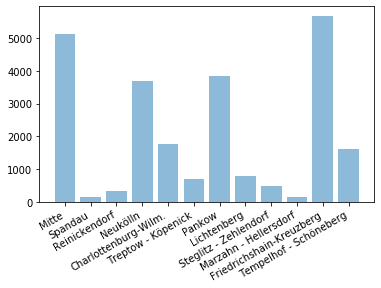

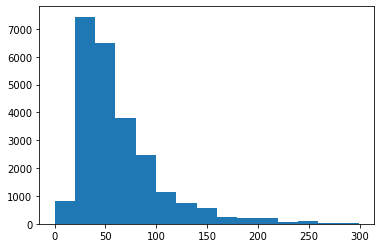

listings-2020-05 6290


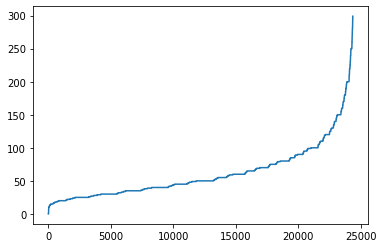

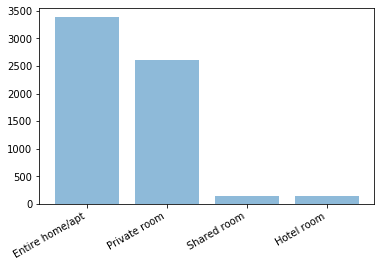

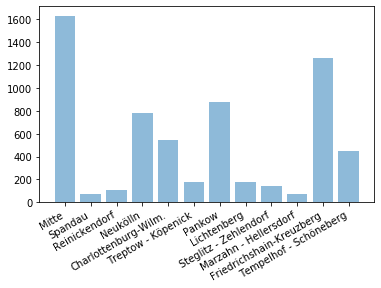

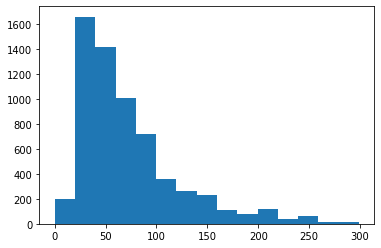

listings-2020-05 18074


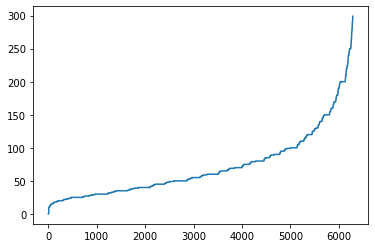

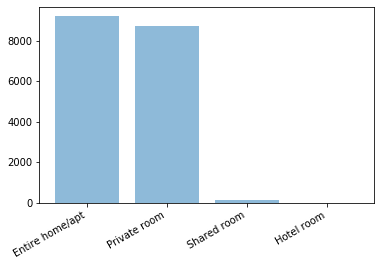

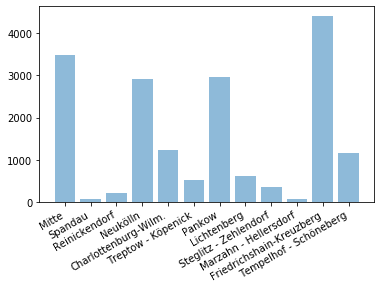

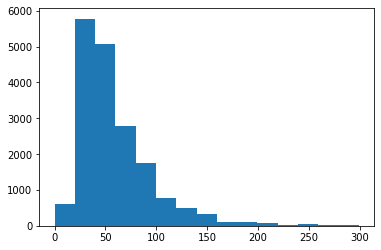

listings-2020-06 24492


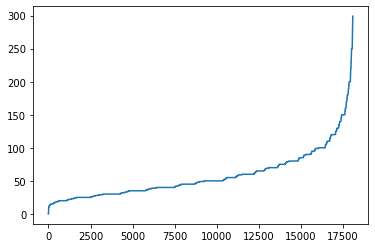

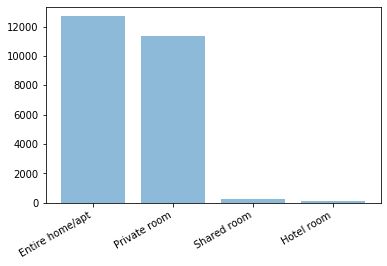

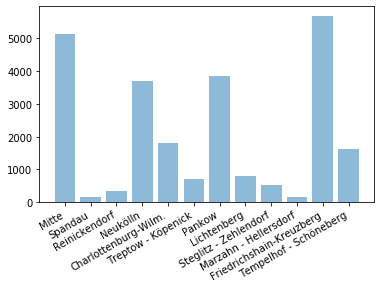

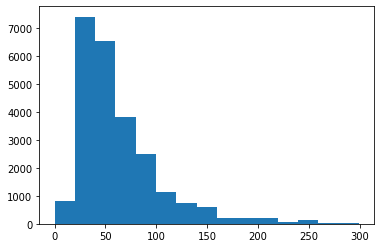

listings-2020-06 6336


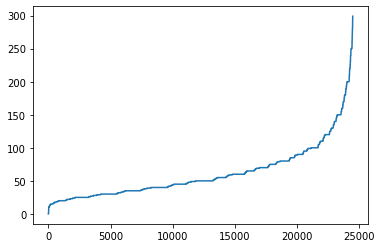

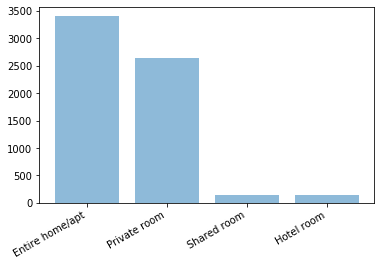

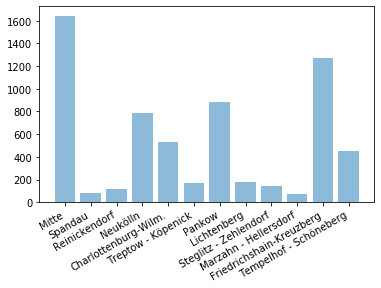

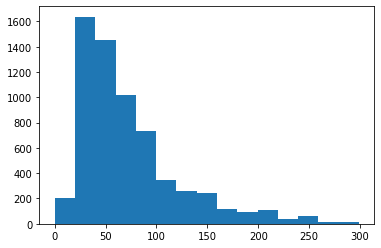

listings-2020-06 18156


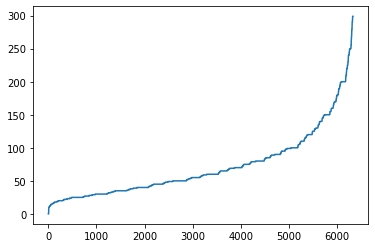

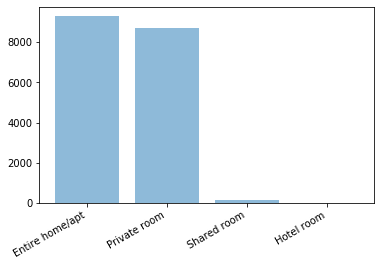

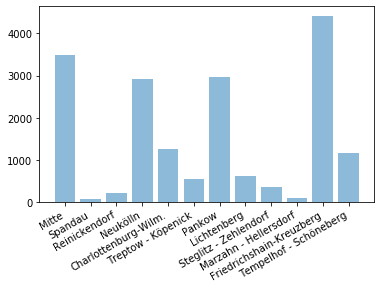

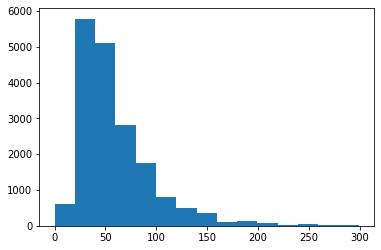

listings-2020-08 20211


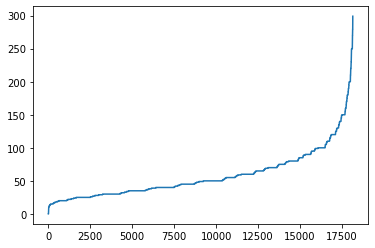

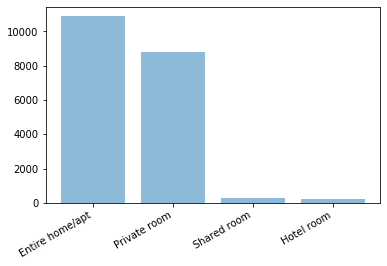

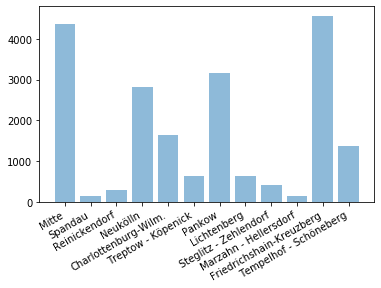

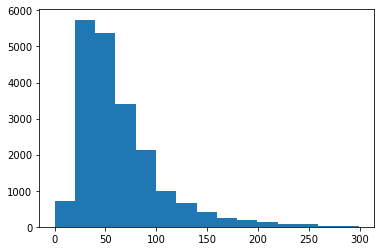

listings-2020-08 5560


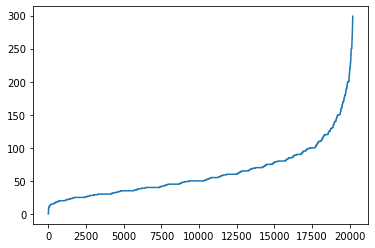

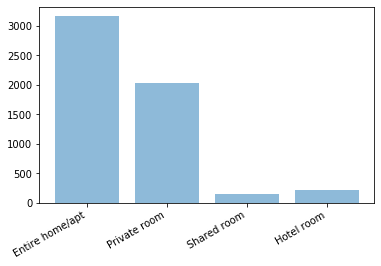

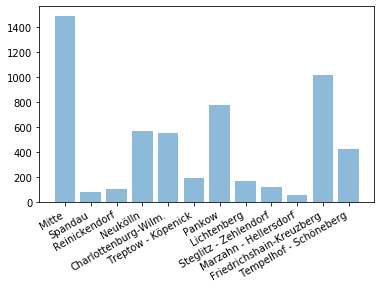

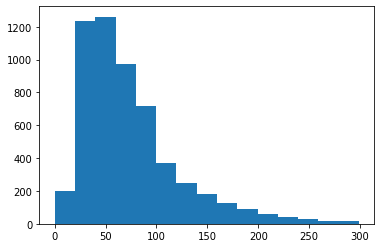

listings-2020-08 14651


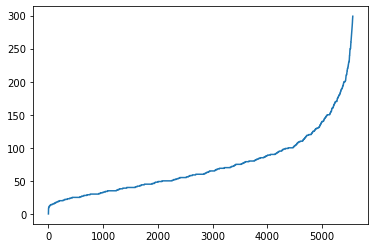

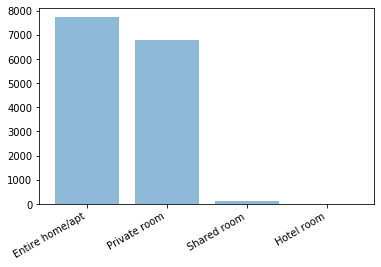

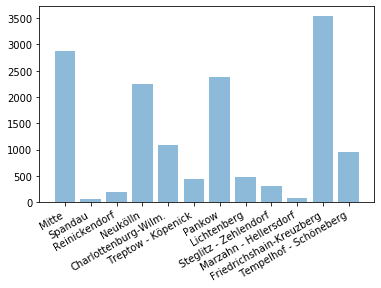

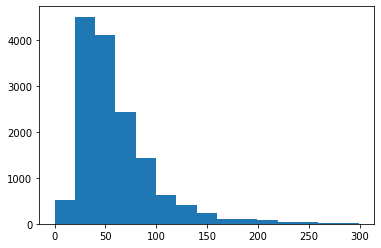

listings-2020-09 20089


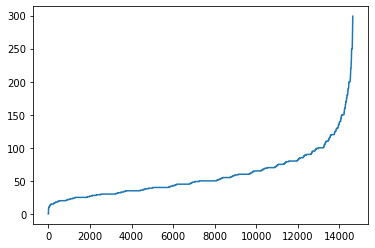

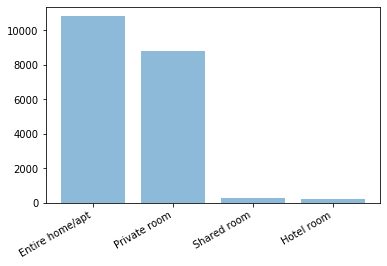

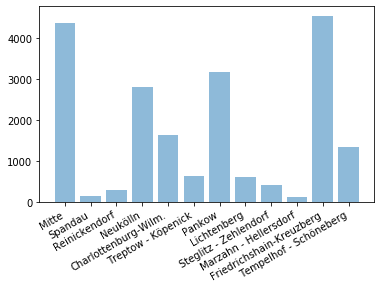

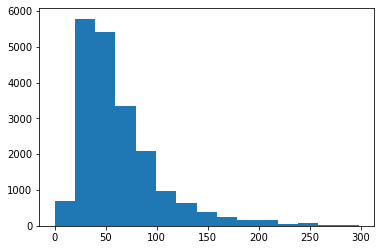

listings-2020-09 5537


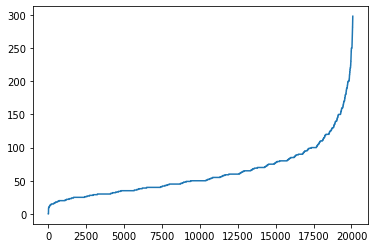

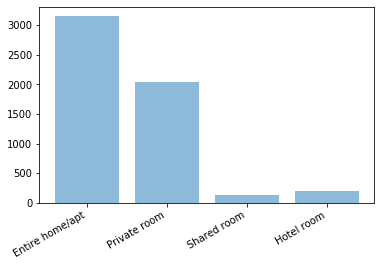

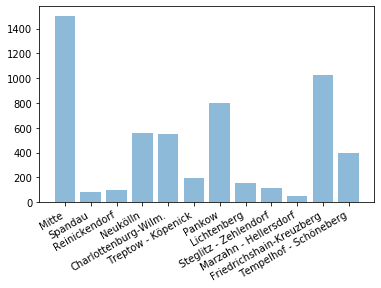

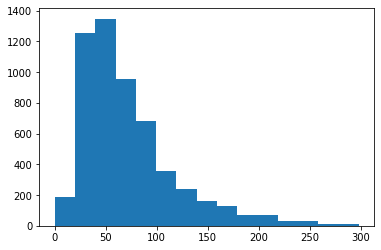

listings-2020-09 14552


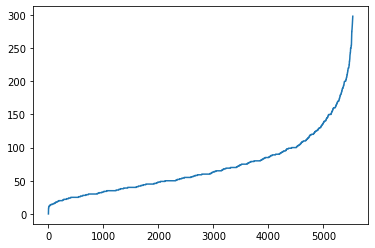

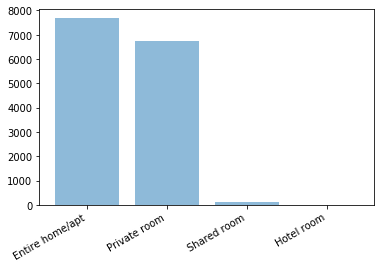

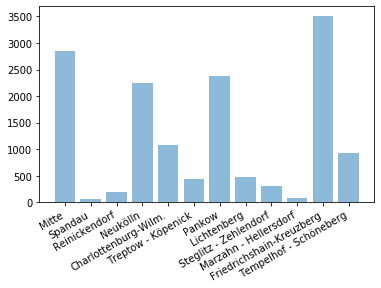

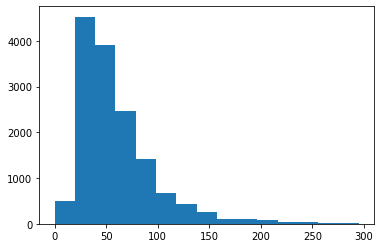

listings-2020-10 20029


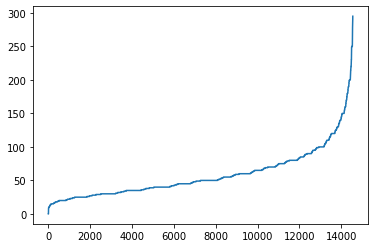

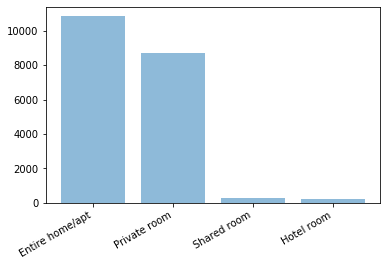

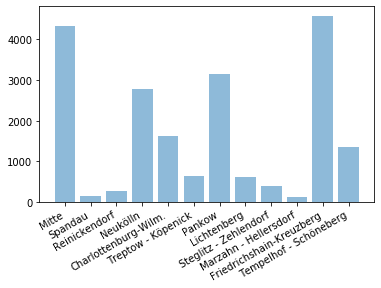

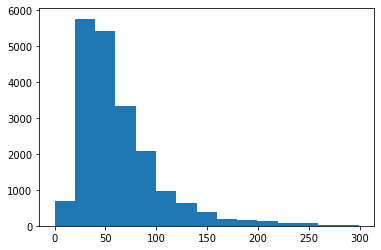

listings-2020-10 5549


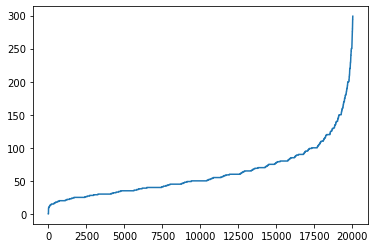

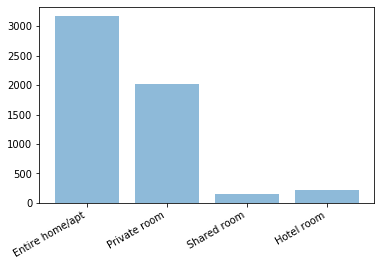

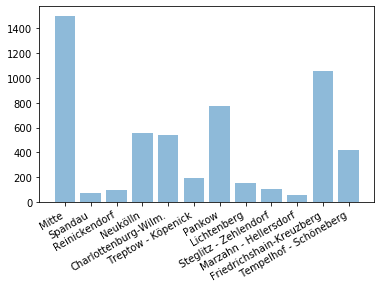

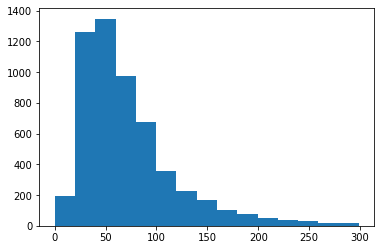

listings-2020-10 14480


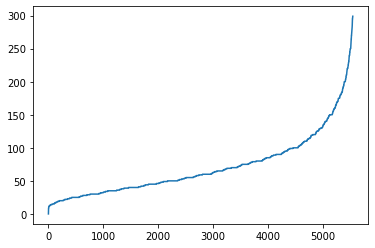

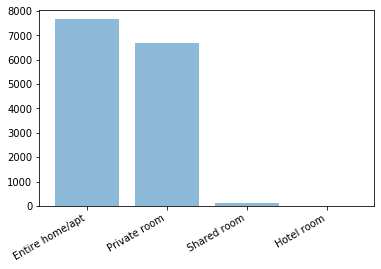

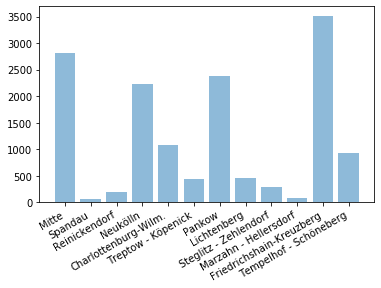

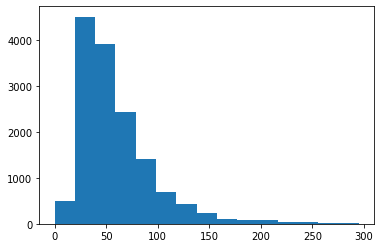

listings-2020-11 20017


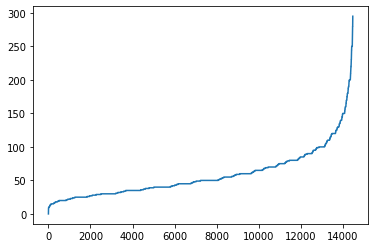

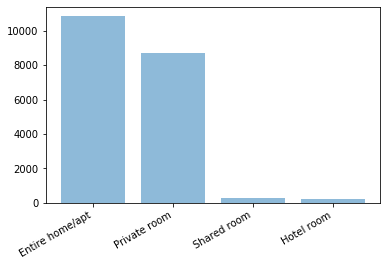

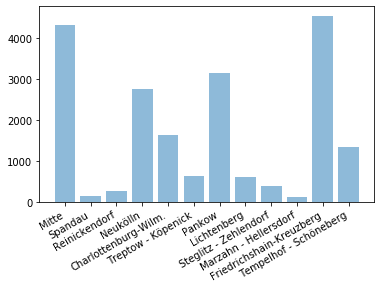

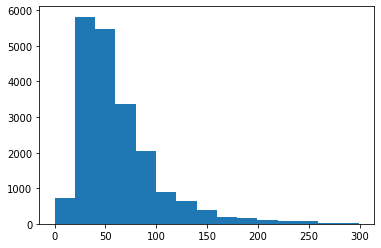

listings-2020-11 5596


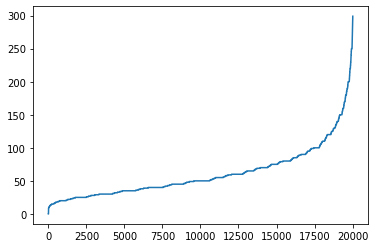

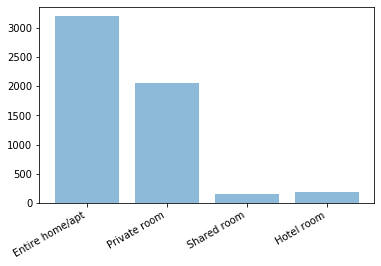

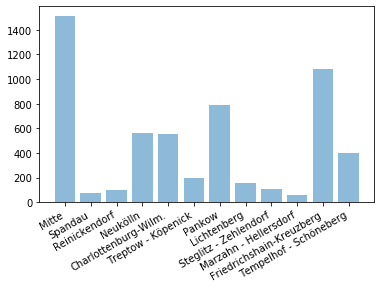

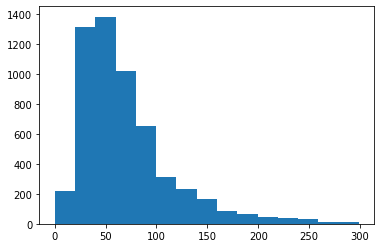

listings-2020-11 14421


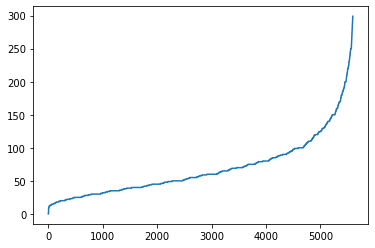

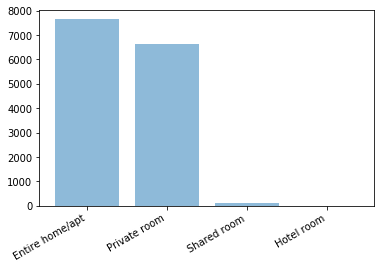

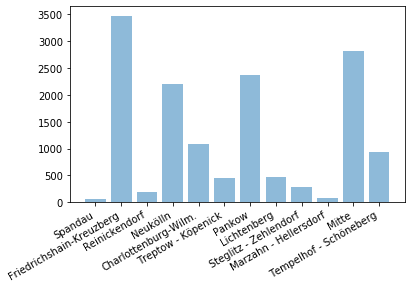

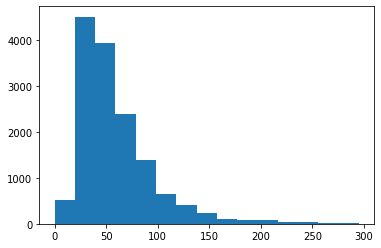

listings-2020-12 19932


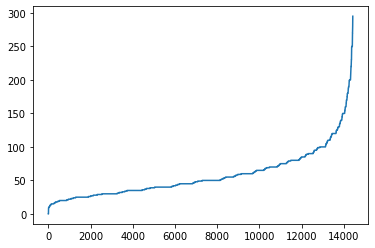

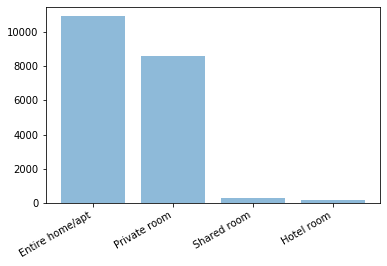

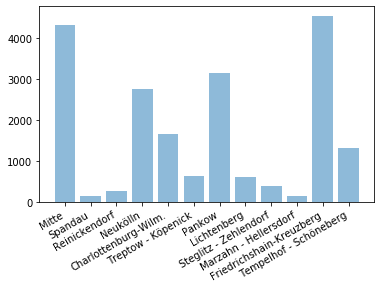

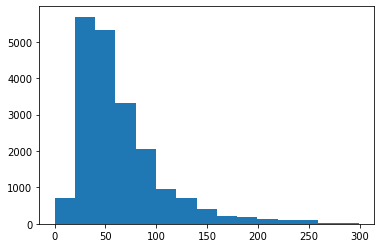

listings-2020-12 5603


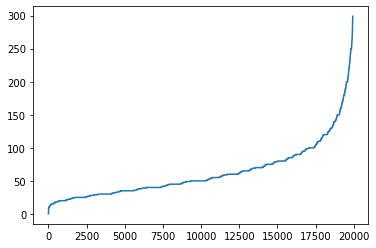

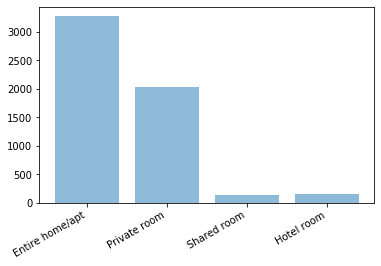

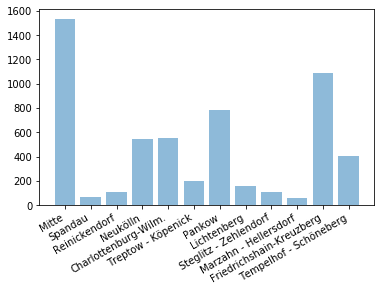

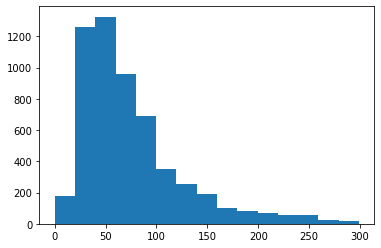

listings-2020-12 14329


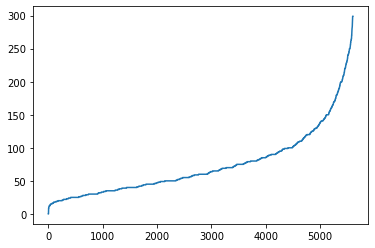

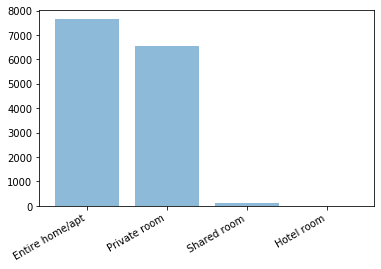

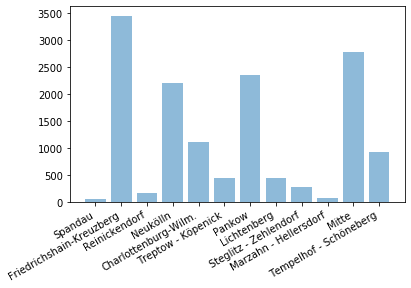

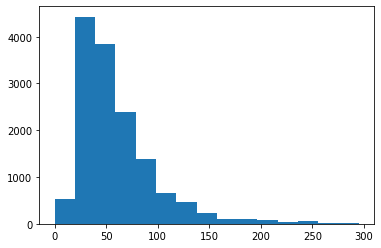

listings-2021-01 19797


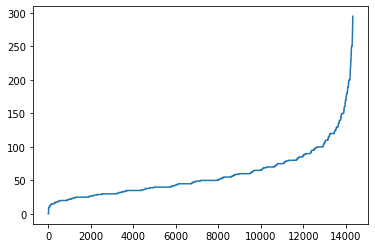

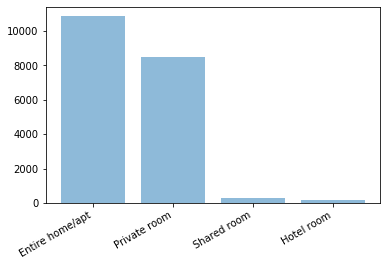

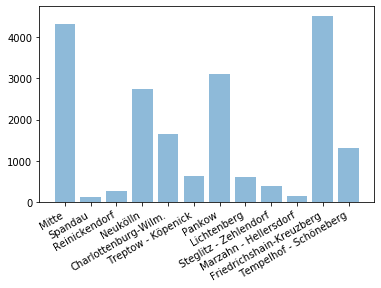

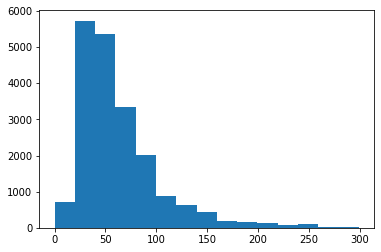

listings-2021-01 5581


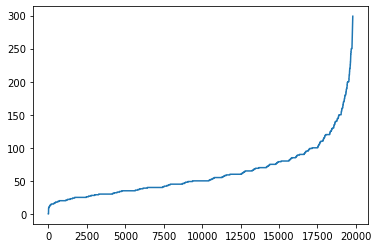

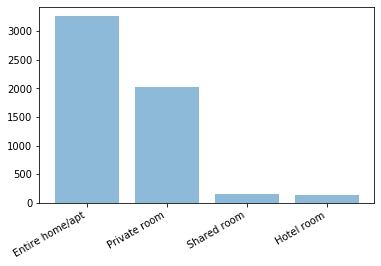

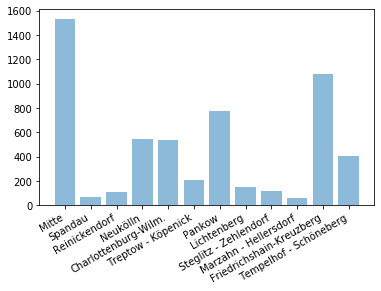

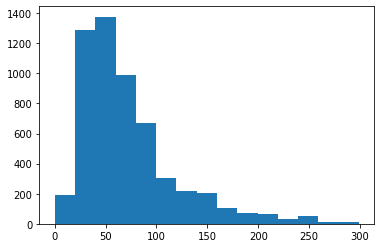

listings-2021-01 14216


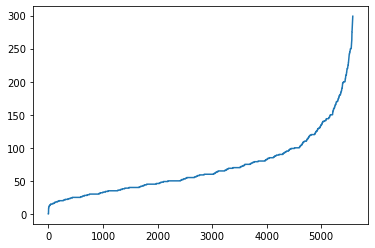

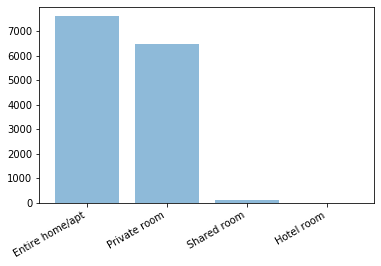

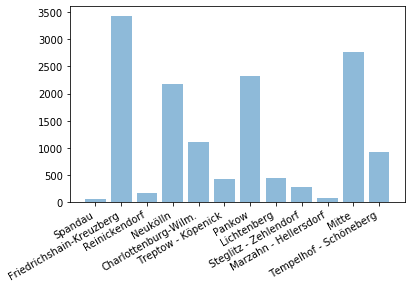

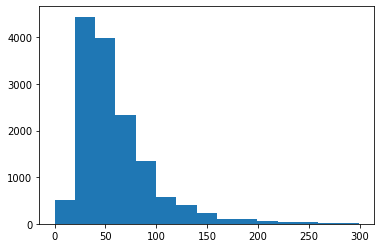

listings-2021-02 19726


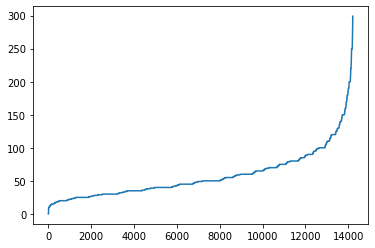

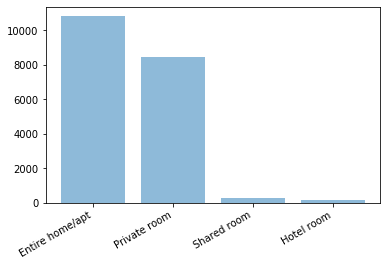

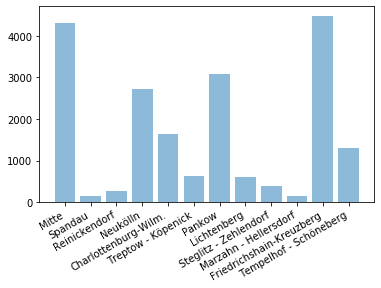

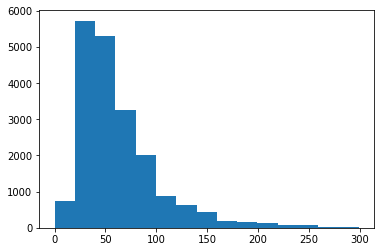

listings-2021-02 5576


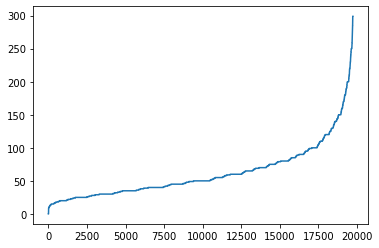

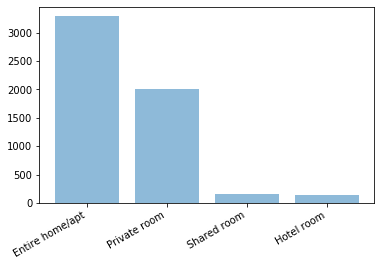

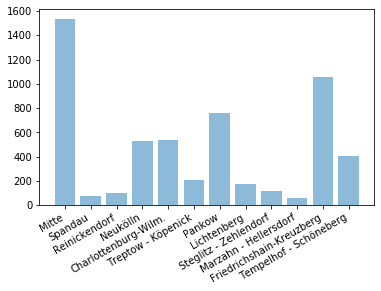

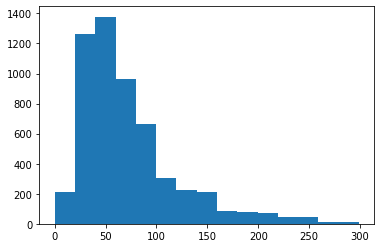

listings-2021-02 14150


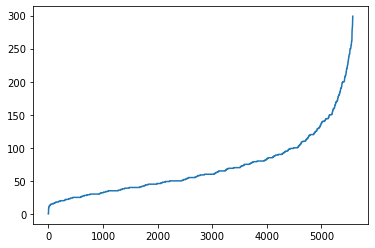

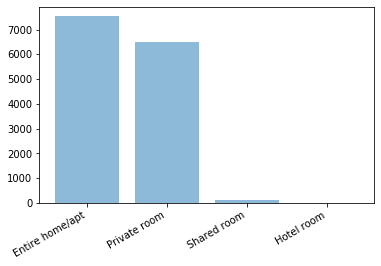

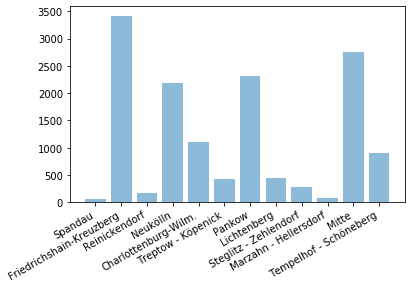

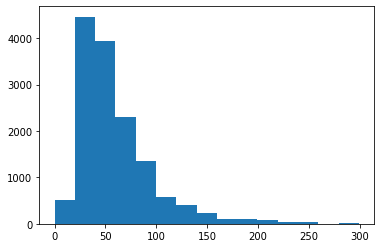

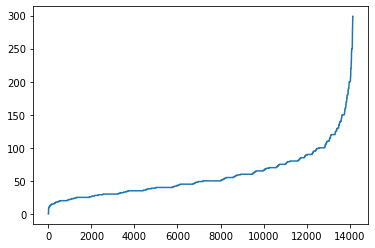

In [192]:
metadata = []
single_meta = []
multi_meta = []
datatype = 'listings' #we focus on listings this time
existing_files = os.listdir('data') #what files do we have yet? We will work with those
root_database_years = ['2015','2016','2017','2018','2019','2020','2021'] 
root_database_months= ['01','02','03','04','05','06','07','08','09','10','11','12'] 
for datayear in root_database_years: #which year
    for datamonth in root_database_months: #which month
        if str(datatype+'-'+datayear+'-'+datamonth+'.csv') in existing_files: #if we have the file
            
            df = pd.read_csv('data/'+datatype+'-'+datayear+'-'+datamonth+'.csv') #we open the dataframe
            active_meta = collect_data_from_timestamp_df(df, str(datatype+'-'+datayear+'-'+datamonth)) #we collect the data
            metadata.append(active_meta) #we append each month's result happily to our metadata
            
            df = pd.read_csv('data/'+datatype+'-'+datayear+'-'+datamonth+'.csv') #we open the dataframe
            multi = df[df['calculated_host_listings_count'] >1]
            active_multi = collect_data_from_timestamp_df(multi, str(datatype+'-'+datayear+'-'+datamonth)) #we collect the data
            multi_meta.append(active_multi)

            df = pd.read_csv('data/'+datatype+'-'+datayear+'-'+datamonth+'.csv') #we open the dataframe
            single= df[df['calculated_host_listings_count'] == 1]
            active_single = collect_data_from_timestamp_df(single, str(datatype+'-'+datayear+'-'+datamonth)) #we collect the data
            single_meta.append(active_single)


In [224]:
#Let's collect our first time_series: the means of the numeric values in each given timestamp
when = []

monthly_reviews = []
monthly_latitude = []
monthly_longitude = []
monthly_min_nights = []
monthly_sum_reviews = []
monthly_availability = []
monthly_properties = []
monthly_proptypes = []
monthly_apartments = []
monthly_privrooms = []
monthly_gini = []
monthly_prices = []

multi_sum_reviews = []
multi_reviews = []
multi_availability = []
multi_min_nights = []
multi_properties = []
multi_proptypes = [] 
multi_apartments = []
multi_privrooms = []
multi_gini = []
multi_prices = []

single_sum_reviews = []
single_reviews = []
single_availability = []
single_min_nights = []
single_properties = []
single_proptypes = []
single_apartments = []
single_privrooms = []
single_gini = []
single_prices = []

for i in range(len(metadata)):
    #We get from the i-th time period's return result 
    #[1] element of this is the macrostat which contains df columns with descriptive statistical values
    #we manually select the column that we are interested in
    #[1] element of the column is the mean (for further info see: df.desribe())
    monthly_reviews.append(metadata[i][1]["reviews_per_month"][1]) 
    monthly_latitude.append(metadata[i][1]["latitude"][1])         
    monthly_longitude.append(metadata[i][1]["longitude"][1])
    monthly_min_nights.append(metadata[i][1]["minimum_nights"][1])
    monthly_sum_reviews.append(metadata[i][1]["number_of_reviews"][1])
    monthly_availability.append(metadata[i][1]["availability_365"][1])
    monthly_properties.append(metadata[i][1]['minimum_nights'][0])
    monthly_apartments.append(metadata[i][3][1][0])
    monthly_privrooms.append(metadata[i][3][1][1])
    monthly_gini.append(metadata[i][6])
    monthly_prices.append(metadata[i][5])
    
    when.append(metadata[i][0][9:]) #We only keep the 'year-mo' string format so we can convert the string to date
    #converting is useful to have a general algorithm that works when we miss some files, the plots can be interpolated automatically
    
    multi_sum_reviews.append(multi_meta[i][1]["number_of_reviews"][1])
    multi_reviews.append(multi_meta[i][1]["reviews_per_month"][1]) 
    multi_availability.append(multi_meta[i][1]["availability_365"][1])
    multi_min_nights.append(multi_meta[i][1]["minimum_nights"][1])
    multi_properties.append(multi_meta[i][1]["minimum_nights"][0])
    multi_apartments.append(multi_meta[i][3][1][0])
    multi_privrooms.append(multi_meta[i][3][1][1])
    multi_gini.append(multi_meta[i][6])
    multi_prices.append(multi_meta[i][5])
    
    single_sum_reviews.append(single_meta[i][1]["number_of_reviews"][1])
    single_reviews.append(single_meta[i][1]["reviews_per_month"][1])
    single_availability.append(single_meta[i][1]["availability_365"][1])
    single_min_nights.append(single_meta[i][1]["minimum_nights"][1])
    single_properties.append(single_meta[i][1]["minimum_nights"][0])
    single_apartments.append(single_meta[i][3][1][0])
    single_privrooms.append(single_meta[i][3][1][1])
    single_gini.append(single_meta[i][6])
    single_prices.append(single_meta[i][5])
    
import datetime #We have to convert our string date to date object 
for i in range(len(when)):
    when[i] = datetime.datetime.strptime(when[i], '%Y-%m')

#We make a function to automatically plot a series of dates and a series of data
def plot_timeseries(when, series):
    fig, ax1 = plt.subplots()
    ax1.plot(when,series)
    fig.autofmt_xdate()
    fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
    #Source for above snippet: https://www.semicolonworld.com/question/56046/matplotlib-how-to-prevent-x-axis-labels-from-overlapping-each-other

    plt.show()

## Part III: Initial results and first responses ##

A földrajzi elhelyezkedés 'átlagos centruma' nagyjából visszakerült a 2016-os szintre.


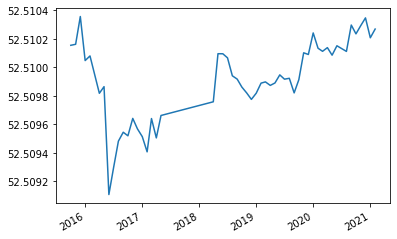

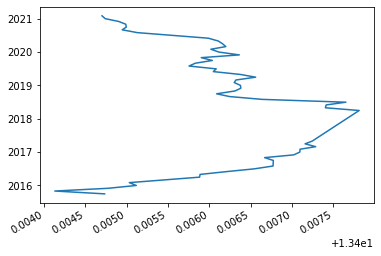

In [198]:
print("A földrajzi elhelyezkedés 'átlagos centruma' nagyjából visszakerült a 2016-os szintre.")
plot_timeseries(when,monthly_latitude) #North-South
plot_timeseries(monthly_longitude,when) #East to West therefore rotatio

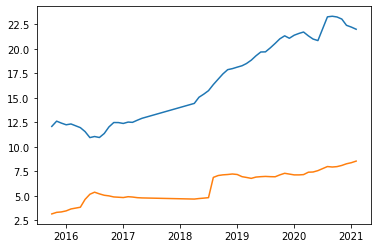

In [199]:
plt.plot(when,monthly_sum_reviews,when, monthly_min_nights)
plt.show()

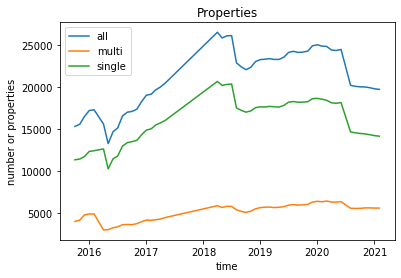

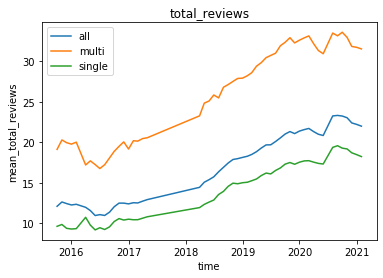

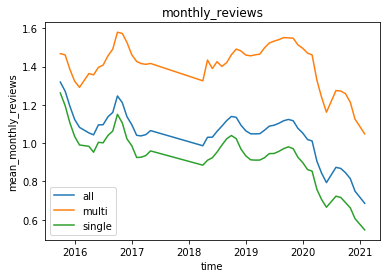

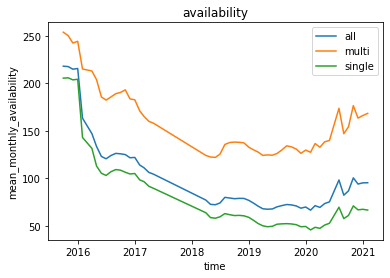

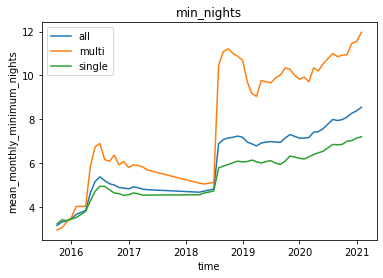

In [314]:
plt.plot(when,monthly_properties, label='all')
plt.plot(when,multi_properties, label='multi')
plt.plot(when,single_properties, label='single')
plt.legend()

plt.xlabel("time")
plt.ylabel("number or properties")
plt.title("Properties")
plt.show()

plt.plot(when,monthly_sum_reviews, label='all')
plt.plot(when,multi_sum_reviews, label='multi')
plt.plot(when, single_sum_reviews, label='single')
plt.legend()

plt.title("total_reviews")
plt.xlabel("time")
plt.ylabel("mean_total_reviews")
plt.show()

plt.plot(when,monthly_reviews,label='all')
plt.plot(when,multi_reviews,label='multi')
plt.plot(when, single_reviews,label='single')
plt.legend()
plt.title("monthly_reviews")
plt.ylabel("mean_monthly_reviews")
plt.xlabel("time")

plt.show()

plt.plot(when,monthly_availability,label='all')
plt.plot(when,multi_availability,label='multi')
plt.plot(when, single_availability,label='single')
plt.legend()
plt.title("availability")
plt.ylabel("mean_monthly_availability")
plt.xlabel("time")

plt.show()

plt.plot(when,monthly_min_nights,label='all')
plt.plot(when,multi_min_nights,label='multi')
plt.plot(when, single_min_nights,label='single')
plt.legend()
plt.title("min_nights")
plt.ylabel("mean_monthly_minimum_nights")
plt.xlabel("time")

plt.show()

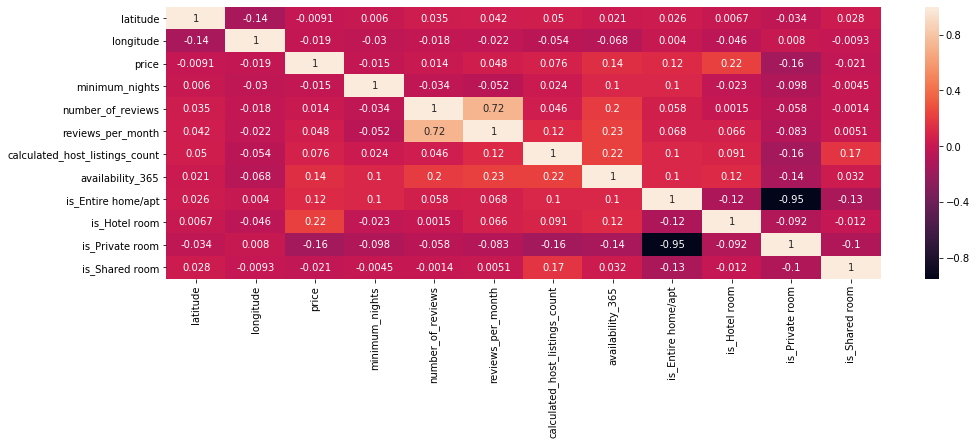

In [306]:
df = pd.read_csv('data/'+datatype+'-'+'2020'+'-'+datamonth+'.csv') #we open the dataframe
df.drop(['id', 'host_id'], axis='columns', inplace=True)
# create dummies: https://stackoverflow.com/questions/36544089/pandas-create-boolean-columns-from-categorical-column
df1 = df.room_type.str.get_dummies()
df1.columns = ['is_' + col for col in df1.columns]
df = pd.concat([df, df1], axis=1)
CM = df.corr()
plt.figure(figsize = (16,5))
sn.heatmap(CM, annot=True)
plt.show()

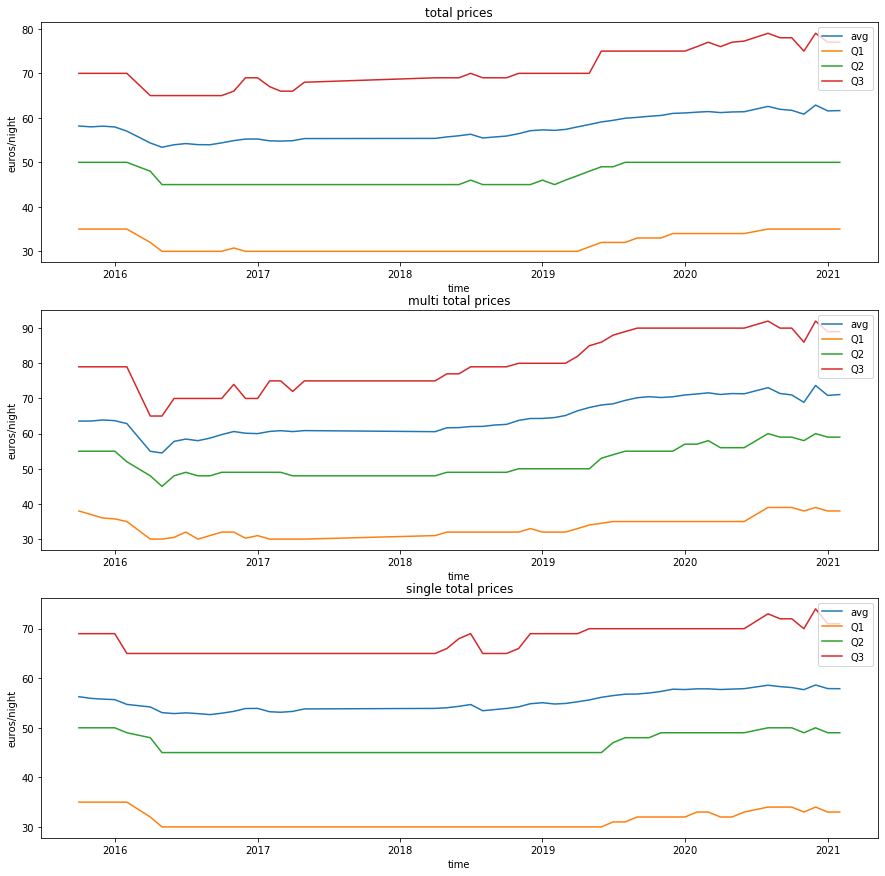

In [263]:
from statistics import mean

monthly_avg_price = []
monthly_Q1_price = []
monthly_Q3_price = []
monthly_Q2_price = []
for i in range(len(monthly_prices)):
    monthly_avg_price.append(mean(monthly_prices[i]))
    monthly_Q1_price.append(np.quantile(monthly_prices[i], 0.25))
    monthly_Q3_price.append(np.quantile(monthly_prices[i], 0.75))
    monthly_Q2_price.append((np.quantile(monthly_prices[i], 0.5)))

multi_avg_price = []
multi_Q1_price = []
multi_Q3_price = []
multi_Q2_price = []
for i in range(len(monthly_prices)):
    multi_avg_price.append(mean(multi_prices[i]))
    multi_Q1_price.append(np.quantile(multi_prices[i], 0.25))
    multi_Q3_price.append(np.quantile(multi_prices[i], 0.75))
    multi_Q2_price.append((np.quantile(multi_prices[i], 0.5)))

single_avg_price = []
single_Q1_price = []
single_Q3_price = []
single_Q2_price = []
for i in range(len(monthly_prices)):
    single_avg_price.append(mean(single_prices[i]))
    single_Q1_price.append(np.quantile(single_prices[i], 0.25))
    single_Q3_price.append(np.quantile(single_prices[i], 0.75))
    single_Q2_price.append((np.quantile(single_prices[i], 0.5)))

fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(15,15))
    
ax1.plot(when,monthly_avg_price, label='avg')
ax1.plot(when,monthly_Q1_price, label='Q1')
ax1.plot(when,monthly_Q2_price, label='Q2')
ax1.plot(when,monthly_Q3_price, label='Q3')
ax1.legend()
ax1.set_title("total prices")
ax1.set_xlabel("time")
ax1.set_ylabel("euros/night")


ax2.plot(when,multi_avg_price, label='avg')
ax2.plot(when,multi_Q1_price, label='Q1')
ax2.plot(when,multi_Q2_price, label='Q2')
ax2.plot(when,multi_Q3_price, label='Q3')
ax2.legend()
ax2.set_title("multi total prices")
ax2.set_xlabel("time")
ax2.set_ylabel("euros/night")

ax3.plot(when,single_avg_price, label='avg')
ax3.plot(when,single_Q1_price, label='Q1')
ax3.plot(when,single_Q2_price, label='Q2')
ax3.plot(when,single_Q3_price, label='Q3')
ax3.legend()
ax3.set_title("single total prices")
ax3.set_xlabel("time")
ax3.set_ylabel("euros/night")
plt.show()

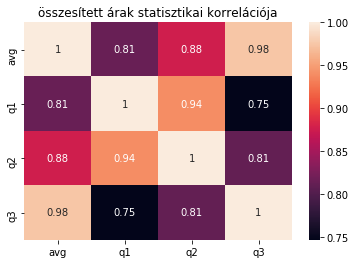

q1-q3 corr:  0.7471
q1-q3 p:  0.0


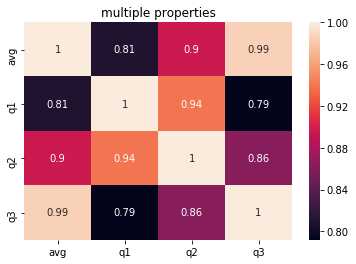

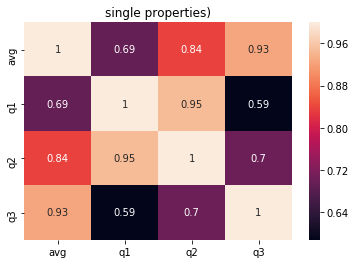

In [315]:
data = {'avg': monthly_avg_price,
        'q1': monthly_Q1_price,
        'q2': monthly_Q2_price,
        'q3': monthly_Q3_price
        }
df = pd.DataFrame(data,columns=['avg','q1','q2','q3'])
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title('összesített árak statisztikai korrelációja')
plt.show()
#https://www.youtube.com/watch?v=o7VCeCxHCTI
r, p = stats.pearsonr(df.q1, df.q3)
print('q1-q3 corr:  '+str(round(r, 4)))
print('q1-q3 p:  '+str(round(p, 4)))

data = {'avg': multi_avg_price,
        'q1': multi_Q1_price,
        'q2': multi_Q2_price,
        'q3': multi_Q3_price
        }

df = pd.DataFrame(data,columns=['avg','q1','q2','q3'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title('multiple properties')
plt.show()

data = {'avg': single_avg_price,
        'q1': single_Q1_price,
        'q2': single_Q2_price,
        'q3': single_Q3_price
        }

df = pd.DataFrame(data,columns=['avg','q1','q2','q3'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title('single properties)')
plt.show()

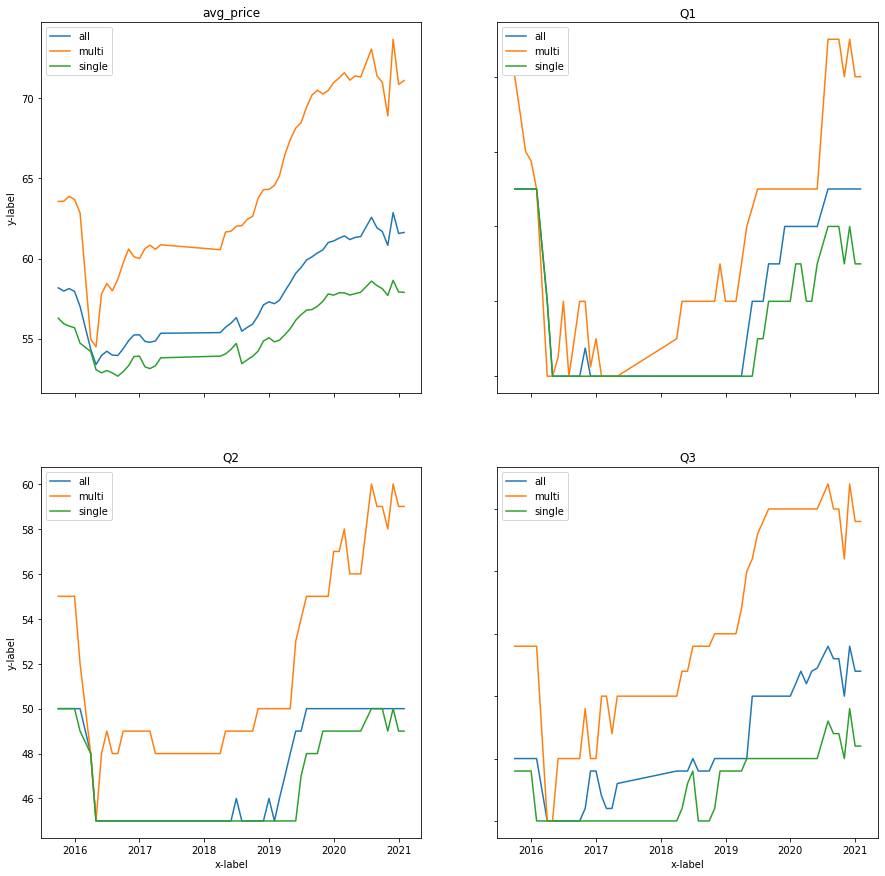

In [250]:
f, axs = plt.subplots(2,2,figsize=(15,15))

axs[0, 0].plot(when,monthly_avg_price, label='all')
axs[0, 0].plot(when,multi_avg_price, label='multi')
axs[0, 0].plot(when,single_avg_price, label='single')
axs[0, 0].legend()
axs[0, 0].set_title('avg_price')

axs[0, 1].plot(when,monthly_Q1_price, label='all')
axs[0, 1].plot(when,multi_Q1_price, label='multi')
axs[0, 1].plot(when,single_Q1_price, label='single')
axs[0, 1].legend()
axs[0, 1].set_title('Q1')

axs[1, 0].plot(when,monthly_Q2_price, label='all')
axs[1, 0].plot(when,multi_Q2_price, label='multi')
axs[1, 0].plot(when,single_Q2_price, label='single')
axs[1, 0].legend()
axs[1, 0].set_title('Q2')

axs[1, 1].plot(when,monthly_Q3_price, label='all')
axs[1, 1].plot(when,multi_Q3_price, label='multi')
axs[1, 1].plot(when,single_Q3_price, label='single')
axs[1, 1].legend()
axs[1, 1].set_title('Q3')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

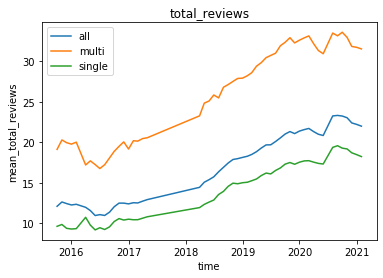

In [267]:
plt.plot(when,monthly_sum_reviews, label='all')
plt.plot(when,multi_sum_reviews, label='multi')
plt.plot(when, single_sum_reviews, label='single')
plt.legend()

plt.title("total_reviews")
plt.xlabel("time")
plt.ylabel("mean_total_reviews")
plt.show()

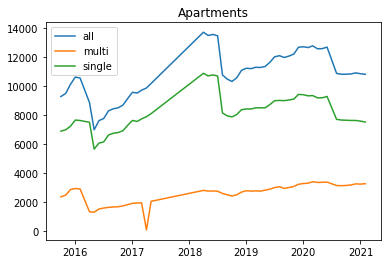

In [205]:
plt.plot(when,monthly_apartments, label='all')
plt.plot(when,multi_apartments, label='multi')
plt.plot(when,single_apartments, label='single')
plt.legend()
plt.title("Apartments")
plt.show()

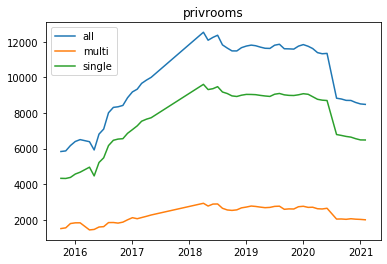

In [206]:
plt.plot(when,monthly_privrooms, label='all')
plt.plot(when,multi_privrooms, label='multi')
plt.plot(when,single_privrooms, label='single')
plt.legend()
plt.title("privrooms")
plt.show()

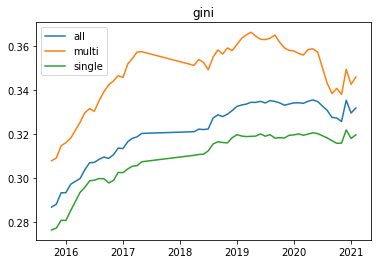

In [207]:
plt.plot(when,monthly_gini, label='all')
plt.plot(when,multi_gini, label='multi')
plt.plot(when,single_gini, label='single')
plt.legend()
plt.title("gini")
plt.show()

In [324]:
monthly_prop_change = []
multi_prop_change = []
single_prop_change = []
monthly_avg_price_change = []
multi_avg_price_change = []
single_avg_price_change = []
monthly_review_change = []
multi_review_change = []
single_review_change = []

for i in range(len(monthly_properties)-1):
    monthly_prop_change.append(int(monthly_properties[i+1])/int(monthly_properties[i]))
    multi_prop_change.append(int(multi_properties[i+1])/int(multi_properties[i]))
    single_prop_change.append(int(single_properties[i+1])/int(single_properties[i]))
    
    monthly_avg_price_change.append(int(monthly_avg_price[i+1])/int(monthly_avg_price[i]))
    multi_avg_price_change.append(int(multi_avg_price[i+1])/int(multi_avg_price[i]))
    single_avg_price_change.append(int(single_avg_price[i+1])/int(single_avg_price[i]))
    
    monthly_review_change.append(float(monthly_reviews[i+1])/float(monthly_reviews[i]))
    multi_review_change.append(float(multi_reviews[i+1])/float(multi_reviews[i]))
    single_review_change.append(float(single_reviews[i+1])/float(single_reviews[i]))

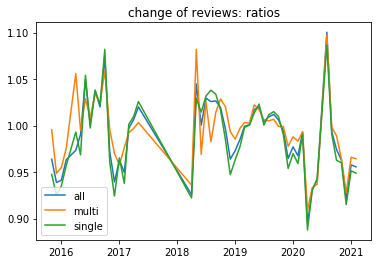

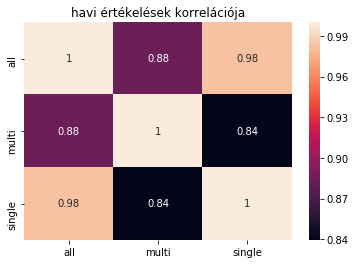

0.8396
0.0


In [332]:
plt.plot(when[1:],monthly_review_change, label='all')
plt.plot(when[1:],multi_review_change, label='multi')
plt.plot(when[1:],single_review_change, label='single')
plt.legend()
plt.title('change of reviews: ratios')
plt.show()

data = {'all': monthly_review_change,
        'multi': multi_review_change,
        'single': single_review_change
        }

df = pd.DataFrame(data,columns=['all','multi','single'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title('havi értékelések korrelációja')
plt.show()

#https://www.youtube.com/watch?v=o7VCeCxHCTI
r, p = stats.pearsonr(df.multi, df.single)
print(round(r, 4))
print(round(p, 4))

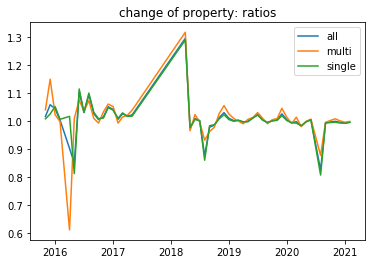

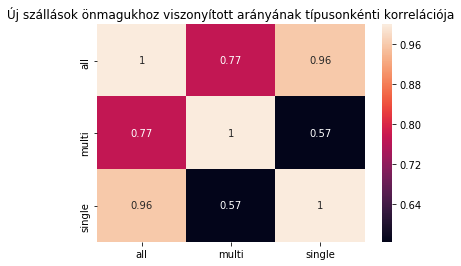

0.5654
0.0


In [333]:
plt.plot(when[1:],monthly_prop_change, label='all')
plt.plot(when[1:],multi_prop_change, label='multi')
plt.plot(when[1:],single_prop_change, label='single')
plt.legend()
plt.title('change of property: ratios')
plt.show()

data = {'all': monthly_prop_change,
        'multi': multi_prop_change,
        'single': single_prop_change
        }

df = pd.DataFrame(data,columns=['all','multi','single'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title("Új szállások önmagukhoz viszonyított arányának típusonkénti korrelációja")
plt.show()

#https://www.youtube.com/watch?v=o7VCeCxHCTI
r, p = stats.pearsonr(df.multi, df.single)
print(round(r, 4))
print(round(p, 4))

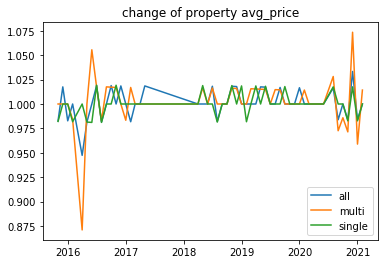

In [271]:
plt.plot(when[1:],monthly_avg_price_change, label='all')
plt.plot(when[1:],multi_avg_price_change, label='multi')
plt.plot(when[1:],single_avg_price_change, label='single')
plt.legend()
plt.title('change of property avg_price')
plt.show()

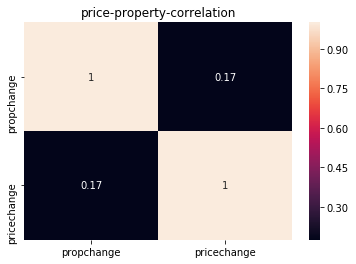

0.175
0.2147


In [317]:
data = {'propchange': monthly_prop_change,
        'pricechange': monthly_avg_price_change,
        }

df = pd.DataFrame(data,columns=['propchange','pricechange'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title("price-property-correlation")
plt.show()

r, p = stats.pearsonr(df.propchange, df.pricechange)
print(round(r, 4))
print(round(p, 4))

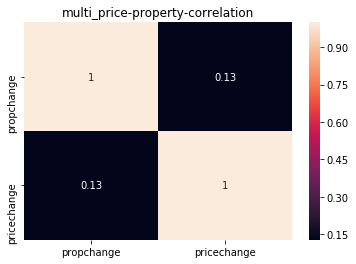

0.127
0.5636


In [280]:
test1 = multi_prop_change[20:43]
test2 =  multi_avg_price_change[20:43]


data = {'propchange': test1,
        'pricechange': test2,
        }

df = pd.DataFrame(data,columns=['propchange','pricechange'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title("multi_price-property-correlation")
plt.show()


#https://www.youtube.com/watch?v=o7VCeCxHCTI
r, p = stats.pearsonr(df.propchange, df.pricechange)
print(round(r, 4))
print(round(p, 4))

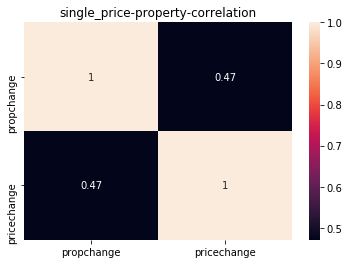

0.4707
0.0234


In [279]:
test1 = single_prop_change[20:43]
test2 =  single_avg_price_change[20:43]

data = {'propchange': test1,
        'pricechange': test2,
        }

df = pd.DataFrame(data,columns=['propchange','pricechange'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title("single_price-property-correlation")
plt.show()

#https://www.youtube.com/watch?v=o7VCeCxHCTI
r, p = stats.pearsonr(df.propchange, df.pricechange)
print(round(r, 4))
print(round(p, 4))

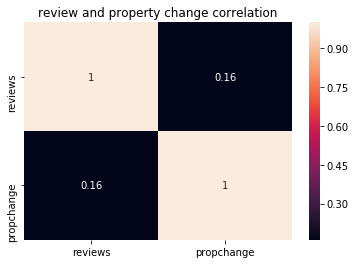

In [312]:
data = {'reviews': monthly_reviews[1:],
        'propchange': monthly_prop_change,
        }
df = pd.DataFrame(data,columns=['reviews','propchange'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title("review and property change correlation")
plt.show()

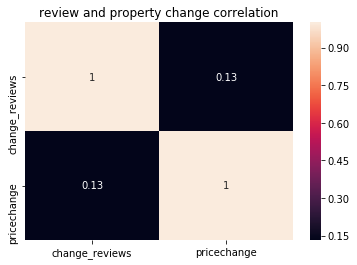

In [331]:
data = {'change_reviews': monthly_review_change,
        'pricechange': monthly_avg_price_change,
        }
df = pd.DataFrame(data,columns=['change_reviews','pricechange'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title("review and property change correlation")
plt.show()